## Imports

In [1]:
# standard libs
import os
import sys
import logging
from functools import partial


# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
import spatial_autocorrelation
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison, AgeClassifierComparison
from preprocessing import *
# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt



from xgboost import XGBRegressor, XGBClassifier

/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [14]:
df_fr = utils.load_data('france', geo=False)
df_fr_sample = utils.sample_cities(df_fr, 0.1)

df_nl = utils.load_data('netherlands', geo=False)
df_nl_sample = utils.sample_cities(df_nl, 0.1)


In [4]:
gadm_france = pd.read_csv(os.path.join('..', 'metadata', 'FR-LAU-GADM-mapping.csv'))
gadm_spain = pd.read_csv(os.path.join('..', 'metadata', 'ES-LAU-GADM-mapping.csv'))
gadm_netherlands = pd.read_csv(os.path.join('..', 'metadata', 'NL-LAU-GADM-mapping.csv'))


In [139]:
df_fr_test = pd.read_pickle('../data/prepared/df-FRA.pkl')
df_fr_test['neighborhood']


KeyError: 'neighborhood'

### Sample data for local test runs

In [5]:
df_nl_pre = pd.read_pickle('../data/prepared/df-NLD-preliminary.pkl')
df_fr_pre = pd.read_pickle('../data/prepared/df-FRA-preliminary.pkl')
df_es_pre = pd.read_pickle('../data/prepared/df-ESP-preliminary.pkl')

# df_nl_pre_sample = utils.sample_cities(df_nl_pre, n=10)
# df_fr_pre_sample = utils.sample_cities(df_fr_pre, n=10)
# df_es_pre_sample = utils.sample_cities(df_es_pre, n=10)
# df_pre_sample = pd.concat([df_nl_pre_sample, df_fr_pre_sample, df_es_pre_sample], axis=0)

# df_nl_pre_sample.to_pickle('../data/exp/df-NLD-exp.pkl')
# df_es_pre_sample.to_pickle('../data/exp/df-ESP-exp.pkl')
# df_fr_pre_sample.to_pickle('../data/exp/df-FRA-exp.pkl')
# df_pre_sample.to_pickle('../data/exp/df-NLD-FRA-ESP-exp.pkl')

In [1319]:
df_nl_sample = pd.read_pickle('../data/exp/df-NLD-exp.pkl')
df_fr_sample = pd.read_pickle('../data/exp/df-FRA-exp.pkl')
df_es_sample = pd.read_pickle('../data/exp/df-ESP-exp.pkl')
# df_sample = pd.read_pickle('../data/exp/df-NLD-FRA-ESP-exp.pkl')

[autoreload of prediction_age failed: Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/p

In [114]:
# len(df_es_pre.city.unique())
# utils.sample_cities(df_es_pre, n=10).groupby('city').count()


32114

In [264]:
# df_fr_pre_res = preparation.add_residential_type_column(df_fr_pre)
# df_fr_pre_res[['id', 'country', 'type', 'residential_type', 'floors', 'n_neighbors', 'TouchesIndexes', 'FootprintArea', 'height', 'lat', 'lon']]
# import ast
# df_nl_pre.loc[0, 'TouchesIndexes'] = np.nan
# df_nl_pre['TouchesIndexes'].fillna('[1]').apply(lambda l: len(ast.literal_eval(l)))
df_nl_pre['TouchesIndexes'].nunique(dropna=False)

175298

## Preprocessing & Validation

### Select cities for generalization experiment with increasing spatial distance between train & test set

In [262]:
gadm_spain.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3',
       'NAME_3', 'GID_4', 'NAME_4', 'VARNAME_4', 'TYPE_4', 'ENGTYPE_4', 'CC_4',
       'geometry', 'index_right', 'LAU_ID', 'LAU_NAME', 'geometry_lau',
       'sjoin_distance', 'centroid_distance', 'LAU CODE', 'POPULATION',
       'DEGURBA'],
      dtype='object')

In [640]:
import json
eu_regions = {}
for country, gadm, city_lvl, region_lvl in [('ESP', gadm_spain, 4, 2), ('FRA', gadm_france, 4, 2), ('NLD', gadm_netherlands, 2, 1)]:
    eu_regions[country] = gadm.groupby(f'NAME_{region_lvl}')[f'NAME_{city_lvl}'].apply(list).to_dict()

with open(os.path.join('..', 'metadata', f'regions.json'), 'w', encoding='utf8') as f:
    json.dump(eu_regions, f, indent=2, ensure_ascii=False)

eu_large_regions = {}
for country, gadm, city_lvl, region_lvl in [('ESP', gadm_spain, 4, 1), ('FRA', gadm_france, 4, 1), ('NLD', gadm_netherlands, 2, 1)]:
    eu_large_regions[country] = gadm.groupby(f'NAME_{region_lvl}')[f'NAME_{city_lvl}'].apply(list).to_dict()

with open(os.path.join('..', 'metadata', f'large-regions.json'), 'w', encoding='utf8') as f:
    json.dump(eu_large_regions, f, indent=2, ensure_ascii=False)

In [12]:
import json
with open(os.path.join('..', 'metadata', f'buildings-per-region-FRA.json'), 'r', encoding='utf-8') as f:
    buildings_per_city = json.load(f)
np.mean(list(buildings_per_city.values()))
    


4091.71293272371

In [83]:
# -> create cross validation method from this which enforces a spatial distance between test and train set
import json

def sample_cities_until_n_buildings(cities, min_n_buildings, buildings_per_city, tolerance=0.3):
    random.seed(dataset.GLOBAL_REPRODUCIBILITY_SEED)

    for n in range(len(cities)):
        sampled_cities = random.sample(cities, n+1)
        n_buildings = sum(buildings_per_city.get(city, 0) for city in sampled_cities)

        if n_buildings < min_n_buildings:
            previous_cities = sampled_cities

        elif (n_buildings - min_n_buildings) / min_n_buildings < tolerance:
            return sampled_cities

        else:
            for i in range(300):
                random.seed(i)
                remaining_cities = [city for city in cities if city not in previous_cities]
                sampled_cities = previous_cities + random.sample(remaining_cities, 1)
                n_buildings = sum(buildings_per_city.get(city, 0) for city in sampled_cities)

                if n_buildings < min_n_buildings:
                    previous_cities = sampled_cities

                elif (n_buildings - min_n_buildings) / min_n_buildings < tolerance:
                    return sampled_cities

            raise Exception(f'Sampling cities with the constraint of at least {min_n_buildings} buildings but at most {min_n_buildings * (1 + tolerance)} failed after 50 tries with different seeds with {n_buildings} buildings.')
    return []


for country, gadm, city_lvl, region_lvl, max_distance in [('ESP', gadm_spain, 4, 2, 500000), ('FRA', gadm_france, 4, 2, 500000), ('NLD', gadm_netherlands, 2, 1, 250000)]:
# for country, gadm, city_lvl, region_lvl in [('ESP', gadm_spain, 4, 2)]:

    with open(os.path.join('..', 'metadata', f'buildings-per-region-{country}.json'), 'r', encoding='utf-8') as f:
        buildings_per_city = json.load(f)
    # buildings_per_city = df_nl_full.groupby('city').size().to_dict()

    gadm = gadm.dropna(subset=[f'NAME_{city_lvl}'])
    gadm_region_lvl = geometry.to_gdf(gadm).dissolve(by=f'GID_{region_lvl}', as_index=False)
    # %matplotlib qt
    # gadm_region_lvl.plot(column=f'NAME_{region_lvl}', cmap='tab20')
    logger.info('Regions dissolved.')

    test_regions = gadm_region_lvl
    test_region_centroids = test_regions.centroid

    matrix = geometry.pairwise_distance_matrix(test_region_centroids, geometry.to_gdf(gadm).centroid)
    test_region_names = list(test_regions[f'NAME_{region_lvl}'].values)
    train_city_names = list(gadm[f'NAME_{city_lvl}'].values)
    city_to_region_mapping = dict(zip(gadm[f'NAME_{city_lvl}'], gadm[f'NAME_{region_lvl}']))
    region_to_city_mapping = gadm.groupby(f'NAME_{region_lvl}')[f'NAME_{city_lvl}'].apply(list).to_dict()


    import collections
    train_test_sets = collections.defaultdict(list)
    train_test_sets_stats = collections.defaultdict(list)
    for i, neighboring_regions in enumerate(matrix):
        test_cities = region_to_city_mapping[test_region_names[i]]
        for min in range(50000, max_distance, 50000):
            train_cities = [train_city_names[idx] for idx, dis in enumerate(neighboring_regions) if dis > min and dis < min + 50000 and city_to_region_mapping[train_city_names[idx]] != test_region_names[i]]
            train_cities = sample_cities_until_n_buildings(train_cities, 100000, buildings_per_city)
            n_buildings_train = sum(buildings_per_city.get(city, 0) for city in train_cities)
            n_buildings_test = sum(buildings_per_city.get(city, 0) for city in test_cities)

            if n_buildings_train < 100000 or n_buildings_test < 100000:  # ESP
                train_test_sets[test_region_names[i]] = None
                break

            train_test_sets[test_region_names[i]].append((train_cities, test_cities))
            train_test_sets_stats[test_region_names[i]].append((n_buildings_train, n_buildings_test))

    train_test_sets = {k: v for k, v in train_test_sets.items() if v is not None}
    print(f'{len(train_test_sets.keys())} regions fullfiled the constraints.')
    # print(train_test_sets_stats)

    with open(os.path.join('..', 'metadata', f'experiment-spatial-distance-cities-{country}.json'), 'w', encoding='utf8') as f:
        json.dump(train_test_sets, f, sort_keys=True, indent=2, ensure_ascii=False)

"""
Specifically, we use each of the 12 regions of the Netherlands for which we have available building data once as test set and divide buildings from other regions into 6 groups depending on their distance to the test region.
The closest group of cities is at least 25km and at most 50km away from the test region. For every group the distance increases by 25km, so that cities from the sixth group are between 150km and 175km away from the test set.
To make models trained on different groups comparable, we consistently utilize around 150,000 buildings from randomly selected cities within each group for training.
"""


2022-07-09 16:41:08,954 | INFO : Regions dissolved.


24 regions fullfiled the constraints.


2022-07-09 16:41:16,752 | INFO : Regions dissolved.


55 regions fullfiled the constraints.


2022-07-09 16:41:18,296 | INFO : Regions dissolved.


9 regions fullfiled the constraints.


'\nSpecifically, we use each of the 12 regions of the Netherlands for which we have available building data once as test set and divide buildings from other regions into 6 groups depending on their distance to the test region.\nThe closest group of cities is at least 25km and at most 50km away from the test region. For every group the distance increases by 25km, so that cities from the sixth group are between 150km and 175km away from the test set.\nTo make models trained on different groups comparable, we consistently utilize around 150,000 buildings from randomly selected cities within each group for training.\n'

#### Age bins (harmonization across countries)

In [203]:
tabula_bins_path = os.path.join('..', 'metadata', 'TABULA_parameters_harmonized.csv')
tabula_bins = pd.read_csv(tabula_bins_path)
tabula_bins = tabula_bins[tabula_bins['Country'].isin(['Netherlands', 'Spain', 'France'])]
tabula_bins[tabula_bins['Country'] == 'Spain'][['Country', 'BuildingType', 'Age', 'Age_Harmonized', 'q_h_nd']][:30]
tabula_energy_path = os.path.join('..', 'metadata', 'TABULA_heating_demand.csv')
pd.read_csv(tabula_energy_path) 

,Country,BuildingType,Age,Age_Harmonized,q_h_nd
187,Spain,AB,1901,1900-1944,11.2
188,Spain,AB,1901-1936,1900-1944,12.2
189,Spain,AB,1937-1959,1945-1969,10.5
190,Spain,AB,1960-1979,1970-1979,5.9
191,Spain,AB,1980-2006,1990-1999,3.1
192,Spain,AB,2007,2000-2009,2.9
193,Spain,MFH,1901,1900-1944,17.6
194,Spain,MFH,1901-1936,1900-1944,10.9
195,Spain,MFH,1937-1959,1945-1969,16.9
196,Spain,MFH,1960-1979,1970-1979,14.3


#### Residential type

In [ ]:
df_fr_pre_res = preparation.add_residential_type_column(df_fr_pre)
df_fr_pre_res[['id', 'country', 'type', 'residential_type', 'floors', 'n_neighbors', 'TouchesIndexes', 'FootprintArea', 'height', 'lat', 'lon']]

#### Neighborhood column

In [ ]:
df_nl_pre[['id', 'city', 'sbb', 'neighborhood']].set_index('id', drop=False)

,id,city,sbb,neighborhood
id,,,,
v0.1-NLD.14.7_1-23804,v0.1-NLD.14.7_1-23804,Alphen aan den Rijn,f2d955e7,179c6287
v0.1-NLD.14.7_1-23812,v0.1-NLD.14.7_1-23812,Alphen aan den Rijn,cc419c3a,35765232
v0.1-NLD.14.7_1-23814,v0.1-NLD.14.7_1-23814,Alphen aan den Rijn,f344cba1,35765232
v0.1-NLD.14.7_1-23815,v0.1-NLD.14.7_1-23815,Alphen aan den Rijn,5c8dba04,feb9c6a8
v0.1-NLD.14.7_1-23817,v0.1-NLD.14.7_1-23817,Alphen aan den Rijn,2cec158f,feb9c6a8
...,...,...,...,...
v0.1-NLD.9.65_1-6398,v0.1-NLD.9.65_1-6398,Zijpe,4e2219d4,0dbe8b5f
v0.1-NLD.9.65_1-6399,v0.1-NLD.9.65_1-6399,Zijpe,2e2099b2,0dbe8b5f
v0.1-NLD.9.65_1-6400,v0.1-NLD.9.65_1-6400,Zijpe,229962f3,853f0bde


## Experiments

### Preliminary experiments

#### Feature importance

27 of 120 features are significant for regression.
31 of 120 features are significant for classification.
0.19 of features are significant for both regression and classification.
0.6571428571428571 of the significant features are significant for both regression and classification.


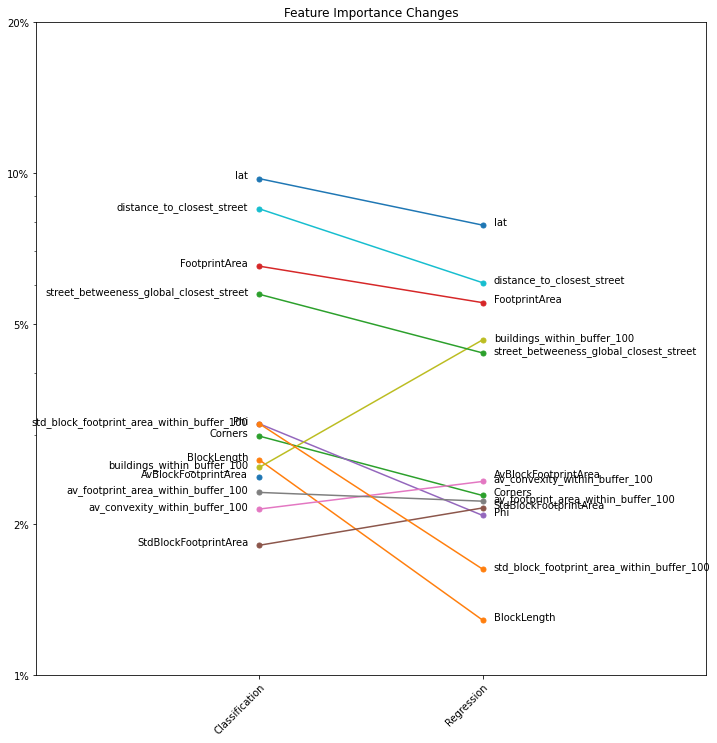

In [ ]:
fts_importance_reg = pd.read_csv('../feature-importance-regression-cluster.csv')
fts_importance_class = pd.read_csv('../feature-importance-regression-cluster-gpu.csv')
fts_importance_reg_sig = fts_importance_reg[fts_importance_reg['normalized_importance'] > 0.01]
fts_importance_class_sig = fts_importance_class[fts_importance_class['normalized_importance'] > 0.01]
print(f'{len(fts_importance_reg_sig)} of {len(fts_importance_reg)} features are significant for regression.')
print(f'{len(fts_importance_class_sig)} of {len(fts_importance_class)} features are significant for classification.')
print(f'{len(set(fts_importance_class_sig["feature"]).intersection(fts_importance_reg_sig["feature"])) / len(fts_importance_reg):.2f} of features are significant for both regression and classification.')
print(f'{len(set(fts_importance_class_sig["feature"]).intersection(fts_importance_reg_sig["feature"])) / len(set(fts_importance_class_sig["feature"]).union(fts_importance_reg_sig["feature"]))} of the significant features are significant for both regression and classification.')
# (fts_importance_reg_sig.set_index('feature') - fts_importance_class_sig.set_index('feature')).reset_index()
dfs = [fts_importance_class_sig, fts_importance_reg_sig]
top_10_features = set().union(*[df[:10]['feature'].values for df in dfs])
visualizations.slope_chart(dfs, labels=['Classification', 'Regression'], feature_selection=top_10_features)

In [68]:
%matplotlib qt
with visualizations.SubplotManager() as ax:
    sa = pd.read_csv('../results/spatial-autocorrelation-band-FRA.csv')
    sns.lineplot(data=sa, x='distance', y='age', ci='sd', hue='country', ax=ax)
    # ax.set(xscale='log')
    ax.legend_.set_title(None)
    ax.set_title('Spatial autocorrelation over distance')
    ax.set_ylabel("Moran's I")
    ax.set_xlabel('distance [m]')
    plt.savefig('../figures/spatial-autocorrelation-age.svg')

In [66]:

# for country, df_path in {'ESP': ESP_DATA_PATH}.items():
df = df_nl_pre
cities = df['city'].value_counts().between(5000, 10000)
cities = list(cities[cities].index)[:4]
print(cities)
df = df[df['city'].isin(cities)]
aux_vars_geo = geometry.to_gdf(df[['id', 'geometry', 'neighborhood', 'sbb', 'city', 'country', 'height', 'age', 'FootprintArea', 'Perimeter']])
# aux_vars_geo.dropna(subset=['id', 'age', 'height', 'FootprintArea', 'Perimeter'], inplace=True)
aux_vars_geo.dropna(subset=['id', 'age'], inplace=True)
# results = aux_vars_geo.groupby('city').apply(lambda x: spatial_autocorrelation.plot_correlogram_over_distance(x, attributes=['age', 'height', 'FootprintArea', 'Perimeter']))
results = aux_vars_geo.groupby('city').apply(lambda x: spatial_autocorrelation.plot_correlogram_over_distance(x, attributes=['age'], distances=[10, 25, 50, 100, 250, 500, 750, 1000]))
results.to_csv('../results/spatial-autocorrelation-band.csv', index=True)
results

2022-08-06 15:44:37,684 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.


['Staphorst', 'Bunschoten', 'Zijpe', 'Beuningen']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

In [19]:
cities = df_nl_pre['city'].value_counts().between(100, 1000)

cities[cities].index
df_nl_pre['city'].value_counts()
# a[a < 1000]


Amsterdam              131694
Apeldoorn              102134
Woerden                 30175
Dronten                 22086
Alphen aan den Rijn     20504
De Ronde Venen          20314
Veere                   19276
Borger-Odoorn           19200
Voorst                  18996
Deurne                  18236
Tytsjerksteradiel       18180
Dinkelland              18168
Weststellingwerf        17436
IJsselstein             15495
Vlissingen              15185
Brunssum                14132
Geertruidenberg         12215
Bloemendaal             11526
Sint-Oedenrode          11262
Binnenmaas              11236
Buren                   10938
Groesbeek               10643
Goedereede              10413
Staphorst                9458
Bunschoten               8915
Zijpe                    7508
Beuningen                7258
Brielle                  7011
Het Bildt                6573
Drimmelen                6505
Rijnwaarden              6330
Veenendaal               5999
Roggel en Neer           5542
Blaricum  

In [14]:
aux_vars_geo = geometry.to_gdf(df_nl_pre[['geometry', 'neighborhood', 'sbb', 'city', 'country', 'height', 'age', 'FootprintArea']])
aux_vars_geo.dropna(subset=['age', 'height', 'FootprintArea'], inplace=True)
aux_vars_geo = aux_vars_geo[aux_vars_geo['city'].isin(['Drechterland', 'Bathmen'])]
aux_vars_geo.groupby('city').apply(lambda x: spatial_autocorrelation.plot_correlogram_over_distance(x, attributes=['age', 'height', 'FootprintArea'], distances=[10, 25]))


2022-08-06 11:32:52,405 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


age    height  FootprintArea
city                                              
Bathmen      10  0.487978  1.186010       0.330211
             25  0.562608  0.100382       0.124832
Drechterland 10  0.466180  0.369090       0.117502
             25  0.458970  0.090431       0.064787

In [94]:
predictor = regressor_fts_importance_fr
# y = predictor.y_test.rename(columns={'age': 'y_test'})
aux_vars = pd.concat([predictor.aux_vars_test, predictor.y_test], axis=1, join="inner")
aux_vars = aux_vars[aux_vars['city'] == 'Toulouse']

# aux_vars_geo = geometry.lat_lon_to_gdf(aux_vars[['lat', 'lon', 'neighborhood', 'sbb', 'city', 'country', 'height', 'age']])
aux_vars_geo = geometry.to_gdf(aux_vars[['geometry', 'neighborhood', 'sbb', 'city', 'country', 'height', 'age']])
aux_vars_geo.dropna(subset=['age', 'height'], inplace=True)
aux_vars_geo
spatial_autocorrelation.plot_correlogram_over_distance(aux_vars_geo, attributes=['age', 'height'], distances=[10, 25, 50])
# spatial_autocorrelation.plot_correlogram_over_distance()

2022-08-05 20:48:36,082 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,height
10,0.590248,0.317733
25,0.506469,0.439570
50,0.457080,0.475788


### Hyperparameter tuning - local test run

In [5]:
df_fr_sample['country'] = 'France'
df_nl_sample['country'] = 'Netherlands'
predictor = AgeClassifier(
    model=XGBClassifier(tree_method='hist', n_jobs=-1),
    df=df_fr_sample,
    # test_set=df_fr_sample,
    # test_training_split=split_80_20,
    cross_validation_split=cross_validation,
    # hyperparameter_tuning_only=True,
    # hyperparameter_tuning=True,
    early_stopping=True,
    # hyperparameters=hyperparameters,
    preprocessing_stages=[remove_outliers],
    bins=dataset.TABULA_AGE_BINS['france'],
    mitigate_class_imbalance=True,
)
predictor.print_model_error()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-06-28 15:58:45,725 | INFO : Generated bins: [0, 1915, 1949, 1968, 1975, 1982, 1990, 2000, 2006, 2013, 2051]
2022-06-28 15:58:45,726 | INFO : Generated bins with the following labels: ['<1915', '1915-1948', '1949-1967', '1968-1974', '1975-1981', '1982-1989', '1990-1999', '2000-2005', '2006-2012', '2013-2050']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Classification report:
               precision    recall  f1-score  support
<1915          0.333333  0.311765  0.322188      170
1915-1948      0.549533  0.597561  0.572541      492
1949-1967      0.507853  0.565049  0.534926      515
1968-1974      0.309783  0.234568  0.266979      243
1975-1981      0.513619  0.534413  0.523810      494
1982-1989      0.524079  0.506849  0.515320      365
1990-1999      0.488055  0.451104  0.468852      317
2000-2005      0.445455  0.471154  0.457944      208
2006-2012      0.357895  0.363636  0.360743      187
2013-2050      0.584906  0.373494  0.455882       83
accuracy       0.482759  0.482759  0.482759        0
macro avg      0.461451  0.440959  0.447919     3074
weighted avg   0.478763  0.482759  0.479133     3074
Cohen’s kappa: 0.4081
Matthews correlation coefficient (MCC): 0.4084
R2: 0.3780
MAPE: 0.4327


In [8]:
predictor.error()


2022-06-28 15:59:53,147 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 15:59:53,171 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 15:59:53,189 | INFO : R2: 0.3780
2022-06-28 15:59:53,201 | INFO : MAPE: 0.4327
2022-06-28 15:59:53,230 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 15:59:53,236 | ERROR : Failed to calculate energy error: cannot set a frame with no defined index and a scalar
2022-06-28 15:59:53,285 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 15:59:53,314 | ERROR : Failed to calculate energy error: cannot set a frame with no defined index and a scalar
2022-06-28 15:59:53,354 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 15:59:53,385 | WARNING : Building type information missing. Considering all buildings as r

,precision,recall,f1-score,support,kappa,mcc,accuracy,energy_r2,energy_mape
<1915,0.333333,0.311765,0.322188,170.0,NaN,NaN,NaN,NaN,NaN
1915-1948,0.549533,0.597561,0.572541,492.0,NaN,NaN,NaN,NaN,NaN
1949-1967,0.507853,0.565049,0.534926,515.0,NaN,NaN,NaN,NaN,NaN
1968-1974,0.309783,0.234568,0.266979,243.0,NaN,NaN,NaN,NaN,NaN
1975-1981,0.513619,0.534413,0.523810,494.0,NaN,NaN,NaN,NaN,NaN
1982-1989,0.524079,0.506849,0.515320,365.0,NaN,NaN,NaN,NaN,NaN
1990-1999,0.488055,0.451104,0.468852,317.0,NaN,NaN,NaN,NaN,NaN
2000-2005,0.445455,0.471154,0.457944,208.0,NaN,NaN,NaN,NaN,NaN
2006-2012,0.357895,0.363636,0.360743,187.0,NaN,NaN,NaN,NaN,NaN
2013-2050,0.584906,0.373494,0.455882,83.0,NaN,NaN,NaN,NaN,NaN


In [9]:
# predictor.rmse(across_folds=True)
predictor.eval_metrics()
# predictor.rmse()
# residuals = predictor.individual_prediction_error()['error'].abs()
# np.histogram(residuals, bins=[0, 5, 10, 20, np.inf])[0] / len(residuals)


2022-06-28 16:18:40,823 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 16:18:40,844 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 16:18:40,854 | INFO : R2: 0.3780
2022-06-28 16:18:40,855 | INFO : MAPE: 0.4327
2022-06-28 16:18:40,868 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 16:18:40,869 | ERROR : Failed to calculate energy error: cannot set a frame with no defined index and a scalar
2022-06-28 16:18:40,881 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 16:18:40,882 | ERROR : Failed to calculate energy error: cannot set a frame with no defined index and a scalar
2022-06-28 16:18:40,907 | WARNING : Building type information missing. Considering all buildings as residential.
2022-06-28 16:18:40,934 | WARNING : Building type information missing. Considering all buildings as r

,precision,recall,f1-score,support,kappa,mcc,accuracy,energy_r2,energy_mape
<1915,0.333333,0.311765,0.322188,170.0,NaN,NaN,NaN,NaN,NaN
1915-1948,0.549533,0.597561,0.572541,492.0,NaN,NaN,NaN,NaN,NaN
1949-1967,0.507853,0.565049,0.534926,515.0,NaN,NaN,NaN,NaN,NaN
1968-1974,0.309783,0.234568,0.266979,243.0,NaN,NaN,NaN,NaN,NaN
1975-1981,0.513619,0.534413,0.523810,494.0,NaN,NaN,NaN,NaN,NaN
1982-1989,0.524079,0.506849,0.515320,365.0,NaN,NaN,NaN,NaN,NaN
1990-1999,0.488055,0.451104,0.468852,317.0,NaN,NaN,NaN,NaN,NaN
2000-2005,0.445455,0.471154,0.457944,208.0,NaN,NaN,NaN,NaN,NaN
2006-2012,0.357895,0.363636,0.360743,187.0,NaN,NaN,NaN,NaN,NaN
2013-2050,0.584906,0.373494,0.455882,83.0,NaN,NaN,NaN,NaN,NaN


### Hyperparameter tuning - large-scale results

In [624]:
tuning_results = os.path.join('../hyperparameter-tuning-results-20220730-00-59-29.csv')
results = pd.read_csv(tuning_results, sep='\t').sort_values(by='param_max_depth')
results.sort_values(by='rank_test_score', ascending=True)[['mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',  'param_colsample_bytree', 'param_colsample_bylevel']].head(30)


,mean_test_score,std_test_score,mean_train_score,mean_fit_time,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,param_colsample_bylevel
20,0.815052,0.010096,0.999442,44.528760,800,12,0.025,0.3,0.7
6,0.426461,0.006985,0.845973,3.892007,500,7,0.050,0.5,0.5
79,0.453990,0.010732,0.970382,34.947673,900,10,0.025,0.7,0.7
57,0.453582,0.010630,0.976138,41.552435,700,11,0.025,0.7,0.7
120,0.812194,0.013511,0.999468,45.108047,800,12,0.025,0.3,0.7
117,0.818274,0.007815,0.997005,27.323182,700,11,0.025,0.7,0.7
84,0.432648,0.016297,0.942675,13.140939,1000,8,0.025,0.7,0.9
100,0.817208,0.007655,0.999240,47.867464,800,12,0.025,0.3,0.7
60,0.453670,0.011622,0.993961,71.353427,800,12,0.025,0.3,0.7
16,0.421583,0.005526,0.999723,63.789768,700,13,0.050,0.5,0.9


In [81]:
# tuning_results = os.path.join('hyperparameter-tuning-results.csv')
tuning_results_1 = os.path.join('../hyperparameter-tuning-results-nl-sample-promising.csv')
tuning_results_2 = os.path.join('../hyperparameter-tuning-results-nl-sample-50-small-depth.csv')
tuning_results_3 = os.path.join('../results/hyperparameter-tuning-results-nl-sample-50-smaller-space-5fold-random-split.csv')
tuning_results_4 = os.path.join('../results/hyperparameter-tuning-results-nl-sample-50-smaller-space-5fold-city-split.csv')
tuning_results_5 = os.path.join('../results/hyperparameter-tuning-results-full-nl-max-depth-impact.csv')
tuning_results_6 = os.path.join('../results/hyperparameter-tuning-results-nl-sample-10-neighborhood-classification.csv')

# plot performance of distinct hyperparameter
results = pd.read_csv(tuning_results_5, sep='\t').sort_values(by='param_max_depth')
visualizations.plot_hyperparameter_tuning_results(results, 'max_depth', ['score'], include_fit_time=True)
plt.savefig('../figures/hyperparameter-tuning-max-depth.svg')
# results.sort_values(by='rank_test_score', ascending=True)[['mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',  'param_colsample_bytree', 'param_colsample_bylevel']]#.head(30)

# plot mean performance of parameters during random search
# results = pd.concat([pd.read_csv(path, sep='\t').sort_values(by='param_n_estimators') for path in [tuning_results_3, tuning_results_4]], ignore_index=True)
# results = results.sort_values(by='rank_test_score', ascending=True).head(50).groupby('param_n_estimators', as_index=False).mean()
# visualizations.plot_hyperparameter_tuning_results(results, 'n_estimators', ['score'])


# plt.savefig('../figures/hyperparameter-tuning.svg')

### Prediction Examples

In [697]:

predictor = AgePredictor(
    model=XGBRegressor(tree_method='hist', n_jobs=-1),
    df=os.path.join(PROJECT_SRC_PATH, '..', 'data', 'exp', 'df-NLD-exp.pkl'),
    test_training_split=split_80_20,
    # cross_validation_split=city_cross_validation,
    preprocessing_stages=[remove_outliers, preparation.add_residential_type_column],
)

predictor.print_model_error()

2022-07-15 17:32:56,718 | INFO : Dataset length: 176319
2022-07-15 17:32:56,764 | INFO : Dataset allocated memory: 184 MB
2022-07-15 17:32:57,120 | INFO : Dataset standard deviation: 28.072581085899984
2022-07-15 17:32:57,122 | INFO : Dataset mean age: 1974.2587129010487
2022-07-15 17:32:57,123 | INFO : Training dataset length: 141055
2022-07-15 17:32:57,131 | INFO : Test dataset length: 35264
2022-07-15 17:32:57,611 | WARNING : Building type information missing. Considering all buildings as residential.
2022-07-15 17:32:59,292 | WARNING : Building type information missing. Considering all buildings as residential.
2022-07-15 17:33:00,838 | INFO : Test dataset standard deviation after preprocessing: 25.07194896229578
2022-07-15 17:33:00,840 | INFO : Test dataset mean age after preprocessing: 1975.4969008264463
2022-07-15 17:33:00,841 | INFO : Training dataset length after preprocessing: 139362
2022-07-15 17:33:00,842 | INFO : Test dataset length after preprocessing: 34848
pandas.Int64I

MAE: 10.92 y
RMSE: 17.01 y
R2: 0.5396
R2: nan
MAPE: nan


In [701]:
predictor.model.__del__()


AttributeError: 'XGBRegressor' object has no attribute '__del__'

In [176]:

equally_sized_bins = (1900, 2020, 10)

predictor = AgeClassifier(
    model=XGBClassifier(tree_method='hist', n_jobs=-1),
    df_path=os.path.join(PROJECT_SRC_PATH, '..', 'data', 'exp', 'df-FRA-exp.pkl'),
    # test_training_split=split_80_20,
    cross_validation_split=cross_validation,
    preprocessing_stages=[remove_outliers, preparation.add_residential_type_column],
    mitigate_class_imbalance=True,
    bins=dataset.TABULA_AGE_BINS['france'],
)

predictor.print_model_error()

2022-07-07 13:55:31,898 | INFO : Generated bins: [0, 1915, 1949, 1968, 1975, 1982, 1990, 2000, 2006, 2013, 2051]
2022-07-07 13:55:31,899 | INFO : Generated bins with the following labels: ['<1915', '1915-1948', '1949-1967', '1968-1974', '1975-1981', '1982-1989', '1990-1999', '2000-2005', '2006-2012', '2013-2050']
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

Classification report:
               precision    recall  f1-score  support
<1915          0.343567  0.321038  0.331921      732
1915-1948      0.493369  0.532037  0.511974     1748
1949-1967      0.533437  0.558087  0.545483     3073
1968-1974      0.392661  0.412129  0.402160     2259
1975-1981      0.473380  0.507999  0.490079     3063
1982-1989      0.426824  0.430687  0.428747     2431
1990-1999      0.515502  0.476026  0.494978     2899
2000-2005      0.474227  0.435194  0.453873     2114
2006-2012      0.534068  0.523600  0.528782     2500
2013-2050      0.357504  0.287653  0.318797      737
accuracy       0.474810  0.474810  0.474810        0
macro avg      0.454454  0.448445  0.450679    21556
weighted avg   0.474269  0.474810  0.473992    21556
Cohen’s kappa: 0.4065
Matthews correlation coefficient (MCC): 0.4066
R2: 0.1144
MAPE: 0.4566



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
# predictor.classification_report()
predictor.save_model_error()



,precision,recall,f1-score,support,kappa,mcc,accuracy
1900-1909,0.155945,0.314961,0.208605,254.0,NaN,NaN,NaN
1910-1919,0.167610,0.307054,0.216850,482.0,NaN,NaN,NaN
1920-1929,0.211898,0.419283,0.281521,892.0,NaN,NaN,NaN
1930-1939,0.315101,0.473315,0.378333,1424.0,NaN,NaN,NaN
1940-1949,0.277852,0.360000,0.313636,575.0,NaN,NaN,NaN
1950-1959,0.484458,0.536909,0.509337,2032.0,NaN,NaN,NaN
1960-1969,0.650462,0.587059,0.617136,3601.0,NaN,NaN,NaN
1970-1979,0.774424,0.629637,0.694565,5338.0,NaN,NaN,NaN
1980-1989,0.769835,0.612400,0.682151,4484.0,NaN,NaN,NaN
1990-1999,0.699196,0.595232,0.643039,4237.0,NaN,NaN,NaN


### Main experiments - local test run

In [489]:

PROJECT_BIN_PATH = os.path.join(os.path.abspath(''), '..', 'bin')
sys.path.append(PROJECT_BIN_PATH)
import run_experiments as exp

logging.getLogger('prediction').setLevel(logging.WARNING)

method = 'regression'

exp.FRAC = None
# exp.DATA_DIR = os.path.join(PROJECT_BIN_PATH, '..', 'data', 'exp')
# exp.RESULT_DIR = os.path.join(PROJECT_BIN_PATH, '..', 'data', 'exp', 'results')
exp.XGBOOST_PARAMS = {'tree_method': 'hist'}
exp.HYPERPARAMETERS = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.5,
}

# exp.compare_energy_error()
exp.compare_countries(method)
# exp.generalize_across_countries(method)
# exp.evaluate_impact_of_additional_data(method, across_cities=True)
# exp.evaluate_impact_of_spatial_distance_on_generalization(method)
# exp.evaluate_impact_of_additional_data(method, across_cities=True, include_data_from_other_countries=True)


[autoreload of prediction_age failed: Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/p

In [20]:
df_nl_sample['height'].value_counts()

2.4849    15
2.5366    15
2.6051    14
2.5943    13
2.4877    13
          ..
4.7236     1
7.0996     1
7.8252     1
7.8522     1
3.6177     1
Name: height, Length: 130494, dtype: int64

### Main experiment - large-scale results

In [130]:
reg_results = pd.read_csv('../results/error-comparison-regression.csv')[['name', 'MAE', 'RMSE', 'R2']]
# r[['MAE', 'RMSE']] = r[['MAE', 'RMSE']].round(decimals=2)
# r['R2'] = r['R2'].round(decimals=4)
# r
reg_results

reg_results['Country'] = reg_results['name'].str.split('_').str[0]
reg_results['Model'] = reg_results['name'].str.split('_').str[1]
reg_results = reg_results.set_index(['Country', 'Model'])
reg_results['R2'] = reg_results['R2'].round(2)
reg_results[['MAE', 'RMSE']] = reg_results[['MAE', 'RMSE']].round(1)
reg_results.sort_index(level=1)[['MAE', 'RMSE', 'R2']].to_latex('reg-results.csv')
reg_results

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,,name,MAE,RMSE,R2
Country,Model,,,,
Spain,neighborhood-cv,Spain_neighborhood-cv,19.3,26.3,0.34
All,neighborhood-cv,All_neighborhood-cv,17.8,24.3,0.38
France,neighborhood-cv,France_neighborhood-cv,18.0,24.4,0.41
Spain,random-cv,Spain_random-cv,17.5,24.5,0.43
Netherlands,neighborhood-cv,Netherlands_neighborhood-cv,14.3,19.9,0.44
All,random-cv,All_random-cv,16.2,22.9,0.45
France,random-cv,France_random-cv,16.8,23.4,0.46
Netherlands,random-cv,Netherlands_random-cv,10.1,16.1,0.63
Spain,city-cv,Spain_city-cv,19.9,26.9,0.32


In [101]:
pd.read_csv('../results/error-comparison-classification.csv').round(decimals=2).sort_values(by='MCC')

,name,MCC,MCC_std,F1,F1_std,Recall_1900-1909,Recall_1910-1919,Recall_1920-1929,Recall_1930-1939,Recall_1940-1949,Recall_1950-1959,Recall_1960-1969,Recall_1970-1979,Recall_1980-1989,Recall_1990-1999,Recall_2000-2009,Recall_2010-2019,MCC_seed_0
0,Spain_city-cv,0.14,0.0,0.19,0.0,0.44,0.01,0.08,0.10,0.16,0.12,0.24,0.19,0.16,0.17,0.42,0.27,0.14
9,Spain_neighborhood-cv,0.18,0.0,0.23,0.0,0.50,0.06,0.14,0.14,0.20,0.18,0.27,0.22,0.20,0.20,0.41,0.31,0.18
1,France_city-cv,0.24,0.0,0.27,0.0,0.61,0.03,0.30,0.23,0.01,0.27,0.28,0.35,0.30,0.21,0.34,0.42,0.24
2,Spain_block-cv,0.26,0.0,0.31,0.0,0.64,0.24,0.35,0.32,0.34,0.31,0.35,0.28,0.25,0.24,0.40,0.35,0.26
10,France_neighborhood-cv,0.26,0.0,0.28,0.0,0.62,0.05,0.35,0.26,0.02,0.30,0.29,0.36,0.31,0.23,0.35,0.43,0.26
3,Netherlands_city-cv,0.28,0.0,0.29,0.0,0.20,0.06,0.16,0.37,0.01,0.31,0.46,0.47,0.41,0.33,0.36,0.37,0.28
4,France_block-cv,0.30,0.0,0.33,0.0,0.61,0.12,0.39,0.29,0.09,0.37,0.34,0.40,0.35,0.27,0.39,0.45,0.30
11,Netherlands_neighborhood-cv,0.33,0.0,0.33,0.0,0.32,0.10,0.26,0.42,0.03,0.35,0.49,0.49,0.45,0.38,0.38,0.41,0.33
5,Spain_random-cv,0.39,0.0,0.44,0.0,0.71,0.47,0.52,0.49,0.49,0.47,0.48,0.41,0.38,0.36,0.46,0.50,0.39
6,France_random-cv,0.42,0.0,0.45,0.0,0.64,0.30,0.49,0.42,0.26,0.50,0.46,0.50,0.47,0.41,0.48,0.54,0.42


In [1303]:
reg_mcc = pd.read_csv('../results/regression-country-comparison-mcc.csv').round(decimals=2).sort_values(by='MCC_10')
reg_mcc['Country'] = reg_mcc['name'].str.split('_').str[0]
reg_mcc['Model'] = reg_mcc['name'].str.split('_').str[1]
reg_mcc['Model'] = reg_mcc['Model'].str.replace('-', ' ').str.capitalize()
reg_mcc.rename(columns={'MCC_5': '5 years', 'MCC_10': '10 years', 'MCC_20': '20 years'}, inplace=True)
reg_mcc = reg_mcc[['Country', 'Model', '5 years', '10 years', '20 years']]
reg_mcc.to_csv('../results/regression-country-comparison-mcc-table.csv', index=False)


In [1304]:

for country, predictor in {'FRA': regressor_fts_importance_fr, 'ESP': regressor_fts_importance_es, 'NLD': regressor_fts_importance_nl}.items():
    for bin_size in [5, 10, 20]:
        bins = utils.generate_bins((1900, 2020, bin_size))
        mcc = predictor.mcc(bins)
        print(f'MCC for {country} with bin size {bin_size}: {mcc}')

# Results
# France,Neighborhood cv,0.06,0.12,0.21
# Spain,Neighborhood cv,0.04,0.09,0.16
# Netherlands,Neighborhood cv,0.09,0.18,0.28

id
v0.1-FRA.10.9.2.2_1-1580    11
v0.1-FRA.12.2.3.3_1-4597     0
v0.1-FRA.9.5.2.9_1-9883     14
v0.1-FRA.3.4.1.1_1-6409     12
v0.1-FRA.4.4.1.3_1-12521     0
                            ..
v0.1-FRA.6.7.2.4_1-4027      6
v0.1-FRA.12.2.3.5_1-937     22
v0.1-FRA.13.6.2.3_1-6862     6
v0.1-FRA.1.9.1.6_1-11351    16
v0.1-FRA.10.7.4.3_1-6717    13
Length: 9596614, dtype: int8
id
v0.1-FRA.10.9.2.2_1-1580    15
v0.1-FRA.12.2.3.3_1-4597     3
v0.1-FRA.9.5.2.9_1-9883     16
v0.1-FRA.3.4.1.1_1-6409     14
v0.1-FRA.4.4.1.3_1-12521     6
                            ..
v0.1-FRA.6.7.2.4_1-4027      8
v0.1-FRA.12.2.3.5_1-937     18
v0.1-FRA.13.6.2.3_1-6862     9
v0.1-FRA.1.9.1.6_1-11351    13
v0.1-FRA.10.7.4.3_1-6717    11
Length: 9596614, dtype: int8
9596614
9596614
MCC for FRA with bin size 5: 0.058326614273458054
id
v0.1-FRA.10.9.2.2_1-1580     5
v0.1-FRA.12.2.3.3_1-4597     0
v0.1-FRA.9.5.2.9_1-9883      7
v0.1-FRA.3.4.1.1_1-6409      6
v0.1-FRA.4.4.1.3_1-12521     0
                            ..

In [147]:
reg_results_mcc = pd.read_csv('../results/regression-country-comparison-mcc-table.csv')
class_results_5 = pd.read_csv('../results/error-comparison-classification-5-year-bins.csv').round(decimals=2).sort_values(by='MCC')
class_results_10 = pd.read_csv('../results/error-comparison-classification.csv').round(decimals=2).sort_values(by='MCC')
class_results_20 = pd.read_csv('../results/error-comparison-classification-20-year-bins.csv').round(decimals=2).sort_values(by='MCC')
class_results_5['Bin size'] = '5 years'
class_results_10['Bin size'] = '10 years'
class_results_20['Bin size'] = '20 years'
class_results = pd.concat([class_results_5, class_results_10, class_results_20], ignore_index=True)
class_results
class_results['Country'] = class_results['name'].str.split('_').str[0]
class_results['Model'] = class_results['name'].str.split('_').str[1]
class_results['Model'] = class_results['Model'].str.replace('-', ' ').str.capitalize()
class_results['Approach'] = 'class'
reg_results_mcc['Approach'] = 'reg'
reg_results_mcc.columns.name = 'Bin size'

# class_results['Recall <1940'] = class_results[['Recall_1900-1909', 'Recall_1910-1919', 'Recall_1920-1929', 'Recall_1930-1939']].mean(axis=1)
# class_results['Recall >2000'] = class_results[['Recall_2000-2009', 'Recall_2010-2019']].mean(axis=1)
# class_results[['Country', 'Model', 'MCC', 'Recall <1940', 'Recall >2000']]

# pivot_table_reg = reg_results_mcc.set_index(['Country', 'Model', 'Approach']).unstack(level=0).swaplevel(0, 1, axis=1).sort_index(axis=1)
# pivot_table_class = class_results.pivot_table(values=['MCC'], index=['Model', 'Approach'], columns=['Country', 'Bin size'], margins=False)
# pivot_table_class.columns = pivot_table_class.columns.droplevel(0) # drop "MCC" multi-index column
# pivot_table = pd.concat([pivot_table_class, pivot_table_reg])

# pivot_table.columns.name = None # drop Country cell
# new_cols = pivot_table.columns.reindex(['Netherlands', 'France', 'Spain'], level=0)
# pivot_table = pivot_table.reindex(columns=new_cols[0])
# new_cols = pivot_table.columns.reindex(['5 years', '10 years', '20 years'], level=1)
# pivot_table = pivot_table.reindex(columns=new_cols[0])
# pivot_table = pivot_table.sort_index(level=0)
# new_cols = pivot_table.index.reindex(['Random cv', 'Block cv', 'Neighborhood cv', 'City cv'], level=0)
# pivot_table = pivot_table.reindex(index=new_cols[0])

# pivot_table.to_latex('../figures/error-classification.tex', index=True, float_format='%.2f', column_format='|l|l|r|r|r|r|r|r|r|r|r|', caption='MCC for classification and discretized regression', label='table:classification-results')
# pivot_table

pivot_table_f1 = class_results.pivot_table(values=['MCC', 'F1'], index=['Bin size', 'Model'], columns=['Country'], margins=False).swaplevel(0, 1, axis=1).sort_index(axis=1)
pivot_table_f1.columns = pivot_table_f1.columns.rename(None, level=0) # drop Country cell

new_cols = pivot_table_f1.columns.reindex(['Netherlands', 'France', 'Spain'], level=0)
pivot_table_f1 = pivot_table_f1.reindex(columns=new_cols[0])
new_cols = pivot_table_f1.columns.reindex(['MCC', 'F1'], level=1)
pivot_table_f1 = pivot_table_f1.reindex(columns=new_cols[0])
new_cols = pivot_table_f1.index.reindex(['5 years', '10 years', '20 years'], level=0)
pivot_table_f1 = pivot_table_f1.reindex(index=new_cols[0])
new_cols = pivot_table_f1.index.reindex(['Random cv', 'Block cv', 'Neighborhood cv', 'City cv'], level=1)
pivot_table_f1 = pivot_table_f1.reindex(index=new_cols[0])
pivot_table_f1.to_latex('../figures/error-classification-f1-mcc.tex', index=True, float_format='%.2f', column_format='|l|l|r|r|r|r|r|r|', caption='Classification error', label='table:classification-results-f1-mcc')
pivot_table_f1

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Netherlands       France       Spain      
                                 MCC    F1    MCC    F1   MCC    F1
Bin size Model                                                     
5 years  Random cv              0.73  0.70   0.37  0.36  0.36  0.37
         Block cv               0.44  0.42   0.22  0.21  0.20  0.22
         Neighborhood cv        0.21  0.21   0.17  0.16  0.13  0.14
         City cv                0.17  0.16   0.15  0.14  0.09  0.10
10 years Random cv              0.75  0.73   0.42  0.45  0.39  0.44
         Block cv               0.52  0.51   0.30  0.33  0.26  0.31
         Neighborhood cv        0.33  0.33   0.26  0.28  0.18  0.23
         City cv                0.28  0.29   0.24  0.27  0.14  0.19
20 years Random cv              0.76  0.77   0.48  0.56  0.45  0.54
         Block cv               0.58  0.62   0.39  0.49  0.35  0.46
         Neighborhood cv        0.44  0.51   0.35  0.45  0.27  0.38
         City cv                0.39  0.46   0.33  0.43  0.23  0.34

In [1318]:
((pivot_table.xs('class', level=1) / pivot_table.xs('reg', level=1))).mean().mean(axis=0, level=1)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


Bin size
5 years     3.660278
10 years    2.211593
20 years    1.698427
dtype: float64

In [1330]:
# oversample(df_nl_sample, None)
# df_nl_sample.select_dtypes(include=['object']).columns.
df_nl_sample['FootprintArea'].value_counts()

121.014082    2
280.555723    2
112.728860    2
83.199405     2
105.341157    1
             ..
10.079536     1
22.731155     1
15.699179     1
65.526033     1
207.892964    1
Name: FootprintArea, Length: 176315, dtype: int64

In [149]:
recall_over_time = class_results.set_index(['Bin size', 'Model', 'Country']).filter(regex='Recall')
recall_over_time.columns = (recall_over_time.columns.str.split('-').str[0].str.split('_').str[1].astype(float) + recall_over_time.columns.str.split('-').str[1].astype(float) + 1) /2
recall_over_time = recall_over_time.transpose().sort_index(axis=1)
recall_grouped = pd.concat([recall_over_time[recall_over_time.index < 1960].mean(), recall_over_time[(recall_over_time.index > 1960) & (recall_over_time.index <= 1990)].mean(), recall_over_time[recall_over_time.index > 1990].mean()], keys=['<1960', '1960-1990', '>1990'], axis=1)
recall_grouped = recall_grouped.unstack(level=2).swaplevel(0, 1, axis=1).sort_index(axis=1)
new_cols = recall_grouped.columns.reindex(['<1960', '1960-1990', '>1990'], level=1)
recall_grouped = recall_grouped.reindex(columns=new_cols[0])
new_cols = recall_grouped.index.reindex(['5 years', '10 years', '20 years'], level=0)
recall_grouped = recall_grouped.reindex(index=new_cols[0])

recall_grouped.columns = recall_grouped.columns.rename(None, level=0) # drop Country cell

recall_grouped = recall_grouped.multiply(100).round(1)
recall_grouped.to_latex('../figures/classification-recall.tex', index=True, float_format='%.2f', caption='Mean classification recall before 1960, after 1990, and in between', label='table:classification-recall')

recall_grouped

# # performance difference between periods
# recall_grouped.groupby(level=0, axis=1).apply(lambda x: x.droplevel(0, axis=1)['<1960'] - x.droplevel(0, axis=1)[['1960-1990', '>1990']].mean(axis=1))



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


France                 Netherlands                  \
                          <1960 1960-1990 >1990       <1960 1960-1990 >1990   
Bin size Model                                                                
5 years  Block cv          19.3      24.7  22.7        34.7      52.8  43.2   
         City cv           13.1      17.7  17.0         9.7      28.0  19.0   
         Neighborhood cv   14.8      18.7  18.0        15.1      30.3  23.7   
         Random cv         33.8      40.0  37.2        67.7      79.3  69.8   
10 years Block cv          31.2      36.3  37.0        43.8      63.3  53.3   
         City cv           24.2      31.0  32.3        18.5      44.7  35.3   
         Neighborhood cv   26.7      32.0  33.7        24.7      47.7  39.0   
         Random cv         43.5      47.7  47.7        71.7      81.3  73.3   
20 years Block cv          50.0      48.5  56.0        57.7      70.5  66.0   
         City cv           42.3      45.0  52.0        35.0      58.0  54.0   
         Neighborhood cv   45.3      45.5  53.0        43.3      62.0  55.0   
         Random cv         59.7      55.5  62.0        78.7      82.5  79.0   

                         Spain                  
                         <1960 1960-1990 >1990  
Bin size Model                                  
5 years  Block cv         26.3      20.7  21.0  
         City cv           7.7      10.8  15.5  
         Neighborhood cv  11.8      13.8  17.8  
         Random cv        43.8      36.7  37.7  
10 years Block cv         36.7      29.3  33.0  
         City cv          15.2      19.7  28.7  
         Neighborhood cv  20.3      23.0  30.7  
         Random cv        52.5      42.3  44.0  
20 years Block cv         51.7      39.5  58.0  
         City cv          30.3      31.5  59.0  
         Neighborhood cv  35.7      35.0  59.0  
         Random cv        63.3      49.0  62.0

In [1218]:
recall_over_time = class_results.set_index(['Bin size', 'Model', 'Country']).filter(regex='Recall')
recall_over_time.columns = (recall_over_time.columns.str.split('-').str[0].str.split('_').str[1].astype(float) + recall_over_time.columns.str.split('-').str[1].astype(float) + 1) /2
recall_over_time = recall_over_time.transpose()#.swaplevel(0,1, axis=1)

new_cols = recall_over_time.columns.reindex(['5 years', '10 years', '20 years'], level=0)
recall_over_time = recall_over_time.reindex(columns=new_cols[0])

with visualizations.SubplotManager(nrows=3) as axis:
    colors = ['darksalmon', 'plum', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)

    for idx, (bin_size, group) in enumerate(recall_over_time.groupby('Bin size', axis=1, sort=False)):
        group.droplevel(0, axis=1).plot(y='Neighborhood cv', kind='line', xlabel=None, ylabel=f'Recall\n({bin_size})', ylim=(0, 0.65), xlim=(1895, 2025), xticks=[1900, 1920, 1940, 1960, 1980, 2000, 2020], cmap=cmap, legend=False, ax=axis[idx])
        axis[idx].spines['right'].set_visible(False)
        axis[idx].spines['top'].set_visible(False)
        # axis[idx].set_xticks([])

    pos1 = axis[0].get_position()
    pos2 = axis[1].get_position()
    pos3 = axis[2].get_position()
    axis[0].set_position(pos2)
    axis[1].set_position(pos3)
    axis[2].set_position(pos1)

    axis[2].legend(loc='lower center', bbox_to_anchor=(0.5, 1), fancybox=True, ncol=3, title=None)
    axis[1].set_xlabel('Construction period')
    axis[1].set_xticks([1900, 1920, 1940, 1960, 1980, 2000, 2020])

plt.savefig('../figures/recall-classification.svg')

In [71]:
pd.read_csv('../results/error-generalization-cross-country-trained-on-single-country.csv')


,Unnamed: 0,R2,MAE,RMSE,Kurtosis,Skew,energy_r2,energy_mape,within_5_years,within_10_years,within_20_years
0,total,-0.092903,25.852499,31.832251,742.721340,2.682522,NaN,NaN,0.117236,0.231709,0.444437
1,spain,0.076176,22.641857,28.662061,0.220374,-0.583579,NaN,NaN,0.146819,0.287073,0.526781
2,netherlands,-0.113085,27.921449,33.544307,0.019312,-0.515011,NaN,NaN,0.104943,0.205547,0.393390
3,france,-0.182905,26.766411,32.727943,1454.484728,5.591008,NaN,NaN,0.106102,0.212196,0.420457


In [34]:
pd.read_csv('../results/error-generalization-across-countries-jul-5.csv')


,Unnamed: 0,R2,MAE,RMSE,Kurtosis,Skew,energy_r2,energy_mape,within_5_years,within_10_years,within_20_years
0,total,-0.023434,25.340801,31.227857,1041.308745,3.780116,NaN,NaN,0.121550,0.238760,0.450863
1,france,0.134576,23.833616,29.507719,-0.095433,-0.523080,NaN,NaN,0.140350,0.270125,0.485209
2,spain,-0.145393,28.582238,34.732670,2597.248004,10.586690,NaN,NaN,0.093458,0.187647,0.377417
3,netherlands,-0.178234,23.376912,28.806080,0.483067,-0.526024,NaN,NaN,0.128450,0.256328,0.495018


invalid value encountered in true_divide


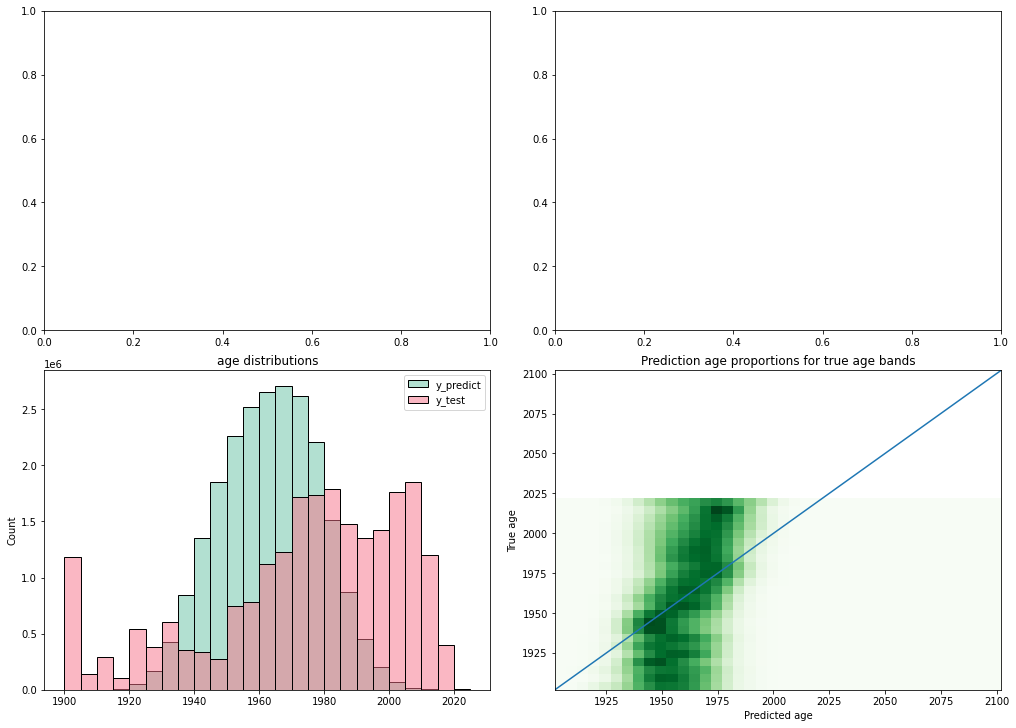

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

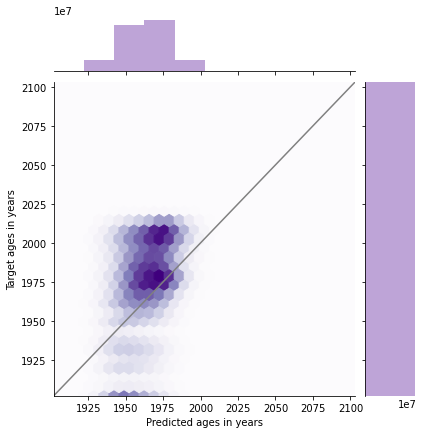

In [49]:
# gen_pred = pd.read_pickle('../predictions-23818532-20220705-15-09-45-exp.pkl')
pred = gen_pred.iloc[:, 0].to_frame('age')
test = gen_pred.iloc[:, 1].to_frame('age')
bins = list(range(1900, 2025 + 1))[0::5]
# gen_pred.columns = ['predict', 'test']

_, axis = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
visualizations.plot_histogram(test, pred, bins=bins, ax=axis[1, 0])
visualizations.plot_relative_grid(test, pred, ax=axis[1, 1])
plt.show()
visualizations.plot_grid(test, pred)


In [9]:
pd.read_csv('../error-class-energy-error-23811418-20220704-02-26-47.csv')

,precision,recall,f1-score,support,kappa,mcc,accuracy,energy_r2,energy_mape
0,0.336218,0.618282,0.435574,865473.0,NaN,NaN,NaN,NaN,NaN
1,0.451313,0.440838,0.446014,1003939.0,NaN,NaN,NaN,NaN,NaN
2,0.423944,0.421660,0.422799,1311321.0,NaN,NaN,NaN,NaN,NaN
3,0.292099,0.245631,0.266857,967631.0,NaN,NaN,NaN,NaN,NaN
4,0.334375,0.295591,0.313789,1206461.0,NaN,NaN,NaN,NaN,NaN
5,0.313218,0.248659,0.277230,1118813.0,NaN,NaN,NaN,NaN,NaN
6,0.275284,0.224501,0.247313,1039290.0,NaN,NaN,NaN,NaN,NaN
7,0.258885,0.229602,0.243366,797825.0,NaN,NaN,NaN,NaN,NaN
8,0.316537,0.267379,0.289889,954765.0,NaN,NaN,NaN,NaN,NaN
9,0.184614,0.329034,0.236521,331096.0,NaN,NaN,NaN,NaN,NaN


In [116]:
pd.read_csv('../results/results-classification-23785961-20220622-05-38-45.csv')

,name,MCC,F1,Recall_1900-1904,Recall_1905-1909,Recall_1910-1914,Recall_1915-1919,Recall_1920-1924,Recall_1925-1929,Recall_1930-1934,...,Recall_1970-1974,Recall_1975-1979,Recall_1980-1984,Recall_1985-1989,Recall_1990-1994,Recall_1995-1999,Recall_2000-2004,Recall_2005-2009,Recall_2010-2014,Recall_2015-2019
0,Spain_city-cv,0.079885,0.098834,0.325625,0.160035,0.066501,0.118466,0.151644,0.089388,0.123557,...,0.058642,0.124095,0.063851,0.093923,0.054136,0.069356,0.077834,0.167138,0.207791,0.310153
1,France_city-cv,0.122474,0.141126,0.382910,0.146016,0.107226,0.050009,0.278541,0.115447,0.115364,...,0.132085,0.193401,0.128001,0.157136,0.092925,0.136392,0.132738,0.162461,0.212439,0.298990
2,Spain_random-cv,0.157520,0.180753,0.469290,0.460736,0.321576,0.437423,0.347301,0.339065,0.275482,...,0.107495,0.177722,0.102893,0.157204,0.100409,0.101137,0.102948,0.196309,0.246137,0.399632
3,France_random-cv,0.161607,0.182643,0.407974,0.224531,0.174827,0.158829,0.333214,0.177674,0.164008,...,0.170551,0.226703,0.155427,0.191672,0.123815,0.166537,0.153895,0.174960,0.228058,0.334042
4,Netherlands_city-cv,0.161633,0.165653,0.282331,0.171944,0.162001,0.068045,0.062405,0.110113,0.092211,...,0.303125,0.261436,0.228702,0.194522,0.168878,0.187392,0.150508,0.151107,0.219330,0.337367
5,Netherlands_random-cv,0.414989,0.400669,0.542977,0.491024,0.385125,0.480158,0.333041,0.386558,0.344099,...,0.483511,0.464229,0.494593,0.428917,0.438422,0.455592,0.416631,0.398452,0.384535,0.612028


In [115]:
pd.read_csv('../results/results-regression-23785966-20220622-01-48-08.csv')

,name,R2,MAE,RMSE
0,Spain_city-cv,0.305322,20.297378,27.362372
1,Spain_random-cv,0.339042,19.682322,26.690025
2,Netherlands_city-cv,0.344058,15.875018,21.444882
3,France_city-cv,0.371999,19.101783,25.396953
4,France_random-cv,0.385177,18.827284,25.129069
5,Netherlands_random-cv,0.451107,14.061322,19.617100


['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


In [140]:
regressor_sd = AgePredictor.load('../model-spatial-distance-23839686-20220709-04-14-17-exp_125-Flevoland__0_.pkl')

In [141]:
pd.concat([regressor_sd.y_predict, regressor_sd.y_test], axis=1).sort_index()
regressor_sd.y_test.describe()

,age
count,174893.000000
mean,1988.629139
std,13.466541
min,1916.000000
25%,1981.000000
50%,1989.000000
75%,1998.000000
max,2016.000000


In [63]:
resample_results = pd.read_csv('../results/prelim-comparison-resampling-strategies.csv').sort_values(by='MCC').round(3)
resample_results['Country'] = resample_results['name'].str.split('_').str[1]
resample_results['Strategy'] = resample_results['name'].str.split('_').str[0]
resample_results['Recall <1960'] = resample_results[['Recall_1900-1909', 'Recall_1910-1919', 'Recall_1920-1929', 'Recall_1930-1939', 'Recall_1940-1949', 'Recall_1950-1959']].mean(axis=1)
resample_results['Recall >1990'] = resample_results[['Recall_1990-1999', 'Recall_2000-2009', 'Recall_2010-2019']].mean(axis=1)
resample_results[['Strategy', 'MCC', 'F1', 'Recall <1960', 'Recall >1990']].to_latex('../figures/resampling-strategies.tex', index=False, float_format='%.3f', caption='Comparison of resampling strategies for imbalanced classification', label='table:resampling')
resample_results[['Strategy', 'MCC', 'F1', 'Recall <1960', 'Recall >1990']]


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,Strategy,MCC,F1,Recall <1960,Recall >1990
0,undersampling,0.653,0.614,0.591500,0.663000
1,oversampling,0.714,0.664,0.609667,0.719000
2,SMOTE,0.715,0.665,0.582333,0.726000
3,ADASYN,0.715,0.663,0.576500,0.733667
5,baseline,0.715,0.667,0.547667,0.726000
4,sample weights,0.716,0.667,0.615500,0.722333


#### Model selection

In [59]:
model_selection = pd.read_csv('../results/model-selection.csv').sort_values(by='R2').round(3)
model_selection['Model'] = model_selection['name'].str.split('_').str[1]
model_selection.loc[model_selection['Model'] == 'RandomForest', 'Fit time [s]'] = '722'
model_selection.loc[model_selection['Model'] == 'XGboost', 'Fit time [s]'] = '281'
model_selection.loc[model_selection['Model'] == 'AdaBoost', 'Fit time [s]'] = '409'
model_selection = model_selection[['Model', 'MAE', 'RMSE', 'R2', 'Fit time [s]']]
model_selection.to_latex('../figures/model-selection.tex', index=False, float_format='%.3f', caption='Model comparison between Random Forest, XGBoost, and AdaBoost for regression', label='table:model-selection')
model_selection


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,Model,MAE,RMSE,R2,Fit time [s]
0,AdaBoost,18.512,24.001,0.211,409
2,RandomForest,9.160,17.039,0.602,722
1,XGboost,8.925,16.657,0.620,281


## Figures

### Figure: Descriptive statistics

In [683]:
# predictors = {'Netherlands': regressor_fts_importance_nl, 'Spain': regressor_fts_importance_es, 'France': regressor_fts_importance_fr, 'All': regressor_country_cv}

# for country, predictor in predictors.items():
#     print(predictor.y_test.describe())

# df_countries = []
# for predictor, gadm, gadm_level in [(regressor_fts_importance_fr, gadm_france, 4), (regressor_fts_importance_es, gadm_spain, 4), (regressor_fts_importance_nl, gadm_netherlands, 2)]:
#     df_country = pd.concat([predictor.y_test, predictor.aux_vars_test, predictor.X_test[['FootprintArea']]], axis=1)
#     df_country = df_country.merge(gadm[[f'NAME_{gadm_level}', 'DEGURBA']], right_on=f'NAME_{gadm_level}', left_on='city', how='left').set_index('id')
#     df_countries.append(df_country)

# data = pd.concat(df_countries, axis=0)
# data = harmonize_group_source_types(data)
# data['residential'] = data['type'] == 'residential'
# data.replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)

# data = pd.concat([regressor_country_cv.y_test, regressor_country_cv.aux_vars_test], axis=1)
# gadm = pd.concat([gadm_netherlands, gadm_spain, gadm_france], axis=0)
# # gadm
# bins=[1900, 1944, 1990, 2022]
# # data.groupby('country')['age'].apply(['mean', 'std', 'count', lambda x: np.histogram(x, bins=bins)[0] / len(x)])
# data.groupby('country')['age'].agg(['mean', 'std', 'count', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
# data.groupby(['country', 'DEGURBA'])['age'].agg(['mean', 'std', 'count', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
# data.groupby(['country', 'residential'])['age'].agg(['mean', 'std', 'count', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
# data.groupby('country')['age'].value_counts(bins=bins, normalize=True, sort=False)

blds_per_degurba = data.groupby(['country', 'DEGURBA', 'city'])['age'].count().reset_index().groupby(['country', 'DEGURBA']).mean().rename(columns={'age' :'settlement size'})

age_per_degurba = data.groupby(['country', 'DEGURBA'])['age'].agg(['mean', 'std']).rename(columns={'mean': 'mean age', 'std': 'std age'})
share_per_degurba = data.groupby(['country'])['DEGURBA'].value_counts(normalize=True).rename('share').multiply(100)
age_per_type = data.groupby(['country', 'residential'])['age'].agg(['mean', 'std']).rename(index={True: 'residential', False: 'non-residential'}, level=1).rename(columns={'mean': 'mean age', 'std': 'std age'})
share_per_type = data.groupby(['country'])['residential'].value_counts(normalize=True).rename('share').multiply(100).rename(index={True: 'residential', False: 'non-residential'}, level=1)
type_table = pd.concat([age_per_type, share_per_type], axis=1).sort_index()
degurba_table = pd.concat([share_per_degurba, blds_per_degurba, age_per_degurba], axis=1).sort_index()
table = pd.concat([degurba_table, type_table], axis=0).sort_index()
table.rename(index={1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, level=1, inplace=True)

table.to_latex('../figures/detailed-stats.tex', float_format='%.1f', index=True, multicolumn_format='c', column_format='|l|r|rr|rr|', caption='Settlement and building type statistics of preprocessed dataset', label='table:detailed-stats')

table
# regressor_fts_importance_nl.X_test
# regressor_fts_importance_nl.y_test.hist(bins=[1900, 1944, 1990, 2022])

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


share  settlement size     mean age    std age
country DEGURBA                                                             
ESP     1 (city)          23.352812     14117.019608  1978.569354  27.007953
        2 (town)          39.330234      3819.062992  1981.385893  28.820408
        3 (rural)         37.316954       655.172551  1968.157417  37.455753
        non-residential   21.646957              NaN  1979.015622  32.380960
        residential       78.353043              NaN  1974.621136  32.264286
FRA     1 (city)           7.975371      5433.177419  1959.053926  32.108184
        2 (town)          17.751276      4760.403175  1971.476161  29.627559
        3 (rural)         74.273353      3019.341193  1973.742303  31.871257
        non-residential   17.920877              NaN  1966.543449  34.304319
        residential       82.079123              NaN  1973.144001  31.001249
NLD     1 (city)          43.054494     23800.326531  1970.476185  27.921076
        2 (town)          41.574724      9463.306723  1974.429724  24.577314
        3 (rural)         15.370782      9462.454545  1973.223723  27.151679
        non-residential  100.000000              NaN  1972.504306  26.541734

In [676]:
overview_table = data.groupby(['country'])[['age', 'FootprintArea', 'DEGURBA', 'height', 'residential', 'city']].apply(lambda x: pd.Series({
    'n': int(x['age'].size),
    'mean': x['age'].mean().round(1),
    'std': x['age'].std().round(1),
    'Q1': int(x['age'].quantile(0.25)),
    'Q3': int(x['age'].quantile(0.75)),
    'residential [%]': ((x['residential'].sum() / x['residential'].size) * 100).round(1),
    'footprint area [m2]': x['FootprintArea'].mean().round(1),
    'height [m]': x['height'].mean().round(1),
    # 'DEGURBA': x['DEGURBA'].mean().round(2),
    # **x.groupby(['DEGURBA'])['age'].mean().round(1).to_dict(),
    # **x.groupby(['DEGURBA', 'city'])['age'].count().groupby(['DEGURBA']).mean().astype(int).to_dict(),

})).reset_index()

# overview_table.rename(columns={1.0: 'city size', 2.0: 'town size', 3.0: 'rural size'}, inplace=True)
# overview_table.rename(columns={1.0: 'city mean age', 2.0: 'town size', 3.0: 'rural size'}, inplace=True)
new_level = ['', '', 'Construction year', 'Construction year', 'Construction year', 'Construction year', 'Other properties', 'Other properties', 'Other properties']
overview_table.columns = pd.MultiIndex.from_tuples(zip(new_level, overview_table.columns))

# overview_table.to_latex('../figures/stats.tex', index=False, multicolumn_format='c', column_format='|l|r|rrrr|rrrr|', caption='Summary statistics of preprocessed dataset', label='table:stats')
overview_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


age                       other properties  \
  country          n    mean   std      Q1      Q3  residential [%]   
0     ESP  7994380.0  1975.6  32.3  1960.0  2001.0             78.4   
1     FRA  9644500.0  1972.0  31.7  1958.0  1997.0             82.1   
2     NLD  5452189.0  1972.5  26.5  1960.0  1992.0              0.0   

                                          
  footprint area [m2] height [m] DEGURBA  
0               184.6        5.1    2.14  
1               131.2        5.0    2.66  
2               122.9        5.6    1.72

In [677]:
overview_table.columns

MultiIndex([(                '',             'country'),
            (                '',                   'n'),
            (             'age',                'mean'),
            (             'age',                 'std'),
            (             'age',                  'Q1'),
            (             'age',                  'Q3'),
            ('other properties',     'residential [%]'),
            ('other properties', 'footprint area [m2]'),
            ('other properties',          'height [m]'),
            ('other properties',             'DEGURBA')],
           )

In [665]:
overview_table

age                                 \
  (nan, country)   (nan, n) (age, mean) (age, std) (age, Q1) (age, Q3)   
0            ESP  7994380.0      1975.6       32.3    1960.0    2001.0   
1            FRA  9644500.0      1972.0       31.7    1958.0    1997.0   
2            NLD  5452189.0      1972.5       26.5    1960.0    1992.0   

                                                                       \
  (nan, residential [%]) (nan, footprint area [m2]) (nan, height [m])   
0                   78.4                      184.6               5.1   
1                   82.1                      131.2               5.0   
2                    0.0                      122.9               5.6   

                  
  (nan, DEGURBA)  
0           2.14  
1           2.66  
2           1.72

In [649]:
data.groupby(['DEGURBA', 'city'])['age'].count().groupby(['DEGURBA']).mean().to_dict()

{1.0: 13722.475308641975, 2.0: 5199.409932659933, 3.0: 1656.8955618175414}

In [15]:

with open(os.path.join('..', 'metadata', f'buildings-per-region-FRA.json'), 'r', encoding='utf-8') as f:
    buildings_per_city = json.load(f)

# buildings per neighborhood
# buildings per city
# buildings per urban / street block

setA = set(gadm_france['NAME_4'])
setB = set( buildings_per_city.keys())

overlap = setA & setB
universe = setA | setB

print(float(len(overlap)) / len(setA) * 100)
print(float(len(overlap)) / len(setB) * 100)
print(float(len(overlap)) / len(universe) * 100)

82.64437689969604
88.7981711299804
74.84172859895402


In [246]:
df_nl_full = pd.read_pickle('../data/exp/df-NLD.pkl')

In [182]:
df_nl_full_info = df_nl_full.merge(gadm_netherlands[['NAME_2', 'DEGURBA']], left_on='city', right_on='NAME_2', how='left')


In [183]:
df_nl_full_info['DEGURBA'].value_counts()

1.0    2717175
2.0    2547584
3.0     965954
Name: DEGURBA, dtype: int64

In [414]:
pd.concat(dfs)['age'].agg(['mean', 'std'])


mean    1973.349803
std       30.846128
Name: age, dtype: float64

In [73]:
del df

In [74]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                   block_areas: 92.0 MiB
                    gadm_spain: 37.6 MiB
                            _9: 23.9 MiB
                   gadm_france: 16.8 MiB
                            _8: 12.9 MiB
            neighborhood_areas: 12.9 MiB
                           _29: 12.9 MiB
                           _30: 12.9 MiB
              gadm_netherlands:  3.3 MiB
               city_boundaries:  3.3 MiB


In [97]:
%matplotlib qt
import matplotlib

# stats = []
# dfs = []
# for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2), (regressor_fts_importance_es, gadm_spain, 4, 2), (regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
#     df = pd.concat([predictor.y_test, predictor.aux_vars_test], axis=1, join="inner")
#     df = df.merge(city_boundaries[[f'NAME_{gadm_level}', 'DEGURBA', f'NAME_{dissolve_level}']], right_on=f'NAME_{gadm_level}', left_on='city', how='left').reset_index()

#     region_stats = df.groupby([f'NAME_{dissolve_level}'], dropna=False).apply(lambda x: pd.Series({
#         'age_mean'       : x['age'].mean(),
#         'age_std'        : x['age'].std(),
#         'DEGURBA_mean'   : x['DEGURBA'].mean(),
#         'n'            : len(x.index),
#     })).reset_index()

#     region_stats = geometry.to_gdf(city_boundaries).dissolve(by=f'GID_{dissolve_level}').merge(region_stats, on=f'NAME_{dissolve_level}', how='left')
#     stats.append(region_stats)
#     dfs.append(df)

# eu_stats = pd.concat(stats)

# colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise', 'lightseagreen']
# colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
colors = ['plum', 'thistle', 'lavenderblush']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
country_colors = ['darksalmon', 'steelblue', 'teal']

# AGE MAP
# with visualizations.SubplotManager() as ax1:
#     eu_stats.dissolve('GID_0').boundary.plot(ax=ax1, color='thistle', linewidth=0.8)

#     cmap_boundaries = matplotlib.colors.ListedColormap(country_colors)
#     gpd.GeoDataFrame(geometry=eu_stats.dissolve('GID_0').boundary.simplify(2500)).reset_index().plot(ax=ax1, column='GID_0', cmap=cmap_boundaries, linewidth=0.5)
    
#     eu_stats = eu_stats.fillna(eu_stats['age_mean'].mean())
#     eu_stats.plot(ax=ax1, column='age_mean', legend=True, cmap=cmap, edgecolor=None, linewidth=0,  legend_kwds={'shrink': 0.7, 'pad': 0, 'label': 'Construction year'})
#     ax1.set_axis_off()


for i, c in enumerate(['France', 'Spain', 'Netherlands']):
    sns.set_theme(palette=colors, style='white', font_scale=4)


#     # AGE HISTOGRAM
    with visualizations.SubplotManager() as ax:
        colors = ['steelblue', 'darksalmon', 'teal']
        df = dfs[i]
        df = df[df[dataset.AGE_ATTRIBUTE] < 2020]
        sns.histplot(x='age', data=df, ax=ax, color=colors[i], legend=False, stat='density', binwidth=5)
        ax.set_xlabel(f'Construction year {c}')
        ax.set_xticks([1900, 1940, 1980, 2020], [1900, 1940, 1980, 2020])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.get_yaxis().set_visible(False)
        plt.savefig(f'../figures/age-hist-{c}.svg', bbox_inches='tight')


#     # DEGURBA PIE CHART
    # with visualizations.SubplotManager() as ax:
    #     # colors = ['lavender', 'thistle', 'lightsteelblue']
    #     country_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', country_colors[i]])
    #     pie_colors = [country_cmap(j) for j in [0.3, 0.6, 0.9]]
    #     city_types = dfs[i]['DEGURBA'].dropna().value_counts(normalize=True, sort=False).to_dict()
    #     ax.pie(city_types.values(), labels=['rural', 'town', 'city'], explode=(0, 0, 0.1), colors=pie_colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 48})
    #     # ax.set_title(f'Distribution of settlement types in {c} (DEGURBA)', y=0, pad=-30, verticalalignment='top', fontsize=45)
    #     ax.set_axis_off()
    #     plt.savefig(f'../figures/DEGURBA-pie-{c}.svg')


#### Spatial cross-validation illustration


In [520]:
# from shapely.geometry import MultiPoint, LineString

with visualizations.SubplotManager() as ax:

#     gpd.GeoSeries(LineString([(0.5, 0.5), (1, 1)]), crs=3035).plot(ax=ax, color='violet', linestyle='dashed', alpha=0.6)
    buffer.total_bounds
    minx, miny, maxx, maxy = buffer.total_bounds
    y = (miny + maxy) / 2
    gpd.GeoSeries(LineString([[minx, y], [maxx, y]]), crs=3035).plot(ax=ax, color='violet', linestyle='dashed', alpha=0.6)

In [527]:
from shapely.geometry import LineString

predictor = regressor_fts_importance_nl
y = predictor.y_test.rename(columns={'age': 'y_test'})
y = pd.concat([y, predictor.aux_vars_test], axis=1, join="inner")
y = y[y['city'] == 'Ede'] # Rennes, Limoges, Maastricht, Almelo
y['id'] = y['id_source']
y = y.drop(columns=['geometry'])

y_geom = geometry.add_geometry_column(y, crs=3035, countries=['netherlands'])
y_geom = geometry.to_gdf(y_geom)
dataset.GLOBAL_REPRODUCIBILITY_SEED = 2


cleaned = y_geom.groupby('neighborhood').filter(lambda x: len(x) > 100)
train, test = split_by_neighborhood(cleaned)

%matplotlib qt
with visualizations.SubplotManager() as ax:
    # cleaned.dissolve('neighborhood').convex_hull.plot(ax=ax, color='thistle', alpha=0.3) # optional
    train.plot(ax=ax, column='neighborhood', cmap='Purples', legend=False, edgecolor=None)
    test.plot(ax=ax, column='neighborhood', cmap='Greens', legend=False, edgecolor=None)

    for n in ['524679ef', 'da5bd9bd', '5f6df977']:
        buffer = test[test['neighborhood'] == n].dissolve()['geometry'].centroid.buffer(900)
        buffer.boundary.plot(ax=ax, color='violet', linewidth=2, alpha=0.6)
        minx, miny, maxx, maxy = buffer.total_bounds
        y1 = miny + (maxy - miny) / 6.5
        y2 = maxy - (maxy - miny) / 6.5
        x1 = minx + (maxx - minx) / 6.5
        x2 = maxx - (maxx - minx) / 6.5
        # gpd.GeoSeries(LineString([[minx, y], [maxx, y]]), crs=3035).plot(ax=ax, color='violet', linestyle='dashed', alpha=0.6)
        gpd.GeoSeries(LineString([[x1, y1], [x2, y2]]), crs=3035).plot(ax=ax, color='violet', linestyle='dashed', alpha=0.6)

    plt.axis('off')
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches
    diameter_patch = Line2D([0], [0], color='violet', linewidth=1.5, linestyle='dashed', label='1km neighborhood diameter')
    train_patch = mpatches.Patch(color='purple', label='Train set')
    test_patch = mpatches.Patch(color='green', label='Test set')
    ax.legend(loc='upper center', fancybox=True, handles=[train_patch, test_patch, diameter_patch], fontsize=12)



2022-07-29 13:48:12,058 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.


In [70]:
cleaned.dissolve('neighborhood').convex_hull.area.mean() / 1000**2

2.7294772544722075

In [62]:
3.14 * 0.5 ** 2

0.785

#### Neighorhood / block size analysis

take up more space, the distance between city centroids is X.X times larger than in France and Spain.

distacne matrix for regions and consider 4 nearest neighbors and average their centroid

In [23]:
neighborhoods_per_city = regressor_country_cv.aux_vars_test.groupby(['city'])['neighborhood'].agg('nunique').mean()
blocks_per_neighborhood = regressor_country_cv.aux_vars_test.groupby(['neighborhood'])['sbb'].agg('nunique').mean()

buildings_per_neighborhood = regressor_country_cv.aux_vars_test['neighborhood'].value_counts().mean()
buildings_per_block = regressor_country_cv.aux_vars_test['sbb'].value_counts().mean()

print(neighborhoods_per_city)
print(blocks_per_neighborhood)
print(buildings_per_neighborhood)
print(buildings_per_block)

14.59118488838008
6.740008159806675
178.86468843661243
26.540103496650037


In [39]:
# aux_vars_geo = geometry.lat_lon_to_gdf(regressor_country_cv.aux_vars_test[['lat', 'lon','neighborhood', 'sbb', 'city', 'country']])
# aux_vars_geo = geometry.to_gdf(regressor_country_cv.aux_vars_test[['geometry', 'neighborhood', 'sbb', 'city', 'country']])
# neighborhood_areas = aux_vars_geo.dissolve('neighborhood').convex_hull.area
# block_areas = aux_vars_geo.dissolve('sbb').convex_hull.area

avg_neighborhood_size = neighborhood_areas[neighborhood_areas > 0].mean() / 1000**2
avg_block_size = block_areas[block_areas > 0].mean() / 1000**2

print(avg_neighborhood_size)
print(avg_block_size)
print(avg_neighborhood_size / avg_block_size)

print(neighborhood_areas[neighborhood_areas > 0].std())
print(block_areas[block_areas > 0].std())


2.0518372237201
0.3085103782234442
6.650788331775407
3724649.2734119077
4410704.633672597


In [44]:
# geometry.to_gdf(gadm_netherlands).dissolve('GID_2').area.mean() / 1000**2
# geometry.to_gdf(gadm_france).dissolve('GID_4').area.mean() / 1000**2
geometry.to_gdf(gadm_spain).dissolve('GID_4').area.mean() / 1000**2
# groupby('GID_1').agg({'GID_1': 'nunique'}).mean()

60.95443985978995

### Figure: Regression vs. Classification

In [70]:
from sklearn import metrics
import preprocessing

def classification_report_for_regression(y_test, y_predict, bins=[], bin_config=None):
    bins = bins or utils.generate_bins(bin_config)
    labels = utils.generate_labels(bins)
    print(bins)
    print(labels)
    y_test_cat = preprocessing.categorize_age(y_test, bins=bins, remove_outliers=True)
    y_predict_cat = preprocessing.categorize_age(y_predict.loc[y_test_cat.index], bins=bins, remove_outliers=False)
    # labels.insert(0, 'Outlier')
    print(metrics.classification_report(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]], target_names=labels))
    print(metrics.matthews_corrcoef(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]]))
    print(metrics.cohen_kappa_score(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]]))
    visualizations.plot_histogram(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]], bins=list(range(0, len(bins))), bin_labels=labels)
    visualizations.plot_confusion_matrix(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]], class_labels=labels)
    plt.show()


In [105]:
import sklearn.metrics as metrics
def mean_bin_age(s, bins):
    cat_to_metric = {idx: (bins[idx] + bins[idx+1]) / 2 for idx in range(len(bins) - 1)}
    return s.map(cat_to_metric)

def rmse(y_test, y_predict):
    return np.sqrt(metrics.mean_squared_error(y_test, y_predict))

def mae(y_test, y_predict):
    return metrics.mean_absolute_error(y_test, y_predict)

def r2(y_test, y_predict):
    return metrics.r2_score(y_test, y_predict)

In [54]:
regressor_nl = AgePredictor.load('../results/model-reg-nl-neighborhood-23850997-20220708-11-04-41-exp.pkl')
classifier_nl = AgeClassifier.load('../results/model-class-nl-neighborhood-23855379-20220710-04-16-58-exp.pkl')

In [106]:
bins = utils.generate_bins(bin_config=(1900, 2020, 10))
for classifier in [classifier_nl]:
    y_test_metric = classifier.aux_vars_test[classifier.metric_target_attribute]
    y_predict_metric = mean_bin_age(classifier.y_predict[classifier.target_attribute], classifier.bins)
    print(rmse(y_test_metric, y_predict_metric))
    print(mae(y_test_metric, y_predict_metric))
    print(r2(y_test_metric, y_predict_metric))

25.98501095535683
15.983773566874884
0.04124170987008813


In [72]:
# classification_report_for_regression(regressor_fts_importance_fr.y_test.copy(), regressor_fts_importance_fr.y_predict.copy(), bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2050])
# classification_report_for_regression(regressor_fts_importance_es.y_test.copy(), regressor_fts_importance_es.y_predict.copy(), bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2050])
# classification_report_for_regression(regressor_fts_importance_nl.y_test.copy(), regressor_fts_importance_nl.y_predict.copy(), bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2050])
# classification_report_for_regression(regressor_nl.y_test.copy(), regressor_nl.y_predict.copy(), bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2050])
# plt.savefig('../figures/confusion-matrix-for-regression-nl-neighborhood.svg')

# classifier_nl.mcc()
visualizations.plot_confusion_matrix(classifier_nl.y_test, classifier_nl.y_predict[[classifier_nl.target_attribute]], class_labels=classifier_nl.labels)
plt.savefig('../figures/confusion-matrix-nl-neighborhood.svg')


In [390]:
# residential type column missing
regressor_fr = AgePredictor.load('../results/model-reg-energy-error-23879948-20220724-01-06-14-exp.pkl')
classifier_fr = AgeClassifier.load('../results/model-class-energy-error-23833213-20220707-01-25-29-exp.pkl')

In [389]:
classifier_fr.aux_vars_test

NameError: name 'classifier_fr' is not defined

In [386]:
regressor_fr.aux_vars_test.columns

Index(['source_file', 'geometry', 'block', 'country', 'height', 'Unnamed: 0.1',
       'sbb', 'id_source', 'city', 'id_misaligned', 'id', 'type_source',
       'floors', 'TouchesIndexes', 'type', 'neighborhood', 'n_neighbors',
       'residential_type', 'cv_fold_idx'],
      dtype='object')

In [393]:
import pickle
path = os.path.join('..', 'results', 'residential_type_dict_FRA.pkl')
with open(path, 'rb') as f:
    mapping = pickle.load(f)

# regressor_fts_importance_fr.aux_vars_test['residential_type'] = regressor_fts_importance_fr.aux_vars_test['id'].map(mapping)
# regressor_fr.aux_vars_test['residential_type'] = regressor_fr.aux_vars_test['id'].map(mapping)
classifier_fr.aux_vars_test['residential_type'] = classifier_fr.aux_vars_test['id'].map(mapping)

In [388]:
import energy_modeling

y_true = pd.concat([regressor_fr.y_test, regressor_fr.aux_vars_test], axis=1, join="inner")
y_predict = pd.concat([regressor_fr.y_predict, regressor_fr.aux_vars_test], axis=1, join="inner")

y_true = energy_modeling.assign_heating_energy_demand(y_true, labels=None)
y_predict = energy_modeling.assign_heating_energy_demand(y_predict, labels=None)

ids = y_true.index.intersection(y_predict.index)
y_true_new = y_true.loc[ids]
y_predict_new = y_predict.loc[ids]

len(y_true_new) - len(y_true)


r2 = metrics.r2_score(y_true_new['heating_demand'], y_predict_new['heating_demand'])
mape = metrics.mean_absolute_percentage_error(y_true_new['heating_demand'], y_predict_new['heating_demand'])
mae = metrics.mean_absolute_error(y_true_new['heating_demand'], y_predict_new['heating_demand'])
rmse = np.sqrt(metrics.mean_squared_error(y_true_new['heating_demand'], y_predict_new['heating_demand']))

logger.info(f'R2: {r2:.4f}')
logger.info(f'MAPE: {mape:.4f}')
logger.info(f'MAE: {mae:.2f}')
logger.info(f'RMSE: {rmse:.2f}')

# 2022-07-22 15:42:33,338 | INFO : R2: 0.0112
# 2022-07-22 15:42:33,414 | INFO : MAPE: 0.6257
# 2022-07-22 15:42:33,418 | INFO : MAE: 67.90
# 2022-07-22 15:42:33,421 | INFO : RMSE: 106.24

2022-07-25 17:23:42,844 | INFO : R2: 0.0921
2022-07-25 17:23:42,903 | INFO : MAPE: 0.5751
2022-07-25 17:23:42,938 | INFO : MAE: 63.11
2022-07-25 17:23:43,002 | INFO : RMSE: 101.80


In [395]:
# classification_report_for_regression(regressor_fr.y_test.copy(), regressor_fr.y_predict.copy(), bins=dataset.TABULA_AGE_BINS['france'])
# # plt.savefig('../figures/confusion-matrix-for-regression-fr-random-energy.svg')

classifier_fr.energy_error()
# visualizations.plot_confusion_matrix(classifier_fr.y_test, classifier_fr.y_predict[[classifier_fr.target_attribute]], class_labels=classifier_fr.labels)
# plt.savefig('../figures/confusion-matrix-fr-random-energy.svg')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-07-25 18:33:35,610 | INFO : R2: 0.0271
2022-07-25 18:33:35,620 | INFO : MAPE: 0.5559
2022-07-25 18:33:35,649 | INFO : MAE: 63.01
2022-07-25 18:33:35,681 | INFO : RMSE: 105.38


(0.027093233297119546, 0.5559165368221187)

In [396]:
67.90 / 63.01

1.0776067290906206

### Figure: Impact of additional data

In [ ]:
%matplotlib qt
df_test = df#.sample(frac=0.1)
df_test = df_test[df_test['y_test'] <= 2020]
df_test = df_test[df_test['y_predict'] <= 2030]
# # df_test['DEGURBA'].replace({'1 (city)': 1, '2 (town)':2 , '3 (rural)': 3}, inplace=True)

# # df_test['error'] = df_test['y_predict'] - df_test['y_test']
df_test = df_test.rename(columns={'NAME_0': 'Country'})
df_test['urban'] = df_test['DEGURBA'] < 3.0
df_test.loc[df_test['type'] == 'non-residential', 'residential_type'] = 'non-residential'

# with visualizations.SubplotManager() as ax:
#     sns.violinplot(data=df_test[df_test['Country'] == 'France'], x='residential_type', y='error', inner='quartile', split=True, palette='husl', order=['SFH', 'TH', 'MFH', 'AB', 'non-residential'], ax=ax)
#     ax.set_xlabel('Building type')
#     ax.set_ylabel('Prediction error [years]')
    # plt.savefig('../figures/error-by-residential-type-FRA-violin.svg')


with visualizations.SubplotManager() as ax:
    df_test['DEGURBA'].replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)
    sns.violinplot(data=df_test[df_test['Country'] == 'France'], x='DEGURBA', y='error', hue='type', inner='quartile', split=True, palette='husl', order=['1 (city)', '2 (town)', '3 (rural)'], ax=ax)
    ax.set_ylabel('Prediction error [years]')
    plt.savefig('../figures/error-by-settlement-type-FRA-violin.svg')


with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test, x='Country', y='error', hue='urban', inner='quartile', split=True, palette='husl', order=['Netherlands', 'France', 'Spain'], ax=ax)
    ax.set_ylabel('Prediction error [years]')

with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test, x='DEGURBA', y='error', hue='Country', inner='quartile', split=False, palette='husl', ax=ax)
    ax.set_ylabel('Prediction error [years]')


with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test[df_test['type'].isin(['residential', 'non-residential'])], x='Country', y='error', hue='type', inner='quartile', split=True, palette='husl', order=['Netherlands', 'France', 'Spain'], ax=ax)
    ax.set_ylabel('Prediction error [years]')


with visualizations.SubplotManager() as ax:
    df_test['type'].fillna('unknown', inplace=True)
    order = ['residential', 'non-residential', 'unknown']
    sns.violinplot(data=df_test[df_test['Country'].isin(['France', 'Spain'])], x='type', y='error', hue='Country', order=order, inner='quartile', split=True, palette='husl', ax=ax)
    ax.set_xlabel('Building type', labelpad=20)
    ax.set_ylabel('Prediction error [years]')
    ax.axvline(0.5, color='grey', linestyle='--', lw=0.75)
    ax.axvline(1.5, color='grey', linestyle='--', lw=0.75)
    plt.title('Prediction error for building types in France and Spain')
#     plt.savefig('../figures/error-by-type-country-violin.svg')



# with visualizations.SubplotManager(figsize=(19, 9)) as ax: # 16,9 for Spain
#     order = ['SFH', 'TH', 'MFH', 'AB', 'commercial', 'agricultural', 'industrial', 'others', 'unknown']

#     country, annot_pos = 'France', [0.22, 0.67]
#     # country, annot_pos = 'Spain', [0.25, 0.69]
#     # order.remove('others')

#     df_country = df_test[df_test['Country'] == country]

#     df_country = harmonize_group_source_types(df_country)
#     df_country['type'].fillna('unknown', inplace=True)
#     df_country['type'] = np.where(df_country['type'] == 'residential', df_country['residential_type'], df_country['type'])

#     sns.violinplot(data=df_country, x='type', y='error', order=order, hue='Country', inner='quartile', split=True, palette='huel', ax=ax)

#     ax.annotate(text='residential\nbuilding types', xy=(annot_pos[0],-0.26), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
#     ax.annotate(text='non-residential\nbuilding types', xy=(annot_pos[1],-0.26), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
#     ax.axvline(3.5, color='grey', linestyle='--', lw=0.75)
#     ax.axvline(len(order) - 1.5, color='grey', linestyle='--', lw=0.75)

#     ax.set_ylim([-120, 120])
#     ax.set_ylabel('Prediction error [years]')
#     ax.set_xlabel(None)
#     ax.set_xticklabels(['single-family house', 'terraced house', 'multi-family house', 'apartment block', 'commercial', 'agricultural', 'industrial', 'others', 'unknown'])
#     plt.xticks(rotation=30)
#     plt.title(f'Prediction error for fine-granular building types in {country}')
    # plt.savefig(f'../figures/error-by-type-{country}-violin.svg')

    # df_country['type'].value_counts()


# with visualizations.SubplotManager(figsize=(19, 9)) as ax: # 16,9 for Spain
#     order = ['SFH', 'TH', 'MFH', 'AB', 'commercial', 'agricultural', 'industrial', 'others']
#     labels = ['single-family house', 'terraced house', 'multi-family house', 'apartment block', 'commercial', 'agricultural', 'industrial', 'others']
#     colors = ['thistle', 'lightseagreen']

#     df_country = df_test[df_test['Country'].isin(['Spain', 'France'])]

#     df_country = harmonize_group_source_types(df_country)
#     df_country = df_country[df_country['type'] != 'unknown']
#     df_country['type'] = np.where(df_country['type'] == 'residential', df_country['residential_type'], df_country['type'])

#     sns.violinplot(data=df_country, x='type', y='error', order=order, hue='Country', inner='quartile', split=True, palette=colors, ax=ax)

#     ax.annotate(text='residential\nbuilding types', xy=(0.25,-0.35), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
#     ax.annotate(text='non-residential\nbuilding types', xy=(0.70,-0.35), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
#     ax.axvline(3.5, color='grey', linestyle='--', lw=0.75)

#     ax.set_ylim([-120, 120])
#     ax.set_ylabel('Prediction error [years]')
#     ax.set_xlabel(None)
#     shares = df_country.groupby('Country')['type'].value_counts(normalize=True).mul(100).round(1).sort_index(level=0).groupby('type').apply(list).to_dict()
#     shares['others'].append(0)
#     labels = [f'{labels[i]}\n({shares[subtype][0]}% | {shares[subtype][1]}%)' for i, subtype in enumerate(order)]
#     ax.set_xticklabels(labels)
#     # ax.set_aspect(aspect=0.021)
#     plt.xticks(rotation=30)
#     plt.title(f'Prediction error for fine-granular building types in France and Spain', pad=20)
#     plt.savefig(f'../figures/error-by-finegranular-type-violin.svg')

#     df_country['type'].value_counts()

In [47]:
# error_additional_data = pd.read_csv('../results/results-additional-data-23785993-20220622-02-07-11.csv')
# error_additional_data_random = pd.read_csv('../results/results-additional-data-nl-regression-inner-city.csv') # old, with only 1 seed

paths = {
    'Netherlands': {
        'Neighborhood cv': '../results/results-additional-data-neighborhood-cv-23839686-20220708-00-59-18.csv',
        'Random cv' : '../results/results-additional-data-inner-cities-23855432-20220712-12-06-14.csv',
        'Across cities': '../results/results-additional-data-across-cities-23834715-20220707-11-23-51.csv',
        'Across countries': '../results/results-additional-data-across-countries-23834715-20220707-11-23-51.csv',
    },
    'France': {
        'Neighborhood cv': '../results/results-additional-data-neighborhood-cv-FRA-23879948-20220720-02-07-55.csv',
        'Random cv' : '../results/results-additional-data-inner-cities-FRA-23879948-20220720-02-07-55.csv',
        'Across cities': '../results/results-additional-data-across-cities-FRA-23879948-20220720-02-07-55.csv',
        'Across countries': '../results/results-additional-data-across-countries-FRA-23879948-20220720-02-07-55.csv',
    },
}

# NLD
# error_additional_data_random = pd.read_csv('../results/results-additional-data-inner-cities-23855432-20220712-12-06-14.csv')
# error_additional_data_neighborhood = pd.read_csv('../results/results-additional-data-neighborhood-cv-23839686-20220708-00-59-18.csv')
# error_additional_data_city = pd.read_csv('../results/results-additional-data-across-cities-23834715-20220707-11-23-51.csv')
# error_additional_data_country = pd.read_csv('../results/results-additional-data-across-countries-23834715-20220707-11-23-51.csv')
# ylim = (0, 0.9)
# bld_per_city = '13,000'
# n_cities = 424

# # FRA
error_additional_data_random = pd.read_csv('../results/results-additional-data-inner-cities-FRA-23879948-20220720-02-07-55.csv')
error_additional_data_neighborhood = pd.read_csv('../results/results-additional-data-neighborhood-cv-FRA-23879948-20220720-02-07-55.csv')
error_additional_data_city = pd.read_csv('../results/results-additional-data-across-cities-FRA-23879948-20220720-02-07-55.csv')
error_additional_data_country = pd.read_csv('../results/results-additional-data-across-countries-FRA-23879948-20220720-02-07-55.csv')
ylim = (-0.5, 0.8)
bld_per_city = '4,000'
n_cities = 2048

# Plot individual experiments
# visualizations.plot_impact_of_additional_data_on_error(error_additional_data_neighborhood)

# Plot R2 of all experiments in single graph
linestyles = ['-', '--', ':', '-.']

with visualizations.SubplotManager() as ax1:
    for i, (name, df) in enumerate({'Local inference (random cv)' : error_additional_data_random, 'Baseline (neighborhood cv)': error_additional_data_neighborhood, 'Generalization across cities': error_additional_data_city, 'Generalization across countries': error_additional_data_country}.items()):

        df = df[df['name'] != 'baseline']
        df['n_cities'] = df['name'].str.split('-').str[0].astype(int)
        df.set_index('n_cities', inplace=True)
        df.sort_index(inplace=True)
        df.rename(columns={'R2': name}, inplace=True)
        df[[name]].plot(ax=ax1, xticks=df.index, xlabel=f'Number of cities used for training (~{bld_per_city} buildings per city on average)', ylabel='$R^2$', ylim=ylim, logx=True, style=linestyles[i], legend=True)
        ticks = [2 ** x for x in range(13)][::2]
        ax1.set_xticks(ticks, labels=ticks)
        ax1.set_yticks(np.arange(ylim[0], ylim[1], 0.2))
        ax1.legend(loc=1)

        ax1.fill_between(
            df.index,
            df[name] - df['R2_std'],
            df[name] + df['R2_std'],
            alpha=0.1,
        )

    ax1.axvline(n_cities, color='grey', linestyle='--', lw=0.75)
    ax1.xaxis.labelpad = 20
    ax1.set_title('Impact of additional training data on prediction performance in France', pad=20)
    plt.savefig('../figures/additional-data-overview-FRA-inc-other-country.svg')



# # Save results as latex table
# dfs = []
# for country, exp_paths in paths.items():
#     for name, path in exp_paths.items():
#         df = pd.read_csv(path)
#         df['Use case'] = name
#         df['Country'] = country
#         df['n cities'] = df['name'].str.split('-').str[0].astype(int)
#         df.sort_values('n cities', inplace=True)
#         dfs.append(df[['Use case', 'Country','n cities', 'R2', 'R2_std', 'MAE', 'MAE_std', 'RMSE', 'RMSE_std']])

# error_additional_data = pd.concat(dfs)

# pivot_table = error_additional_data.pivot_table(values=['R2', 'MAE', 'RMSE'], index=['Country', 'n cities'], columns=['Use case'], margins=False)
# pivot_table = pivot_table.swaplevel(0, 1, axis=1)
# # pivot_table.columns = pivot_table.columns.rename('Error', level=1)
# pivot_table.columns = pivot_table.columns.rename(None, level=0)
# #.reorder_levels(order = [1,0,2], axis=1)
# # pivot_table.columns = pd.MultiIndex.from_tuples([(c[1], c[0], c[2]) for c in pivot_table.columns])
# pivot_table = pivot_table.sort_index(axis=1, level=0)
# new_cols = pivot_table.columns.reindex(list(paths['France'].keys()), level=0)
# pivot_table = pivot_table.reindex(columns=new_cols[0])
# new_cols = pivot_table.columns.reindex(['R2', 'MAE', 'RMSE'], level=1)
# pivot_table = pivot_table.reindex(columns=new_cols[0])

# def f2(x):
#     return '%.2f' % x
# def f4(x):
#     return '%.4f' % x

# # pivot_table.to_latex('../figures/additional-data.tex', index=True, float_format='%.2f', formatters=[f4, f2, f2,f4, f2, f2,f4, f2, f2,f4, f2, f2], caption='Impact of additional data on prediction performance', label='table:additional-data')
# pivot_table.to_latex('../figures/additional-data.tex', index=True, float_format='%.2f', caption='Impact of additional data on prediction performance', label='table:additional-data')
# pivot_table

### Figure: Spatial distance

In [53]:
# sp_comparison = pd.read_csv('../results/results-spatial-distance-23839686-20220709-04-14-17.csv')
sp_comparison_nl = pd.read_csv('../results/results-spatial-distance-NLD-23855379-20220709-16-42-46.csv')
sp_comparison_es = pd.read_csv('../results/results-spatial-distance-ESP-23855379-20220709-16-42-46.csv')
sp_comparison_fr = pd.read_csv('../results/results-spatial-distance-FRA-23855432-20220711-10-23-04.csv')
visualizations.plot_impact_of_spatial_distance_on_error([sp_comparison_nl, sp_comparison_fr, sp_comparison_es], ['Netherlands', 'France', 'Spain'])
plt.savefig('../figures/spatial-distance.svg')

# sp_comparison['distance'] = sp_comparison['name'].str.split('-').str[0].astype(int)
# # sp_comparison[sp_comparison['R2'].abs() > 1]
# # sp_comparison[sp_comparison['name'].str.contains('Flevoland')]
# sp_comparison[sp_comparison['name'].str.contains('Gelderland')].sort_values(by='R2')
# # sp_comparison[sp_comparison['distance'] == 25]
# sp_comparison = sp_comparison.groupby('distance').agg(['mean', 'std'])
# sp_comparison.sort_values(by=('R2', 'mean'))
# sp_comparison[[('RMSE', 'mean'), ('MAE', 'mean')]]



['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


In [771]:
# util from https://stackoverflow.com/questions/31908982/python-matplotlib-multi-color-legend-entry
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

In [929]:
with open(os.path.join('..', 'metadata', f'experiment-spatial-distance-cities-FRA.json'), 'r', encoding='utf-8') as f:
    cities = json.load(f)

distance_groups = {city: dis for dis, (train_cities, _) in enumerate(cities['Allier']) for city in train_cities}
departments = geometry.to_gdf(gadm_france)
departments['dis'] = departments['NAME_4'].map(distance_groups).astype(float) * 50 + 50
test_region = departments[departments['NAME_2'] == 'Allier'].dissolve('GID_2')



with visualizations.SubplotManager() as ax1:
    c_test = 'violet'
    c_train = 'purple'
    c_rings = 'violet'
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c_train, 'lightblue'])

    departments.boundary.plot(ax=ax1, facecolor=None, edgecolor='grey', alpha=0.4, linewidth=0.05)
    # departments.dissolve('GID_2').boundary.simplify(1000).plot(ax=ax1, color='grey', alpha=0.1, linewidth=0.5)
    departments.dissolve('GID_0').boundary.simplify(1000).plot(ax=ax1, facecolor='none', edgecolor='grey', alpha=0.5, linewidth=0.6)

    cmap = matplotlib.cm.get_cmap('Pastel2_r')
    colors = list(reversed(cmap.colors + ['pink']))
    # reversed to ensure colors are not overlapping and ending up all as different gray tones
    for idx, buffer_size in enumerate(reversed(range(100000, 550000, 50000))):
        buffer = test_region['geometry'].centroid.buffer(buffer_size)
        departments[departments.intersects(buffer.iloc[0])].plot(ax=ax1, facecolor=colors[idx], edgecolor='none', linewidth=0.65, alpha=0.2)
        buffer.boundary.plot(ax=ax1, facecolor='none', edgecolor=c_rings, linestyle='dashed', linewidth=1.5, alpha=0.25+idx/12)
        # departments[departments.intersects(buffer.iloc[0])].apply(lambda x: ax1.annotate(text=x[f'NAME_4'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

    test_region.plot(ax=ax1, color=c_test, edgecolor=None, linewidth=0.5, alpha=0.9)
    cmap.set_over('pink')
    departments[departments['NAME_4'] != 'Saint-Savin'].dropna(subset='dis').plot(ax=ax1, column='dis', alpha=1, cmap=cmap, vmax=400, linewidth=1, legend=True, legend_kwds={'shrink': 0.63, 'orientation': 'vertical', 'pad': 0,  'label': 'Distance to test region [km]'})


    plt.axis('off')
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches

    handles = [MulticolorPatch(colors), MulticolorPatch([c_test]), Line2D([0], [0], color=c_rings, linestyle='dashed', linewidth=1.5)]
    labels = ['Train regions', 'Test region', 'Distance rings']
    ax1.legend(loc='upper right', fancybox=True, handles=handles, labels=labels, fontsize=12, handler_map={MulticolorPatch: MulticolorPatchHandler()})

    plt.savefig('../figures/spatial-distance-visualization.png')

# Visualization of determining 9 regional groups for the departmant of Allier in France.


You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Pastel2_r").copy()


In [856]:
# mpatches.Patch(facecolor=)
for color in matplotlib.cm.get_cmap('Pastel2').colors:
    with visualizations.SubplotManager() as ax:
        ax.plot([1,2,3,4], color=color)


In [757]:
handles = [mpatches.Patch(color) for color in matplotlib.cm.get_cmap('Pastel2').colors]
handles += mpatches.Patch(color=c_test, label='Test region')
labels =[''] * len(handles)
labels[-2] = 'Train regions'
labels[-1] = 'Test region'
ax1.legend(loc='upper right', fancybox=True, handles=handles, labels=labels, fontsize=12)




((0.7019607843137254, 0.8862745098039215, 0.803921568627451),
 (0.9921568627450981, 0.803921568627451, 0.6745098039215687),
 (0.796078431372549, 0.8352941176470589, 0.9098039215686274),
 (0.9568627450980393, 0.792156862745098, 0.8941176470588236),
 (0.9019607843137255, 0.9607843137254902, 0.788235294117647),
 (1.0, 0.9490196078431372, 0.6823529411764706),
 (0.9450980392156862, 0.8862745098039215, 0.8),
 (0.8, 0.8, 0.8))

In [685]:
departments

,NAME_0,NAME_1,NAME_2,NAME_3,NAME_4,GID_0,GID_1,GID_2,GID_3,GID_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,geometry,DEGURBA,dis
0,France,Auvergne-Rhône-Alpes,Ain,Belley,Ambérieu-en-Bugey,FRA,FRA.1_1,FRA.1.1_1,FRA.1.1.1_1,FRA.1.1.1.1_1,NaN,Canton,Cantons,NaN,"POLYGON ((3952485.219 2547275.335, 3952754.225...",3.0,NaN
1,France,Auvergne-Rhône-Alpes,Ain,Belley,Belley,FRA,FRA.1_1,FRA.1.1_1,FRA.1.1.1_1,FRA.1.1.1.2_1,NaN,Canton,Cantons,NaN,"POLYGON ((3984571.942 2513227.555, 3983634.519...",3.0,NaN
2,France,Auvergne-Rhône-Alpes,Ain,Belley,Champagne-en-Valromey,FRA,FRA.1_1,FRA.1.1_1,FRA.1.1.1_1,FRA.1.1.1.3_1,NaN,Canton,Cantons,NaN,"POLYGON ((3991409.530 2539244.014, 3992261.974...",3.0,NaN
3,France,Auvergne-Rhône-Alpes,Ain,Belley,Hauteville-Lompnes,FRA,FRA.1_1,FRA.1.1_1,FRA.1.1.1_1,FRA.1.1.1.4_1,NaN,Canton,Cantons,NaN,"POLYGON ((3978689.098 2537916.471, 3975920.723...",3.0,NaN
4,France,Auvergne-Rhône-Alpes,Ain,Belley,Lagnieu,FRA,FRA.1_1,FRA.1.1_1,FRA.1.1.1_1,FRA.1.1.1.5_1,NaN,Canton,Cantons,NaN,"POLYGON ((3966127.201 2534993.813, 3965990.279...",3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,France,Île-de-France,Yvelines,Versailles,Saint-Cyr-l'École,FRA,FRA.8_1,FRA.8.8_1,FRA.8.8.4_1,FRA.8.8.4.4_1,NaN,Canton,Cantons,NaN,"POLYGON ((3738058.012 2885390.475, 3736575.155...",2.0,NaN
3301,France,Île-de-France,Yvelines,Versailles,Trappes,FRA,FRA.8_1,FRA.8.8_1,FRA.8.8.4_1,FRA.8.8.4.5_1,NaN,Canton,Cantons,NaN,"POLYGON ((3733387.020 2886037.449, 3733427.211...",1.0,NaN
3302,France,Île-de-France,Yvelines,Versailles,Versailles,FRA,FRA.8_1,FRA.8.8_1,FRA.8.8.4_1,FRA.8.8.4.8_1,NaN,Canton,Cantons,NaN,"POLYGON ((3741150.525 2875898.862, 3741021.743...",1.0,NaN
3303,France,Île-de-France,Yvelines,Versailles,Viroflay,FRA,FRA.8_1,FRA.8.8_1,FRA.8.8.4_1,FRA.8.8.4.9_1,NaN,Canton,Cantons,NaN,"POLYGON ((3746554.126 2883296.084, 3746112.981...",1.0,NaN


### Prediction error figures

In [4]:
regressor_fts_importance_fr = AgePredictor.load('../results/model-FRA-neighborhood-cv-fts-importance.pkl')
regressor_fts_importance_nl = AgePredictor.load('../results/model-NLD-neighborhood-cv-fts-importance.pkl')
regressor_fts_importance_es = AgePredictor.load('../results/model-ESP-neighborhood-cv-fts-importance.pkl')


In [6]:
# regressor_nl_random_cv = AgePredictor.load('../results/model-NLD-random-cv.pkl')
# regressor_nl_block_cv = AgePredictor.load('../results/model-NLD-block-cv.pkl')
# regressor_nl_neighhorhood_cv = AgePredictor.load('../results/model-NLD-neighborhood-cv-fts-importance.pkl')
# regressor_nl_city_cv = AgePredictor.load('../results/model-NLD-city-cv.pkl')
regressor_country_cv = AgePredictor.load('../results/model-country-cv.pkl')


#### Figure: Prediction error over construction periods

In [156]:
print(len(regressor_fts_importance_fr.X_test))
print(len(regressor_fts_importance_fr.aux_vars_test))

1917805
9596614


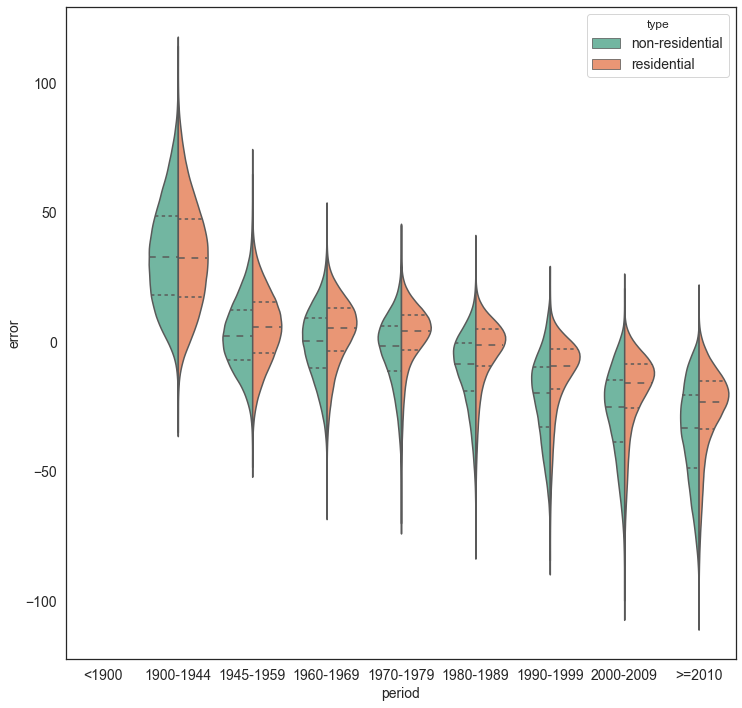

In [158]:
bins = dataset.TABULA_AGE_BINS['harmonized']
labels = utils.generate_labels(bins)

predictor = regressor_fts_importance_fr
df_res = predictor.individual_prediction_error()
df_res['period'] = pd.cut(predictor.y_test[dataset.AGE_ATTRIBUTE], bins, labels=labels, right=False) # not metric
df_res = df_res.join(predictor.aux_vars_test, how="inner")

%matplotlib inline

with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_res, x='period', y='error', hue='type', inner='quartile', split=True, palette='Set2', ax=ax)

In [423]:
y_preds = []
y_tests = []
# predictors = {'Netherlands': regressor_fts_importance_nl, 'France': regressor_fts_importance_fr, 'Spain': regressor_fts_importance_es}
predictors = {'Country cv': regressor_country_cv, 'City cv': regressor_nl_city_cv, 'Neighborhood cv': regressor_fts_importance_nl, 'Block cv': regressor_nl_block_cv, 'Random cv': regressor_nl_random_cv}
# predictors = {'City cv': regressor_nl_city_cv, 'Neighborhood cv': regressor_fts_importance_nl, 'Block cv': regressor_nl_block_cv, 'Random cv': regressor_nl_random_cv}

for c, p in predictors.items():
    y_pred = p.y_predict[p.y_predict[dataset.AGE_ATTRIBUTE].between(1900, 2017, inclusive=False)]
    y_test = p.y_test.loc[y_pred.index]
    y_pred['country'] = c
    y_test['country'] = c
    y_preds.append(y_pred)
    y_tests.append(y_test)

# y_test = pd.concat(y_tests)
# y_pred = pd.concat(y_preds)


# visualizations.plot_relative_grid(y_test, y_pred, bin_size=1, figsize=(8, 8))
# plt.savefig('../figures/error-gridplot-combined.svg')

for i, c in enumerate(predictors.keys()):
    visualizations.plot_relative_grid(y_tests[i], y_preds[i], bin_size=2, figsize=(8, 8))
    plt.savefig(f"../figures/error-gridplot-{c.replace(' ', '-')}.svg")

# sns.jointplot(y=y_test['age'], x=y_pred['age'], kind="hex")



# visualizations.plot_grid(y_test, y_pred)
# plt.savefig('../figures/feature-distributions.svg')
# import matplotlib
# colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
# matplotlib.colors.LinearSegmentedColormap.from_list("", ['thistle', 'paleturquoise', 'steelblue'])
# matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","violet","blue"])

Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [26]:
# def mean_bin_age(s, bins):
#     cat_to_metric = {idx: (bins[idx] + bins[idx+1]) / 2 for idx in range(len(bins) - 1)}
#     return s.map(cat_to_metric)

# bins = dataset.TABULA_AGE_BINS['harmonized']
# labels = utils.generate_labels(bins)

# error_dfs = []
# for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2), (regressor_fts_importance_es, gadm_spain, 4, 2), (regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
#     y = predictor.individual_prediction_error()
#     y['period'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
#     # y['period'] = pd.cut(predictor.y_test[dataset.AGE_ATTRIBUTE], bins, labels=labels, right=False) # not metric
#     # y['period'] = utils.custom_round(predictor.y_test[dataset.AGE_ATTRIBUTE], base=5) # moving average

#     y = pd.concat([y, predictor.aux_vars_test], axis=1, join="inner")
#     y['error'] = y['error'].abs()
#     error_by_city = y #.groupby(['city', 'period'])['error'].mean().reset_index()
#     error_by_city = error_by_city[['city', 'period', 'error']].merge(city_boundaries[[f'NAME_{gadm_level}', 'NAME_0', 'DEGURBA']], right_on=f'NAME_{gadm_level}', left_on='city', how='left')
#     error_dfs.append(error_by_city)

# df = pd.concat(error_dfs)

linestyles = ['-', '--', ':', '-.']
with visualizations.SubplotManager() as ax:
    # for i, (country, group) in enumerate(df.groupby('DEGURBA')):  # plot average cross countries
    for i, (country, group) in enumerate(df.groupby('NAME_0')):  # plot average across city types
        error_df = group.groupby('period')['error'].agg(['mean', 'std']).reset_index()
        error_df.plot(x='period', y='mean', kind='line', ax=ax, xlabel='Construction period', ylabel='MAE', xlim=(1900, 2020), ylim=(0, 50), label=country, style=linestyles[i])
        ax.set_xticks([1920,1940,1960,1980,2000], labels=['1920', '1940', '1960', '1980', '2000'])
        ax.legend(loc='upper center')
        # plot either std around mean or min max of DEBURBA types
        # groupby DEBURBA to get min max of deburga instead of min max of all buildings in this period
        error_degurba_df = group.groupby(['period', 'DEGURBA'])['error'].mean().reset_index().groupby('period')['error'].agg(['max', 'min', 'std']).reset_index()

        ax.fill_between(
            error_df['period'],
            # error_degurba_df['min'],
            # error_degurba_df['max'],
            error_df['mean'] - error_df['std'],
            error_df['mean'] + error_df['std'],
            alpha=0.1,
        )

        plt.savefig(f'../figures/error-over-years.svg')
        # for i, (degurba, d_group) in enumerate(group.groupby('DEGURBA')):
        #     d_group.plot(x='period', y='mean', kind='line', style=linestyles[i], ax=ax, ylim=(0, 50), label=f'{country} {degurba}')


In [538]:
df[df['period'].isin(['1960-1969','1970-1979','1980-1989'])]['error'].mean()
df[df['period'].isin(['1900-1944'])]['error'].mean()
df[df['period'].isin(['2000-2009', '>=2010'])]['error'].mean()

21.89838216205763

In [534]:
periods_df = df.groupby(['NAME_0', 'period'])['error'].mean().reset_index()
periods_df = periods_df.rename(columns={'NAME_0': 'Country', 'period': 'Construction period', 'error': 'MAE'})
pivot_table = periods_df[['MAE', 'Country', 'Construction period']].pivot_table(values=['MAE'], index=['Construction period'], columns=['Country'], margins=True)

pivot_table.columns = pivot_table.columns.droplevel(0) # drop "MAE" multi-index column
# pivot_table.to_latex('../figures/prediction-error-by-periods.tex', index=True, float_format='%.2f', caption='Prediction error across construction periods', label=table:error-by-periods)
pivot_table


Country,France,Netherlands,Spain,All
Construction period,,,,
1900-1944,33.821938,27.844218,37.985481,33.217212
1945-1959,12.024916,12.591786,15.417421,13.344708
1960-1969,11.114906,7.770391,11.849584,10.244960
1970-1979,9.658246,6.558260,11.912170,9.376225
1980-1989,9.910322,8.278921,12.137087,10.108776
1990-1999,15.287704,12.572493,14.132315,13.997504
2000-2009,20.766391,21.065634,18.134643,19.988889
>=2010,27.957152,29.401329,25.430972,27.596484
All,17.567697,15.760379,18.374959,17.234345


### Figure: Pivot table of construction period, city type and country

In [141]:
from sklearn import metrics

dfs = []
error_dfs = []
# bins = utils.generate_bins((1900, 2020, 10))
bins = dataset.TABULA_AGE_BINS['harmonized']
labels = utils.generate_labels(bins)
for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2), (regressor_fts_importance_es, gadm_spain, 4, 2), (regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
# for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2)]:
    df = predictor.individual_prediction_error()
    df['error'] = df['error']
    df['y_test'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
    df['y_predict'] = predictor.y_predict[dataset.AGE_ATTRIBUTE]
    df['period'] = pd.cut(predictor.y_test[dataset.AGE_ATTRIBUTE], bins, labels=labels, right=False)
    # df['period'].replace(dict(zip(range(1,8), labels[1:])), inplace=True)
    print(f'Mean error: {df["error"].mean()}')
    df = df.join(predictor.aux_vars_test, how="inner")
    df = df.join(predictor.X_test[['FootprintArea']], how="inner")
    df = preparation.add_residential_type_column(df)


    df = df.merge(city_boundaries[[f'NAME_{gadm_level}', 'NAME_0', 'DEGURBA']], right_on=f'NAME_{gadm_level}', left_on='city', how='left').set_index('id')

    error_by_city = df.groupby(['NAME_0', 'DEGURBA', 'type', 'period'], dropna=False).apply(lambda x: pd.Series({
            'MAE'       : x['error'].abs().mean(),
            'MAE-metrics': metrics.mean_absolute_error(x['y_test'], x['y_predict']),
            'n'         : len(x.index),
            'R2'        : metrics.r2_score(x['y_test'], x['y_predict']) # doesn't make sense for grouping on period
        })).reset_index()

    # error_by_city = geometry.to_gdf(error_by_city)
    error_dfs.append(error_by_city)
    dfs.append(df)


df = pd.concat(dfs)
error_df = pd.concat(error_dfs)

# old approach
# error_df[error_df['size'] > 10000].sort_values(by=['mean'])
# error_df.groupby('NAME_0').apply(lambda x: np.average(x['mean'], weights=x['size']))
# df = error_df.groupby(['NAME_0', 'DEGURBA', 'type', 'period'])['error'].agg(['count', 'mean', 'std']).reset_index()

# column renaming
error_df['DEGURBA'].replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)
error_df = error_df.rename(columns={'NAME_0': 'Country', 'period': 'Construction period'})



Mean error: 0.004688806440203154
Mean error: -0.03462956125813288
Mean error: 0.013162852881266677


2022-08-05 12:06:19,682 | WARNING : Building type information missing. Considering all buildings as residential.


In [254]:
pivot_table = error_df[['MAE', 'DEGURBA', 'Country', 'Construction period']].pivot_table(values=['MAE'], index=['Construction period'], columns=['Country', 'DEGURBA'], margins=True)
# error_df[['MAE', 'DEGURBA', 'Country', 'Construction period']].pivot_table(values=['MAE'], index=['Country', 'Construction period'], columns=['DEGURBA'], margins=True)

pivot_table.columns = pivot_table.columns.droplevel(0) # drop "MAE" multi-index column
new_cols = pivot_table.columns.reindex(['Netherlands', 'France', 'Spain', 'All'], level=0)
pivot_table = pivot_table.reindex(columns=new_cols[0])

pivot_table.to_latex('../figures/prediction-error-by-all.tex', index=True, float_format='%.2f', caption='Prediction error by city type, construction period, and country')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Country             Netherlands                           France             \
DEGURBA                1 (city)   2 (town)  3 (rural)   1 (city)   2 (town)   
Construction period                                                           
1900-1944             23.060449  33.382057  34.573950  30.415801  36.098210   
1945-1969              9.516255   9.771991  10.421881  11.240884  11.509832   
1970-1979              6.771781   6.251914   6.995713  12.099940  10.184193   
1980-1989              8.255361   7.958356   9.375220  17.229033  12.224253   
1990-1999             12.272930  12.426067  13.721617  24.122348  17.657456   
2000-2009             20.459807  21.094188  22.623677  30.446464  24.399581   
>=2010                29.956646  28.854132  29.589343  39.001135  31.500865   
All                   15.756176  17.105529  18.185914  23.507944  20.510627   

Country                             Spain                              All  
DEGURBA              3 (rural)   1 (city)   2 (town)  3 (rural)             
Construction period                                                         
1900-1944            40.432567  42.560626  46.391679  38.906994  37.877814  
1945-1969            12.865186  16.600570  18.237625  14.092643  13.492874  
1970-1979            10.477131  10.848363  13.648571  13.457767  11.055586  
1980-1989            12.697736   9.154319  10.661819  15.970319  12.352446  
1990-1999            18.559442   9.443355  10.537594  18.736885  15.980565  
2000-2009            25.383097  15.548013  14.566305  21.614763  21.907254  
>=2010               32.247837  22.857034  23.707597  41.495764  31.468134  
All                  21.808999  18.144612  19.678742  23.467876  20.590668

In [182]:
pivot_table = error_df[error_df['Country'] == 'France'][['MAE', 'DEGURBA', 'type', 'Construction period']].pivot_table(values=['MAE'], index=['Construction period'], columns=['DEGURBA', 'type'], margins=True)
pivot_table.columns = pivot_table.columns.droplevel(0) # drop "MAE" multi-index column
pivot_table.to_latex('../figures/prediction-error-type-FRA.tex', index=True, float_format='%.2f', caption='Prediction error in France by city type, construction period, and building usage')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


DEGURBA                    1 (city)                    2 (town)              \
type                non-residential residential non-residential residential   
Construction period                                                           
1900-1944                 24.732873   23.419730       30.636411   30.286030   
1945-1969                 10.647000   10.140225       10.684128   10.929941   
1970-1979                 13.790596    9.109822       10.576323    8.414397   
1980-1989                 20.644176   12.494623       13.451253    8.153282   
1990-1999                 27.837347   19.909247       21.480220   12.099535   
2000-2009                 30.166346   29.050888       25.950293   20.115064   
>=2010                    39.596078   38.356706       32.388897   27.698244   
All                       23.916345   20.354463       20.738218   16.813785   

DEGURBA                   3 (rural)                    All  
type                non-residential residential             
Construction period                                         
1900-1944                 36.812788   37.187703  30.512589  
1945-1969                 11.424997   12.179645  11.000989  
1970-1979                 10.492754    9.826589  10.368414  
1980-1989                 12.963348    9.305366  12.835341  
1990-1999                 22.145698   13.111005  19.430508  
2000-2009                 27.778210   18.569269  25.271678  
>=2010                    35.675800   25.411278  33.187834  
All                       22.470514   17.941551  20.372479

In [182]:
df.groupby(['NAME_0', 'type'])['error'].apply(lambda x: x.abs().mean())

NAME_0  type           
France  non-residential    22.484110
        residential        17.200683
Spain   non-residential    18.502431
        residential        19.399889
        unknown            26.338117
Name: error, dtype: float64

In [280]:
df_country = df[df['NAME_0'].isin(['France', 'Spain'])]
df_country = df_country.rename(columns={'NAME_0': 'Country'})
# df_country['type'].fillna('unknown', inplace=True)
df_country = df_country[df_country['type'] != 'unknown']

df_country = df_country.groupby(['Country', 'DEGURBA', 'type'])['error'].apply(lambda x: x.abs().mean()).reset_index()
pivot_table = df_country.pivot_table(values=['error'], index=['Country', 'DEGURBA'], columns=['type'], margins=False)
pivot_table.columns = pivot_table.columns.droplevel(0) # drop "MAE" multi-index column
pivot_table.columns = pivot_table.columns.rename(None) # drop Country cell
pivot_table.loc[('France', 'All'),:] = df_country[df_country['Country'] == 'France'].groupby(['type'])['error'].apply(lambda x: x.abs().mean())
pivot_table.loc[('Spain', 'All'),:] = df_country[df_country['Country'] == 'Spain'].groupby(['type'])['error'].apply(lambda x: x.abs().mean())
pivot_table = pivot_table.sort_index()
pivot_table.to_latex('../figures/prediction-error-type-DEGURBA.tex', index=True, float_format='%.2f', caption='Prediction error by building and settlement type in France and Spain', label='table:prediction-error-residential')
pivot_table

# df_country = df_country.groupby(['Country', 'period', 'type'])['error'].apply(lambda x: x.abs().mean()).reset_index()
# pivot_table = df_country.pivot_table(values=['error'], index=['period'], columns=['Country', 'type'], margins=False)
# pivot_table.columns = pivot_table.columns.droplevel(0) # drop "MAE" multi-index column
# pivot_table.columns = pivot_table.columns.rename(None, level=0) # drop Country cell
# pivot_table = pivot_table.sort_index()
# pivot_table.loc['All',:] = df_country.groupby(['Country', 'type'])['error'].apply(lambda x: x.abs().mean())
# pivot_table.to_latex('../figures/prediction-error-type-periods.tex', index=True, float_format='%.2f', caption='Prediction error by building type across construction periods in France and Spain', label='table:prediction-error-residential-periods')
# pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


non-residential  residential
Country DEGURBA                              
France  1.0            21.155374    17.436502
        2.0            20.632561    15.535117
        3.0            22.839069    17.484174
        All            21.542335    16.818598
Spain   1.0            16.177632    15.565726
        2.0            15.568639    17.274368
        3.0            22.339844    24.367939
        All            18.028705    19.069344

In [287]:
df_country = df[df['NAME_0'].isin(['France', 'Spain'])]
df_country = df_country.rename(columns={'NAME_0': 'Country'})

df_country['metatype'] = df_country['type']
# df_country['type'].fillna('unknown', inplace=True)
df_country = df_country[df_country['type'] != 'unknown']
df_country = harmonize_group_source_types(df_country)
df_country['type'] = np.where(df_country['type'] == 'residential', df_country['residential_type'], df_country['type'])

df_country_group = df_country.groupby(['Country', 'metatype', 'type'], dropna=True).apply(lambda x: pd.Series({
        'MAE'       : metrics.mean_absolute_error(x['y_test'], x['y_predict']),
        'RMSE'       : np.sqrt(metrics.mean_squared_error(x['y_test'], x['y_predict'])),
        'R2'        : metrics.r2_score(x['y_test'], x['y_predict']),
        'n'         : len(x.index),
    })).reset_index()

pivot_table = df_country_group.pivot_table(values=['R2', 'MAE', 'RMSE'], index=['metatype', 'type'], columns=['Country'], margins=False)
pivot_table = pivot_table.swaplevel(0, 1, axis=1)
pivot_table = pivot_table.sort_index(axis=1, level=0)
pivot_table.columns = pivot_table.columns.rename(None, level=0) # drop Country cell

new_cols = pivot_table.columns.reindex(['MAE', 'RMSE', 'R2'], level=1)
pivot_table = pivot_table.reindex(columns=new_cols[0])
# pivot_table.loc[('France', 'All'),:] = df_country[df_country['Country'] == 'France'].groupby(['type'])['error'].apply(lambda x: x.abs().mean())
# pivot_table.loc[('Spain', 'All'),:] = df_country[df_country['Country'] == 'Spain'].groupby(['type'])['error'].apply(lambda x: x.abs().mean())
pivot_table = pivot_table.sort_index(ascending=False)

pivot_table.to_latex('../figures/prediction-error-fine-granular-type.tex', index=True, float_format='%.2f', caption='Prediction error by fine-granular building type in France and Spain', label='table:prediction-error-fine-granular-types')
pivot_table


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may theref

France                           Spain  \
                                    MAE       RMSE        R2        MAE   
metatype        type                                                      
residential     TH            18.092241  24.672725  0.431736  21.284345   
                SFH           16.048118  21.978529  0.376297  16.545053   
                MFH           20.716695  27.467044  0.309220  16.002098   
                AB            15.622602  20.550609  0.035450  10.933419   
non-residential others        21.866204  28.357705  0.276258        NaN   
                industrial    15.761084  22.346697  0.141559  21.087274   
                commercial    26.658957  33.085124  0.123129  19.882416   
                agricultural  27.750853  34.213460  0.148903  14.750685   

                                                   
                                   RMSE        R2  
metatype        type                               
residential     TH            28.612939  0.275659  
                SFH           22.494812  0.257353  
                MFH           22.288014  0.296023  
                AB            14.723366  0.396498  
non-residential others              NaN       NaN  
                industrial    27.465195  0.389678  
                commercial    26.129721  0.251267  
                agricultural  19.559583  0.177105

In [222]:
0.143941 + 0.000255 +0.000023 + 0.001216

0.145435

In [324]:
df_test = df
df_test['type'].fillna('unknown', inplace=True)
df_test['type_source'].fillna('unknown', inplace=True)
# df_test.groupby('NAME_0')['type_source'].value_counts(normalize=True)
df_test.groupby('NAME_0')['type'].value_counts(normalize=True)
# df_test.groupby('NAME_0')['residential_type'].value_counts(normalize=True)

NAME_0       type           
France       residential        0.820773
             non-residential    0.176885
             unknown            0.002342
Netherlands  unknown            1.000000
Spain        residential        0.781580
             non-residential    0.211977
             unknown            0.006443
Name: type, dtype: float64

In [145]:
%matplotlib qt
df_test = df#.sample(frac=0.1)
df_test = df_test[df_test['y_test'] <= 2020]
df_test = df_test[df_test['y_predict'] <= 2030]
# # df_test['DEGURBA'].replace({'1 (city)': 1, '2 (town)':2 , '3 (rural)': 3}, inplace=True)

# # df_test['error'] = df_test['y_predict'] - df_test['y_test']
df_test = df_test.rename(columns={'NAME_0': 'Country'})
df_test['urban'] = df_test['DEGURBA'] < 3.0
df_test.loc[df_test['type'] == 'non-residential', 'residential_type'] = 'non-residential'

with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test[df_test['Country'] == 'France'], x='residential_type', y='error', inner='quartile', split=True, palette='husl', order=['SFH', 'TH', 'MFH', 'AB', 'non-residential'], ax=ax)
    ax.set_xlabel('Building type')
    ax.set_ylabel('Prediction error [years]')
    plt.savefig('../figures/error-by-residential-type-FRA-violin.svg')


with visualizations.SubplotManager() as ax:
    df_test['DEGURBA'].replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)
    sns.violinplot(data=df_test[df_test['Country'] == 'France'], x='DEGURBA', y='error', hue='type', inner='quartile', split=True, palette='husl', order=['1 (city)', '2 (town)', '3 (rural)'], ax=ax)
    ax.set_ylabel('Prediction error [years]')
    plt.savefig('../figures/error-by-settlement-type-FRA-violin.svg')


with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test, x='Country', y='error', hue='urban', inner='quartile', split=True, palette='husl', order=['Netherlands', 'France', 'Spain'], ax=ax)
    ax.set_ylabel('Prediction error [years]')

with visualizations.SubplotManager() as ax:
    df_test['DEGURBA'].replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)
    sns.violinplot(data=df_test, x='DEGURBA', y='error', hue='Country', inner='quartile', split=False, order=['1 (city)', '2 (town)', '3 (rural)'], palette='husl', ax=ax)
    ax.set_ylabel('Prediction error [years]')
    ax.legend(title=None)
    plt.title('Prediction error by settlement type')
    plt.savefig('../figures/error-by-settlement-type-violin.svg')


with visualizations.SubplotManager() as ax:
    sns.violinplot(data=df_test[df_test['type'].isin(['residential', 'non-residential'])], x='Country', y='error', hue='type', inner='quartile', split=True, palette='husl', order=['Netherlands', 'France', 'Spain'], ax=ax)
    ax.set_ylabel('Prediction error [years]')


with visualizations.SubplotManager() as ax:
    df_test['type'].fillna('unknown', inplace=True)
    order = ['residential', 'non-residential', 'unknown']
    sns.violinplot(data=df_test[df_test['Country'].isin(['France', 'Spain'])], x='type', y='error', hue='Country', order=order, inner='quartile', split=True, palette='husl', ax=ax)
    ax.set_xlabel('Building type', labelpad=20)
    ax.set_ylabel('Prediction error [years]')
    ax.axvline(0.5, color='grey', linestyle='--', lw=0.75)
    ax.axvline(1.5, color='grey', linestyle='--', lw=0.75)
    plt.title('Prediction error for building types in France and Spain')
    plt.savefig('../figures/error-by-type-country-violin.svg')



with visualizations.SubplotManager(figsize=(19, 9)) as ax: # 16,9 for Spain
    order = ['SFH', 'TH', 'MFH', 'AB', 'commercial', 'agricultural', 'industrial', 'others', 'unknown']

    country, annot_pos = 'France', [0.22, 0.67]
    # country, annot_pos = 'Spain', [0.25, 0.69]
    # order.remove('others')

    df_country = df_test[df_test['Country'] == country]

    df_country = harmonize_group_source_types(df_country)
    df_country['type'].fillna('unknown', inplace=True)
    df_country['type'] = np.where(df_country['type'] == 'residential', df_country['residential_type'], df_country['type'])

    sns.violinplot(data=df_country, x='type', y='error', order=order, hue='Country', inner='quartile', split=True, palette='huel', ax=ax)

    ax.annotate(text='residential\nbuilding types', xy=(annot_pos[0],-0.26), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
    ax.annotate(text='non-residential\nbuilding types', xy=(annot_pos[1],-0.26), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
    ax.axvline(3.5, color='grey', linestyle='--', lw=0.75)
    ax.axvline(len(order) - 1.5, color='grey', linestyle='--', lw=0.75)

    ax.set_ylim([-120, 120])
    ax.set_ylabel('Prediction error [years]')
    ax.set_xlabel(None)
    ax.set_xticklabels(['single-family house', 'terraced house', 'multi-family house', 'apartment block', 'commercial', 'agricultural', 'industrial', 'others', 'unknown'])
    plt.xticks(rotation=30)
    plt.title(f'Prediction error for fine-granular building types in {country}')
    plt.savefig(f'../figures/error-by-type-{country}-violin.svg')

    df_country['type'].value_counts()


with visualizations.SubplotManager(figsize=(19, 9)) as ax: # 16,9 for Spain
    order = ['SFH', 'TH', 'MFH', 'AB', 'commercial', 'agricultural', 'industrial', 'others']
    labels = ['single-family house', 'terraced house', 'multi-family house', 'apartment block', 'commercial', 'agricultural', 'industrial', 'others']
    colors = ['thistle', 'lightseagreen']

    df_country = df_test[df_test['Country'].isin(['Spain', 'France'])]

    df_country = harmonize_group_source_types(df_country)
    df_country = df_country[df_country['type'] != 'unknown']
    df_country['type'] = np.where(df_country['type'] == 'residential', df_country['residential_type'], df_country['type'])

    sns.violinplot(data=df_country, x='type', y='error', order=order, hue='Country', inner='quartile', split=True, palette=colors, ax=ax)

    ax.annotate(text='residential\nbuilding types', xy=(0.25,-0.35), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
    ax.annotate(text='non-residential\nbuilding types', xy=(0.70,-0.35), xycoords='axes fraction', horizontalalignment='center', fontsize=20)
    ax.axvline(3.5, color='grey', linestyle='--', lw=0.75)

    ax.set_ylim([-120, 120])
    ax.set_ylabel('Prediction error [years]')
    ax.set_xlabel(None)
    shares = df_country.groupby('Country')['type'].value_counts(normalize=True).mul(100).round(1).sort_index(level=0).groupby('type').apply(list).to_dict()
    shares['others'].append(0)
    labels = [f'{labels[i]}\n({shares[subtype][0]}% | {shares[subtype][1]}%)' for i, subtype in enumerate(order)]
    ax.set_xticklabels(labels)
    # ax.set_aspect(aspect=0.021)
    plt.xticks(rotation=30)
    plt.title(f'Prediction error for fine-granular building types in France and Spain', pad=20)
    plt.savefig(f'../figures/error-by-finegranular-type-violin.svg')

    df_country['type'].value_counts()

In [383]:
df[df['type'] != 'unknown'].groupby('NAME_0')['type'].value_counts(normalize=True)

NAME_0  type           
France  residential        0.822699
        non-residential    0.177301
Spain   residential        0.786648
        non-residential    0.213352
Name: type, dtype: float64

In [373]:
df_country.groupby('Country')['type'].value_counts(normalize=True).mul(100).round(1).sort_index(level=0).groupby('type').apply(list).to_dict() #.swaplevel(0, 1).reset_index(level=1, drop=True).to_dict() #.mul(100).round(1).to_dict()

{'AB': [0.2, 1.8],
 'MFH': [1.9, 3.8],
 'SFH': [38.1, 23.2],
 'TH': [42.2, 49.6],
 'agricultural': [0.1, 8.1],
 'commercial': [2.7, 3.8],
 'industrial': [0.5, 9.7],
 'others': [14.4]}

In [249]:
df[df['NAME_0'] == 'France']['type_source'].value_counts(dropna=False)

Résidentiel               1467894
Annexe                     257429
Commercial et services      48272
Industriel                   7974
Indifférencié                4188
Agricole                     2175
Sportif                       456
Religieux                      41
Name: type_source, dtype: int64

In [250]:
df[df['NAME_0'] == 'Spain']['type_source'].value_counts(dropna=False)

1_residential         1199850
3_industrial           146895
2_agriculture          121998
4_3_publicServices      29639
4_2_retail              21281
unknown                  9891
4_1_office               5606
Name: type_source, dtype: int64

In [323]:
harm_df = harmonize_group_source_types(df_es_sample)
harm_df[['type', 'type_source']]['type'].value_counts(dropna=False)
# harm_df[harm_df[dataset.TYPE_ATTRIBUTE] != 'residential'][dataset.TYPE_ATTRIBUTE].isin(['residential', None])
# harm_df[dataset.TYPE_ATTRIBUTE].isin([None]).sort_values()
harm_df[dataset.TYPE_ATTRIBUTE] = np.where((harm_df[dataset.TYPE_ATTRIBUTE].isnull()), 'fine-granular-type', harm_df[dataset.TYPE_ATTRIBUTE])
harm_df[['type', 'type_source']]['type'].value_counts(dropna=False)

# categorical_to_int(harm_df, var='type', labels=['residential', 'commercial', 'agricultural', 'industrial'])[['type', 'type_source', 'type_label']]['type'].value_counts()
# df_es_sample['type'].unique()
# df_es_sample['type'].astype('category').cat.codes
# categorical_to_int(remove_buildings_with_unknown_type(df_fr_sample), var='type', labels=['residential', 'non-residential'])[['type', 'type_source', 'type_label', 'residential_type']]['type'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

residential           18520
industrial             2378
agricultural            579
commercial              442
fine-granular-type       16
Name: type, dtype: int64

#### City comparison

In [464]:
from sklearn import metrics

error_dfs = []
# bins = utils.generate_bins((1900, 2020, 10))
bins = dataset.TABULA_AGE_BINS['harmonized']
labels = utils.generate_labels(bins)
for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2), (regressor_fts_importance_es, gadm_spain, 4, 2), (regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
    df = predictor.individual_prediction_error()
    df['error'] = df['error'].abs()
    df['y_test'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
    df['y_predict'] = predictor.y_predict[dataset.AGE_ATTRIBUTE]
    df['period'] = pd.cut(predictor.y_test[dataset.AGE_ATTRIBUTE], bins, right=False).cat.codes
    df['period'].replace(dict(zip(range(1,8), labels[1:])), inplace=True)
    print(f'Mean error: {df["error"].mean()}')
    df = df.join(predictor.aux_vars_test, how="inner")

    error_by_city = df.groupby(['city'], dropna=False).apply(lambda x: pd.Series({
            'MAE'       : x['error'].mean(),
            'MAE-metrics': metrics.mean_absolute_error(x['y_test'], x['y_predict']),
            'n'         : len(x.index),
            'R2'        : metrics.r2_score(x['y_test'], x['y_predict']) # doesn't make sense for grouping on period
        })).reset_index()

    error_by_city = error_by_city.merge(city_boundaries[[f'NAME_{gadm_level}', 'NAME_0', 'DEGURBA']], right_on=f'NAME_{gadm_level}', left_on='city', how='left')
    error_dfs.append(error_by_city)

error_df = pd.concat(error_dfs)

# column renaming
error_df['DEGURBA'].replace({1.0: '1 (city)', 2.0: '2 (town)', 3.0: '3 (rural)'}, inplace=True)
error_df = error_df.rename(columns={'NAME_0': 'Country'})

table = error_df.groupby(['Country', 'DEGURBA'])['MAE'].agg(['count', 'mean', 'std'])
table_total = error_df.groupby(['Country'])['MAE'].agg(['count', 'mean', 'std'])
table_total['DEGURBA'] = 'All'
new_table = pd.concat([table, table_total.set_index(['DEGURBA'], append=True)]).sort_index(level=0)
new_table = new_table.rename(columns={'mean': 'MAE mean', 'std': 'MAE std', 'count': 'n'})
new_table.to_latex('../figures/prediction-error-by-city-type.tex', index=True, float_format='%.2f', caption='Prediction error by settlement type', label='table:error-by-settlement-type')

new_table



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


count   MAE mean   MAE std
Country     DEGURBA                              
France      1 (city)     124  18.357471  4.931862
            2 (town)     315  16.374822  3.766594
            3 (rural)   2083  20.267423  3.975355
            All         2725  19.718968  4.294601
Netherlands 1 (city)      98  14.910172  4.449907
            2 (town)     238  15.282632  4.000469
            3 (rural)     88  16.590624  2.411283
            All          424  15.468015  3.880323
Spain       1 (city)     107  15.523778  4.551334
            2 (town)     640  17.399037  5.121387
            3 (rural)   3530  26.591560  9.136878
            All         5260  24.923218  9.257727

In [472]:
error_df.groupby(['Country'])['MAE'].agg(['count', 'mean', 'std'])

,count,mean,std
Country,,,
France,2725,19.718968,4.294601
Netherlands,424,15.468015,3.880323
Spain,5260,24.923218,9.257727


In [490]:
error_df[error_df['n'] > 100].groupby(['Country', 'DEGURBA'])['MAE'].agg(['count', 'mean', 'std'])

count       mean       std
Country     DEGURBA                              
France      1 (city)     113  18.337403  4.715487
            2 (town)     293  16.383979  3.583438
            3 (rural)   2049  20.222279  3.849010
Netherlands 1 (city)      96  14.810744  4.425439
            2 (town)     232  15.004623  3.407316
            3 (rural)     88  16.590624  2.411283
Spain       1 (city)      97  15.526334  4.645267
            2 (town)     594  17.320194  4.776974
            3 (rural)   2681  26.095696  7.777249

In [486]:
np.cumsum(pd.cut(error_df[error_df['Country'] == 'Spain']['n'], [0, 10, 100, 1000, 10000, 100000, 1000000], labels=['< 10','< 100', '< 1000', '< 10000', '< 100000','< 1000000'], right=False).value_counts(normalize=True).sort_index())

< 10         0.029658
< 100        0.211217
< 1000       0.697909
< 10000      0.980228
< 100000     0.999810
< 1000000    1.000000
Name: n, dtype: float64

In [512]:
from scipy import stats
for c in ['Netherlands', 'France', 'Spain']:
    df = error_df[(error_df['Country'] == c)]
    print(stats.stats.pearsonr(df['MAE'], df['n']))
    stats.linregress(df['MAE'], df['n'])


(-0.22173416920097944, 4.03027800035525e-06)
(-0.37208220329527203, 3.1655677891026756e-90)
(-0.2188654878862992, 4.5045282385866765e-58)


Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.


In [184]:
import seaborn as sns
# error_df[error_df['R2'] < 0] = 0
df_nl_scatter = error_df[(error_df['R2'] > 0) & (error_df['NAME_0'] == 'Netherlands')]
ax = sns.lmplot(x='n', y='R2', data=df_nl_scatter, hue='DEGURBA', scatter=True, fit_reg=True, scatter_kws={"s": 1})
# ax.set(xscale="log")



KeyError: 'NAME_0'

#### Figure: Error on Map

In [28]:
# from sklearn import metrics
# %matplotlib qt
# label = False
# # visualizations.plot_prediction_error_on_map_by_city(regressor_fts_importance_nl, geometry.to_gdf(gadm_netherlands), dissolve_level=None)
# # visualizations.plot_prediction_error_on_map_by_city(regressor_fts_importance_fr, geometry.to_gdf(gadm_france), gadm_level=4, dissolve_level=None)
# # visualizations.plot_prediction_error_on_map_by_city(regressor_fts_importance_es, geometry.to_gdf(gadm_spain), gadm_level=4, dissolve_level=2)
# import matplotlib
with visualizations.SubplotManager() as ax:
    error_dfs = []
    for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_fr, gadm_france, 4, 2), (regressor_fts_importance_es, gadm_spain, 4, 2), (regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
    # for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_es, gadm_spain, 4, 2)]:
    # for predictor, city_boundaries, gadm_level, dissolve_level in [(regressor_fts_importance_nl, gadm_netherlands, 2, 1)]:
        y = predictor.individual_prediction_error()
        y['error'] = y['error'].abs()
        y['y_test'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
        y['y_predict'] = predictor.y_predict[dataset.AGE_ATTRIBUTE]
        y = pd.concat([y, predictor.aux_vars_test], axis=1, join="inner")

        y = y.merge(city_boundaries[[f'NAME_{gadm_level}', f'NAME_{dissolve_level}']], right_on=f'NAME_{gadm_level}', left_on='city', how='left').reset_index()

        error_by_city = y.groupby([f'NAME_{dissolve_level}'], dropna=False).apply(lambda x: pd.Series({
            # 'error'       : x['error'].mean(),
            'mae': metrics.mean_absolute_error(x['y_test'], x['y_predict']),
            'n'            : len(x.index),
            'error'        : metrics.r2_score(x['y_test'], x['y_predict'])
        })).reset_index()
        # error_by_city = y.groupby('city')['error'].mean()
        # error_by_city = y.groupby('city').apply(lambda x: metrics.r2_score(x['y_test'], x['y_predict'])).reset_index(name='error')
        error_by_city[error_by_city['error'] < 0] = 0
        error_by_city = geometry.to_gdf(city_boundaries).dissolve(by=f'GID_{dissolve_level}').merge(error_by_city, on=f'NAME_{dissolve_level}', how='left')
        error_by_city['region'] = error_by_city[f'NAME_{dissolve_level}']

        if label:
            min = error_by_city.iloc[error_by_city['error'].idxmin()]
            max = error_by_city.iloc[error_by_city['error'].idxmax()]
            min_text = f"min error {min['error']:.2f}\n({min[f'NAME_{gadm_level}']})"
            max_text = f"max error {max['error']:.2f}\n({max[f'NAME_{gadm_level}']})"
            ax.annotate(text=min_text, xy=min.geometry.centroid.coords[0], ha='center')
            ax.annotate(text=max_text, xy=max.geometry.centroid.coords[0], ha='center')

        error_dfs.append(error_by_city)
    error_df = pd.concat(error_dfs)

    colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
    # colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise', 'lightseagreen']
    # colors = list(reversed(colors))
    cmap = matplotlib.colors.ListedColormap(colors)

    error_df.dissolve('GID_0').boundary.plot(ax=ax, color='lavender', linewidth=0.3)
    error_df.plot(ax=ax, column='error', legend=True, cmap=cmap, edgecolor=None, linewidth=0, legend_kwds={'shrink': 0.7, 'orientation': 'vertical', 'pad': 0,  'label': '$R^2$'})
    plt.axis('off')



In [987]:
# error_df[['NAME_0', 'NAME_', 'mae', 'error']]
error_df

,geometry,NAME_0,NAME_1,NAME_2,NAME_3,NAME_4,GID_0,GID_1,GID_3,GID_4,...,LAU CODE,POPULATION,NL_NAME_1,GID_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"POLYGON ((3769576.539 2492100.687, 3768086.046...",France,Auvergne-Rhône-Alpes,Puy-de-Dôme,Ambert,Ambert,FRA,FRA.1_1,FRA.1.10.1_1,FRA.1.10.1.1_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((3909714.070 2499142.030, 3909428.161...",France,Auvergne-Rhône-Alpes,Rhône,Lyon,Bron,FRA,FRA.1_1,FRA.1.11.1_1,FRA.1.11.1.1_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((4021093.098 2479134.719, 4020595.965...",France,Auvergne-Rhône-Alpes,Savoie,Albertville,Aime,FRA,FRA.1_1,FRA.1.12.1_1,FRA.1.12.1.1_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((3930615.784 2534620.365, 3929853.199...",France,Auvergne-Rhône-Alpes,Ain,Belley,Ambérieu-en-Bugey,FRA,FRA.1_1,FRA.1.1.1_1,FRA.1.1.1.1_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((3788893.861 2576368.672, 3788516.717...",France,Auvergne-Rhône-Alpes,Allier,Montluçon,Commentry,FRA,FRA.1_1,FRA.1.2.1_1,FRA.1.2.1.2_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,"MULTIPOLYGON (((4099138.277 3339437.378, 40986...",Netherlands,Groningen,Appingedam,NaN,NaN,NLD,NaN,NaN,NaN,...,GM0003,11721.0,NaN,NLD.5.1_1,None,NaN,Gemeente,Municipality,NaN,NL.GR.AP
10,"POLYGON ((3980611.667 3260569.929, 3980229.804...",Netherlands,IJsselmeer,None,NaN,NaN,NLD,NaN,NaN,NaN,...,GM0532,21706.0,NaN,NLD.6.1_1,None,NaN,Water body,Water body,NaN,None
11,"POLYGON ((4020112.859 3081146.867, 4020081.923...",Netherlands,Limburg,Beek,NaN,NaN,NLD,NaN,NaN,NaN,...,GM0888,15929.0,NaN,NLD.7.3_1,None,NaN,Gemeente,Municipality,NaN,NL.LI.BK
12,"POLYGON ((3922602.953 3157673.632, 3922783.633...",Netherlands,Noord-Brabant,'s-Hertogenbosch,NaN,NaN,NLD,NaN,NaN,NaN,...,GM0796,154205.0,NaN,NLD.8.1_1,Bergeyk,NaN,Gemeente,Municipality,NaN,NL.NB.SH


In [635]:
spe = pd.read_csv('../notebooks/specialized-regional-models-23915991-20220730-01-01-42-itermediate-comparison-results.csv')[['name', 'R2', 'MAE']]
# add_features_results['Country'] = add_features_results['name'].str.split('_').str[0]
spe['region'] = spe['name'].str.split('_').str[1]
spe.sort_values(by='region', ascending=True)

,name,R2,MAE,region
0,ESP_A Coruña_80,0.338157,17.797119,A Coruña
3,ESP_Albacete_80,0.398620,23.863497,Albacete
10,ESP_Alicante_80,0.562238,12.096494,Alicante
9,ESP_Almería_80,0.536436,13.291172,Almería
2,ESP_Asturias_80,0.389359,21.869520,Asturias
1,ESP_Badajoz_80,0.379609,19.369742,Badajoz
7,ESP_Baleares_80,0.510720,15.231747,Baleares
6,ESP_Barcelona_80,0.494997,15.157180,Barcelona
4,ESP_Burgos_80,0.414159,22.632680,Burgos
5,ESP_Cantabria_80,0.451652,20.498453,Cantabria


In [639]:
# error_df[error_df['NAME_2'].isin(spe['region'].values)][['NAME_2', 'error', 'mae', 'n']]
error_df[error_df['NAME_1'].isin(['Flevoland', 'Groningen', 'Friesland', 'Gelderland', 'Drenthe'])][['NAME_1', 'error', 'mae', 'n']]

,NAME_1,error,mae,n
5,Drenthe,0.365694,14.231995,237026.0
6,Flevoland,0.548705,6.525441,174893.0
7,Friesland,0.451444,14.988049,263894.0
8,Gelderland,0.367535,15.285617,773655.0
9,Groningen,0.451543,16.364632,267191.0


In [272]:
error_df[error_df['NAME_0'] == 'France'].sort_values(by='error')[['error', 'NAME_2']].dropna()['error'].std()

0.07050298567984417

In [114]:
for results in [regional_nld, regional_esp, regional_fra]:
    results['availability'] = results['name'].str.split('_').str[0].astype(int)
    results['Country'] = results['name'].str.split('_').str[1]
    results['Region'] = results['name'].str.split('_').str[2]
    results['n'] = results['name'].str.split('_').str[3].astype(int)
    results = results[results['availability'] == 80]
    print(results.groupby('availability').apply(lambda x: np.average(x['MAE'], weights=x.n)))
    print(sum(results['MAE'] < 20) / len(results))

availability
80    9.617869
dtype: float64
1.0
availability
80    16.659844
dtype: float64
0.6808510638297872
availability
80    15.79765
dtype: float64
0.967032967032967


In [163]:
# plot with predefined value bins / value color mapping
colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
error_df['error_color'] = pd.cut(error_df['error'], [-10, 0, 0.25, 0.5, 0.75, 1], labels=['< 0.00', '0.00 - 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75'], right=False)
cmap = matplotlib.colors.ListedColormap(list(reversed(colors)))
error_df.plot(legend=True, column='error_color', cmap=cmap, edgecolor=None, linewidth=0)
plt.axis('off')


(3845554.2428076672, 4149464.4738966064, 3059900.564596048, 3404339.508031441)

In [131]:
# from sklearn import metrics

# # national_nld = AgePredictor.load('../results/model-NLD-random-cv.pkl')
# # national_esp = AgePredictor.load('../results/model-ESP-random-cv.pkl')
# # national_fra = AgePredictor.load('../results/model-FRA-random-cv.pkl')

# results = []
# for predictor in [national_nld, national_esp, national_fra]:
#     country_result = predictor.aux_vars_test[['city', 'country']]
#     country_result['y_test'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
#     country_result['y_predict'] = predictor.y_predict[dataset.AGE_ATTRIBUTE]
#     # country_result = country_result.merge(gadm[[f'NAME_{gadm_level}', f'NAME_{dissolve_level}']], left_on='city', right_on=f'NAME_{gadm_level}', how='left').reset_index()
#     results.append(country_result)

# country_result = pd.concat(results, axis=0)

# country_result_grouped = country_result.groupby(['country'], dropna=False).apply(lambda x: pd.Series({
#         'MAE'       : metrics.mean_absolute_error(x['y_test'], x['y_predict']),
#         'R2'        : metrics.r2_score(x['y_test'], x['y_predict']),
#         '<10'        : sum((x['y_test'] - x['y_predict']).abs() < 10) / len(x),
#         '<15'        : sum((x['y_test'] - x['y_predict']).abs() < 15) / len(x),
#         '<20'        : sum((x['y_test'] - x['y_predict']).abs() < 20) / len(x),
#         'n'            : len(x.index),
#     })).reset_index()
country_result_grouped

,country,MAE,R2,<10,<15,<20,n
0,ESP,17.477905,0.428060,0.407354,0.558425,0.673693,7758976.0
1,FRA,16.841685,0.455593,0.449828,0.597259,0.700729,9596614.0
2,NLD,10.084359,0.632857,0.685579,0.778479,0.838263,5441430.0


#### Specialized regional models

In [73]:
# from sklearn import metrics

# regional_nld = pd.read_csv('../results/results-specialized-regional-models-NLD.csv')
# regional_esp = pd.read_csv('../results/results-specialized-regional-models-ESP.csv')
# regional_fra = pd.read_csv('../results/results-specialized-regional-models-FRA.csv')

# # national_nld = AgePredictor.load('../results/model-NLD-random-cv.pkl')
# # national_esp = AgePredictor.load('../results/model-ESP-random-cv.pkl')
# # national_fra = AgePredictor.load('../results/model-FRA-random-cv.pkl')



# import matplotlib
# geo_results = []
# for predictor, results, gadm, gadm_level, dissolve_level in [(national_fra, regional_fra, gadm_france, 4, 2), (national_esp, regional_esp, gadm_spain, 4, 2), (national_nld, regional_nld, gadm_netherlands, 2, 1)]:
#     results['Local data availability'] = results['name'].str.split('_').str[0].astype(int)
#     results['Country'] = results['name'].str.split('_').str[1]
#     results['Region'] = results['name'].str.split('_').str[2]
#     results['n'] = results['name'].str.split('_').str[3].astype(int)

#     country_result = predictor.aux_vars_test[['city', 'country']]
#     country_result['y_test'] = predictor.y_test[dataset.AGE_ATTRIBUTE]
#     country_result['y_predict'] = predictor.y_predict[dataset.AGE_ATTRIBUTE]
#     country_result = country_result.merge(gadm[[f'NAME_{gadm_level}', f'NAME_{dissolve_level}']], left_on='city', right_on=f'NAME_{gadm_level}', how='left').reset_index()

#     country_result_by_region = country_result.groupby(['country', f'NAME_{dissolve_level}'], dropna=False).apply(lambda x: pd.Series({
#             'MAE'       : metrics.mean_absolute_error(x['y_test'], x['y_predict']),
#             'R2'        : metrics.r2_score(x['y_test'], x['y_predict']),
#             'n'            : len(x.index),
#         })).reset_index()
#     country_result_by_region['Region'] = country_result_by_region[f'NAME_{dissolve_level}']
#     country_result_by_region['Country'] = country_result_by_region['country']
#     country_result_by_region['Local data availability'] = 'non-regional'

#     gadm = geometry.to_gdf(gadm).dissolve(by=f'GID_{dissolve_level}')
#     results = pd.concat([results, country_result_by_region], axis=0)
#     geo_results.append(gadm.merge(results, left_on=f'NAME_{dissolve_level}', right_on='Region', how='left').reset_index())

# eu_geo_results = pd.concat(geo_results, axis=0)
# borders = eu_geo_results.dissolve('GID_0').boundary.simplify(1000)

# # colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
# colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise', 'lightseagreen']
# # # colors = list(reversed(colors))
# cmap = matplotlib.colors.ListedColormap(colors)


##### BOXPLOT #####
with visualizations.SubplotManager() as ax:
    # ax.set_ylim(0, 1)
    # sns.lineplot(data=eu_geo_results.reset_index(drop=True).sort_values(by=['Local data availability','R2']), hue='Local data availability', y='R2', x='Region', ax=ax)
    # sns.boxplot(data=eu_geo_results.reset_index(drop=True).sort_values(by=['Local data availability','R2']), y='Local data availability', x='R2', hue='Country', palette=['darksalmon', 'steelblue', 'teal'], ax=ax)

    # best visualization (besides map)
    ax.set_xlim(0, 1)
    prepared_eu_geo_results = eu_geo_results.replace({'non-regional': 'national model\n(random cv)', 10: '10%', 20: '20%', 50: '50%', 80: '80%'}).reset_index(drop=True).sort_values(by=['Local data availability','R2'])
    sns.boxplot(data=prepared_eu_geo_results, fliersize=0, hue='Local data availability', x='R2', y='Country', palette='husl', hue_order=['10%', '20%', '50%', '80%', 'national model\n(random cv)'], ax=ax)
    ax.set_yticklabels(['Spain', 'France', 'Netherlands'])
    ax.set_ylabel(None)
    ax.set_xlabel('$R^2$')
    plt.savefig('../figures/regional-models-boxplot.svg')


##### TABLE #####
def f1(x):
    return '%.1f' % x

def f2(x):
    return '%.2f' % x

# table = prepared_eu_geo_results.groupby(['Country', 'Local data availability'])[['R2', 'MAE']].mean().unstack(level=0).swaplevel(0,1, axis=1).sort_index(axis=1)
# table.to_latex('../figures/regional-models.tex', index=True,  formatters=[f1, f2, f1, f2, f1, f2], caption='Impact of local data availability for region models', label='table:regional-models')


##### MAP #####
# with visualizations.SubplotManager(ncols=3, constrained_layout=True) as ax:
#     for idx, share in enumerate([10, 80, 'non-regional']):
#         results_x = eu_geo_results[eu_geo_results['Local data availability'] == share]
#         # results_x = results_x[results_x['Country'] == 'FRA']

#         # results_x['R2_pos'] = utils.custom_round(results_x['R2'].apply(lambda x: x if x > 0 else 0), base=0.2)
#         # results_x['R2_pos'] = pd.cut(results_x['R2'], bins=[-10,0.2,0.4,0.6,0.8])


#         # cmap_boundaries = matplotlib.colors.ListedColormap(['darksalmon', 'steelblue', 'teal'])
#         # gpd.GeoDataFrame(geometry=eu_geo_results.dissolve('GID_0').boundary.simplify(1000)).reset_index().plot(ax=ax[idx], column='GID_0', cmap=cmap_boundaries, linewidth=0.3)

#         borders.plot(ax=ax[idx], color='lightgray', linewidth=0.3)
#         results_x.plot(ax=ax[idx], column='R2', legend=idx==2, vmin=0.09, vmax=0.61, cmap=cmap, edgecolor=None, linewidth=0, legend_kwds={'shrink': 0.4, 'orientation': 'vertical', 'pad': 0.15, 'label': 'R2', 'ticks': [0.1, 0.2, 0.3, 0.4, 0.5]})
#         # results_x.plot(ax=ax, column='MAE', legend=True, vmin=5, vmax=15, cmap=cmap, edgecolor=None, linewidth=0)
#         ax[idx].set_axis_off()
#         ax[idx].set_title(f'regional model\n({share}% local data)' if share != 'non-regional' else 'national model\n(80% data)', fontsize=14)

: 

In [1256]:
table.loc['80%'] - table.loc['national model\n(random cv)']

Country     
ESP      MAE   -1.028366
         R2     0.032135
FRA      MAE   -1.375989
         R2     0.040198
NLD      MAE   -0.686609
         R2     0.023715
dtype: float64

In [ ]:
with visualizations.SubplotManager() as ax:

    geometry.to_gdf(gadm_france).dissolve('GID_2').plot(ax=ax)
    geometry.to_gdf(gadm_france).dissolve('GID_2').apply(lambda x: ax.annotate(text=x['NAME_2'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)


In [944]:
eu_geo_results[['n', 'Country', 'Local data availability', 'R2']]

,n,Country,Local data availability,R2
0,167099,ESP,10,0.446093
1,167099,ESP,20,0.477795
2,167099,ESP,50,0.513747
3,167099,ESP,80,0.530615
4,287993,ESP,10,0.470725
...,...,...,...,...
45,1035722,NLD,80,0.577262
46,570857,NLD,10,0.622760
47,570857,NLD,20,0.654139
48,570857,NLD,50,0.686171


#### In-fill housing

In [409]:
import ast
predictors = {'Netherlands': regressor_fts_importance_nl, 'Spain': regressor_fts_importance_es, 'France': regressor_fts_importance_fr}
for country, predictor in predictors.items():
    y_test = predictor.y_test.rename(columns={'age': 'y_test'})
    y_predict = predictor.y_predict.rename(columns={'age': 'y_predict'})
    y = pd.concat([y_test, y_predict, predictor.aux_vars_test], axis=1, join="inner")
    y = determine_infill_housing(y)
    print(country)
    print(metrics.mean_absolute_error(y[y['infill']]['y_test'], y[y['infill']]['y_predict']))
    print(metrics.mean_absolute_error(y[~y['infill']]['y_test'], y[~y['infill']]['y_predict']))
    print(metrics.r2_score(y[y['infill']]['y_test'], y[y['infill']]['y_predict']))
    print(metrics.r2_score(y[~y['infill']]['y_test'], y[~y['infill']]['y_predict']))

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


Netherlands
25.544858895949314
14.250209838073424
-1.6008990583185478
0.44387218709115106


Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


Spain
36.290889297123165
19.15466827433844
-0.4462284106901184
0.3606706108260671


Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


France
43.68887679819899
17.934925873480832
-8.164556310258924
0.41130697697658825


In [410]:
(25.54 - 14.25 + 36.29 - 19.15 + 43.69 - 17.93) / 3)

18.063333333333336

In [417]:
(16.59 - 14.31 + 20.27 - 18.00 + 26.59 - 19.29) / 3

3.9499999999999993

In [251]:
def determine_infill_housing(df):
    columns = list(df.columns)
    df['n_neighbors'] = df['TouchesIndexes'].fillna('[1]').apply(lambda l: len(ast.literal_eval(l)))
    groups = df.groupby('sbb')['y_test']
    groups_mean = groups.transform('mean')
    groups_std = groups.transform('std')
    groups_size = groups.transform('size')
    df['sbb_mean'] = groups_mean
    df['sbb_deviation'] = df['y_test'] - groups_mean
    df['sbb_std'] = groups_std
    df['outliers'] = ((df['sbb_deviation'] / groups_std).abs() > 2) & (groups_size > 10)
    df['infill'] = (df['sbb_deviation'] / groups_std > 2) & (groups_size > 10) & (df['n_neighbors'] > 3)
    return df[set(columns + ['infill'])]

predictor = regressor_fts_importance_fr
y = predictor.y_test.rename(columns={'age': 'y_test'})
y = pd.concat([y, predictor.aux_vars_test], axis=1, join="inner")
y = y[y['city'] == 'Vichy']
y_geom = determine_infill_housing(y)
y_geom['id'] = y_geom['id_source']
y_geom = y_geom.drop(columns=['geometry'])
y_geom = geometry.add_geometry_column(y_geom, crs=3035, countries=['france'])
y_geom = geometry.to_gdf(y_geom)

with visualizations.SubplotManager() as ax:
    y_geom.plot(ax=ax, column='y_test', legend=True, cmap='Purples', edgecolor=None)
    # y_geom[y_geom['outliers']].plot(ax=ax, color='red')
    y_geom[y_geom['infill']].boundary.plot(ax=ax, color='orange')
    plt.axis('off')


# y[['y_test', 'y_predict', 'sbb_deviation', 'infill', 'sbb_mean', 'sbb_std', 'sbb']]
# y['infill'].value_counts()

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-07-17 17:56:42,844 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.


### Feature importance

#### Table: Group feature importance

In [12]:
%matplotlib qt
predictors = {'Netherlands': regressor_fts_importance_nl, 'France': regressor_fts_importance_fr, 'Spain': regressor_fts_importance_es}
# predictors = {'France': regressor_fts_importance_fr, 'Netherlands': regressor_fts_importance_nl, 'Spain': regressor_fts_importance_es}

df_importance = []
df_group_importance = []
for country, predictor in predictors.items():
    fts_importance_reg = predictor.normalized_feature_importance()
    df_importance.append(fts_importance_reg)

    fts_importance_reg_sig = fts_importance_reg[fts_importance_reg['normalized_importance'] > 0.01]
    print(f'{country}: {len(fts_importance_reg_sig)} of {len(fts_importance_reg)} features are significant for regression.')
    # neighborhood_mask = (fts_importance_reg['feature'].str.contains('within_buffer')) | (fts_importance_reg['feature'].isin(dataset.CITY_FEATURES))
    # street_mask = fts_importance_reg['feature'].isin(dataset.STREET_FEATURES)
    # building_mask = fts_importance_reg['feature'].isin(dataset.BUILDING_FEATURES + dataset.BLOCK_FEATURES)
    # neighborhood_fts_importance = round(sum(fts_importance_reg.loc[neighborhood_mask].normalized_importance), 2)
    # street_fts_importance = round(sum(fts_importance_reg.loc[street_mask].normalized_importance), 2)
    # building_fts_importance = round(sum(fts_importance_reg.loc[building_mask].normalized_importance), 2)
    # print(f'{country}: Share of feature contribution captured by neighborhood features {neighborhood_fts_importance}')
    # print(f'{country}: Share of feature contribution captured by building features {building_fts_importance}')
    # print(f'{country}: Share of feature contribution captured by street features {street_fts_importance}')
    fts_groups = {
        'Building': dataset.BUILDING_FEATURES,
        'Building neighborhood': dataset.BUILDING_FEATURES_NEIGHBORHOOD,
        'Block': dataset.BLOCK_FEATURES,
        'Block neighborhood': dataset.BLOCK_FEATURES_NEIGHBORHOOD,
        # 'Street': dataset.STREET_FEATURES,
        # 'Street neighborhood': dataset.STREET_FEATURES_NEIGHBORHOOD,
        'Street': dataset.STREET_ONLY_FEATURES,
        'Street neighborhood': dataset.STREET_ONLY_FEATURES_NEIGHBORHOOD,
        'Street-based block': dataset.SBB_FEATURES,
        'Street-based block neighborhood': dataset.SBB_FEATURES_NEIGHBORHOOD,
        'Street centrality': dataset.STREET_FEATURES_CENTRALITY,
        'City': dataset.CITY_FEATURES,
        'Total: all building': dataset.BUILDING_FEATURES_ALL,
        'Total: all block': dataset.BLOCK_FEATURES_ALL,
        # 'Total: all street ': dataset.STREET_FEATURES_ALL,
        'Total: all street ': dataset.STREET_ONLY_FEATURES + dataset.STREET_ONLY_FEATURES_NEIGHBORHOOD + dataset.STREET_FEATURES_CENTRALITY,
        'Total: all street-based blocks ': dataset.SBB_FEATURES + dataset.SBB_FEATURES_NEIGHBORHOOD,
        # 'Total: building & block & street ': dataset.BUILDING_FEATURES + dataset.BLOCK_FEATURES + dataset.STREET_FEATURES,
        'Total: building & block & street ': dataset.BUILDING_FEATURES + dataset.BLOCK_FEATURES + dataset.STREET_ONLY_FEATURES + dataset.SBB_FEATURES,
        'Total: neighborhood & city':
            dataset.BUILDING_FEATURES_NEIGHBORHOOD
            + dataset.BLOCK_FEATURES_NEIGHBORHOOD
            + dataset.STREET_ONLY_FEATURES_NEIGHBORHOOD
            + dataset.SBB_FEATURES_NEIGHBORHOOD
            + dataset.STREET_FEATURES_CENTRALITY
            + dataset.CITY_FEATURES,
        # 'Total': dataset.BUILDING_FEATURES +
        #         dataset.BUILDING_FEATURES_NEIGHBORHOOD +
        #         dataset.BLOCK_FEATURES +
        #         dataset.BLOCK_FEATURES_NEIGHBORHOOD +
        #         dataset.STREET_FEATURES +
        #         dataset.STREET_FEATURES_NEIGHBORHOOD +
        #         dataset.STREET_FEATURES_CENTRALITY +
        #         dataset.CITY_FEATURES,
    }
    importance = {}
    for name, features in fts_groups.items():
        importance[name] = round(sum(fts_importance_reg.loc[fts_importance_reg["feature"].isin(features)].normalized_importance), 2)

    df_group_importance.append(pd.Series(importance, name=country))

df = pd.concat(df_importance, axis=0, keys=list(predictors.keys())).reset_index(level=[0])
df_group = pd.concat(df_group_importance, axis=1)

# top_10_features = list(df.groupby('feature').mean().sort_values('normalized_importance', ascending=False).head(10).index)
# combined_top_5_features = set().union(*[df[:5]['feature'].values for df in df_importance])
# visualizations.slope_chart(df_importance, labels=list(predictors.keys()), feature_selection=top_10_features)

df_group['All'] = df_group.mean(axis=1)
df_group.to_latex('../figures/feature-importance-groups.tex', index=True, float_format='%.2f', caption='Normalized feature importance by feature group', label='table:fts-importance-groups')
df_group


Netherlands: 36 of 120 features are significant for regression.
France: 29 of 120 features are significant for regression.
Spain: 24 of 120 features are significant for regression.


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


,Netherlands,France,Spain,All
Building,0.13,0.23,0.28,0.213333
Building neighborhood,0.26,0.19,0.19,0.213333
Block,0.12,0.09,0.14,0.116667
Block neighborhood,0.13,0.08,0.09,0.100000
Street,0.06,0.13,0.07,0.086667
Street neighborhood,0.05,0.07,0.05,0.056667
Street-based block,0.01,0.01,0.01,0.010000
Street-based block neighborhood,0.05,0.04,0.03,0.040000
Street centrality,0.09,0.10,0.05,0.080000
City,0.09,0.06,0.09,0.080000


#### Table: Individual feature importance

In [146]:
df_imp = df.rename(columns={'level_0': 'Country'})
pivot_table = df_imp.pivot_table(values=['normalized_importance'], index=['feature'], columns=['Country'], margins=True)
pivot_table.columns = pivot_table.columns.droplevel(0) # drop "normalized_importance" multi-index column

new_cols = pivot_table.columns.reindex(['Netherlands', 'France', 'Spain', 'All'])
pivot_table = pivot_table.reindex(columns=new_cols[0])
pivot_table = pivot_table.sort_values('All', ascending=False).head(20)

pivot_table.loc["Total"] = pivot_table.sum()
pivot_table.to_latex('../figures/feature-importance.tex', index=True, float_format='%.4f', caption='Feature importance based on SHAP-values', label='table:fts-importance')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Country,Netherlands,France,Spain,All
feature,,,,
distance_to_closest_street,0.032212,0.078079,0.022058,0.044116
lat,0.022805,0.043192,0.062895,0.042964
FootprintArea,0.011029,0.057100,0.050449,0.039526
StdBlockFootprintArea,0.026739,0.013229,0.077640,0.039203
buildings_within_buffer_100,0.025147,0.037694,0.042311,0.035051
street_betweeness_global_closest_street,0.031033,0.050493,0.018063,0.033196
SharedWallLength,0.017817,0.011597,0.058996,0.029470
total_ft_area_within_buffer_500,0.028431,0.016130,0.028131,0.024231
lon,0.010297,0.017277,0.036905,0.021493


#### Figure: Feature values of time

In [144]:
# top 9 features
fts = [
    'distance_to_closest_street',
    'FootprintArea',
    'StdBlockFootprintArea',
    'buildings_within_buffer_100',
    'street_betweeness_global_closest_street',
    'SharedWallLength',
    'total_ft_area_within_buffer_500',
    'std_elongation_within_buffer_100',
    'street_width_av_closest_street',
]
# fts = dataset.FEATURES
predictors = {'France': regressor_fts_importance_fr, 'Spain': regressor_fts_importance_es, 'Netherlands': regressor_fts_importance_nl}

dfs = []
for c, p in predictors.items():
    df_country_fts = p.X_test[fts]
    df_country_fts['country'] = c
    df_country_fts = pd.concat([df_country_fts, p.y_test], axis=1, join="inner")
    dfs.append(df_country_fts)

df_fts = pd.concat(dfs, axis=0)

%matplotlib qt
visualizations.plot_feature_over_time(df_fts, overlap_coef=overlap_coef_df, feature_selection=fts, round=3)
plt.savefig('../figures/features-over-time-std.svg')

visualizations.plot_feature_over_time(df_fts, feature_selection=fts, round=3)
plt.savefig('../figures/features-over-time.svg')

In [135]:
df_fts_std = df_fts.groupby(['country'])[fts].agg(['std']).transpose()
len(df_fts_std[(df_fts_std['Spain'] > df_fts_std['France']) & (df_fts_std['Spain'] > df_fts_std['Netherlands'])])

87

In [124]:
from statistics import NormalDist

def calc_dis_overlap_coef(df):
    coef = []
    fts = set(df.columns.get_level_values(0).drop(['country', 'rounded_age']))
    for ft in fts:
        try:
            mean_fr, std_fr = df[df['country'] == 'France'][ft].values[0]
            mean_es, std_es = df[df['country'] == 'Spain'][ft].values[0]
            mean_nl, std_nl = df[df['country'] == 'Netherlands'][ft].values[0]
            coef_fr_es = NormalDist(mu=mean_fr, sigma=std_fr).overlap(NormalDist(mu=mean_es, sigma=std_es))
            coef_fr_nl = NormalDist(mu=mean_fr, sigma=std_fr).overlap(NormalDist(mu=mean_nl, sigma=std_nl))
            coef_es_nl = NormalDist(mu=mean_es, sigma=std_es).overlap(NormalDist(mu=mean_nl, sigma=std_nl))
            coef.append(np.mean([coef_fr_es, coef_fr_nl, coef_es_nl]))
        except IndexError:
            coef.append(np.nan)

    return pd.Series(coef, index=fts)


df_fts['rounded_age'] = utils.custom_round(df_fts[dataset.AGE_ATTRIBUTE], base=3)
df = df_fts.groupby(['country', 'rounded_age'])[fts].agg(['mean', 'std']).reset_index()
overlap_coef_df = df.groupby('rounded_age').apply(calc_dis_overlap_coef).reset_index().rename(columns={'rounded_age': 'age'}).dropna()
overlap_coef_df.loc['Total']= overlap_coef_df.mean()
print(overlap_coef_df.loc['Total'][fts].mean())
overlap_coef_df

0.7143559605718741


,age,FootprintArea,SharedWallLength,std_elongation_within_buffer_100,street_betweeness_global_closest_street,total_ft_area_within_buffer_500,distance_to_closest_street,buildings_within_buffer_100,street_width_av_closest_street,StdBlockFootprintArea
0,1899.0,0.784955,0.849275,0.816711,0.865503,0.865064,0.929909,0.849391,0.769856,0.629146
1,1902.0,0.557458,0.825613,0.836703,0.788703,0.740010,0.934509,0.801855,0.823566,0.876653
2,1905.0,0.581746,0.797945,0.842918,0.815813,0.656676,0.784858,0.731498,0.805743,0.589604
3,1908.0,0.724559,0.829633,0.840468,0.826677,0.807269,0.601802,0.866290,0.765878,0.808649
4,1911.0,0.572721,0.798108,0.805014,0.883568,0.813586,0.948428,0.836194,0.738001,0.790463
5,1914.0,0.731611,0.821895,0.831207,0.879028,0.722599,0.914385,0.827756,0.755318,0.889048
6,1917.0,0.612407,0.791690,0.694483,0.810520,0.708999,0.948675,0.705046,0.770619,0.596889
7,1920.0,0.685530,0.813832,0.760950,0.832897,0.781262,0.769293,0.745090,0.759993,0.436327
8,1923.0,0.731716,0.756255,0.744713,0.865325,0.614137,0.927059,0.678219,0.759007,0.354402
9,1926.0,0.772947,0.748174,0.742286,0.853753,0.702268,0.769682,0.764737,0.745091,0.331789


#### Figure: Feature distribution differences

In [439]:
# fts = dataset.SELECTED_FEATURES[:4]
# fts = ['BlockElongation', 'buildings_within_buffer_100', 'Corners', 'street_width_av_closest_street', 'FootprintArea', 'total_ft_area_within_buffer_100']
# fts = top_10_features
fts = [
    'distance_to_closest_street',
    'FootprintArea',
    'StdBlockFootprintArea',
    'buildings_within_buffer_100',
    'street_betweeness_global_closest_street',
    'SharedWallLength',
    'total_ft_area_within_buffer_500',
    'std_elongation_within_buffer_100',
]
predictors = {'France': regressor_fts_importance_fr, 'Spain': regressor_fts_importance_es, 'Netherlands': regressor_fts_importance_nl}
dfs = []

for c, p in predictors.items():
    df_country_fts = p.X_test[fts]
    df_country_fts['Country'] = c
    dfs.append(df_country_fts)

df_fts = pd.concat(dfs, axis=0)

# fts.remove('lat')
# fts.remove('lon')

# _, axis = plt.subplots(nrows=len(fts), ncols=1, figsize=(30, 20), constrained_layout=True)
axis = utils.grid_subplot(len(fts), n_cols=2)
for idx, ft in enumerate(fts):
    # min = df_fts[ft].quantile(0.05)
    # max = df_fts[ft].quantile(0.95)
    iqr = df_fts[ft].quantile(0.75) - df_fts[ft].quantile(0.25)
    min = df_fts[ft].mean() - iqr
    max = df_fts[ft].mean() + iqr

    colors = ['lightseagreen', 'plum', 'darksalmon']
    sns.kdeplot(x=ft, data=df_fts, hue='Country', shade=True, clip=(min, max), palette=colors, common_norm=False, ax=axis[idx], legend=False)
    axis[idx].set_axis_off()
    axis[idx].set_title(ft, y=0, pad=-15, verticalalignment='top')

axis[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=3, labels=['Netherlands', 'Spain', 'France']).set_draggable(state=True)

plt.show()
plt.savefig('../figures/feature-distributions-2.svg')




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Other building attributes

In [465]:
add_features_results = pd.read_csv('../results/comparison-results-additional-features.csv')
add_features_results['Country'] = add_features_results['name'].str.split('_').str[0]
add_features_results['Model'] = add_features_results['name'].str.split('_').str[1]
add_features_results = add_features_results[~add_features_results['Model'].str.contains('features')]
# add_features_results = add_features_results[~add_features_results['Model'].str.contains('residential')]
add_features_results.sort_values(by=['Country', 'R2'])

pivot_table = add_features_results.pivot_table(values=['MAE', 'RMSE', 'R2'], index=['Model'], columns=['Country'], margins=False)
pivot_table = pivot_table.swaplevel(0, 1, axis=1)
pivot_table = pivot_table.sort_index(axis=1, level=0)

new_cols = pivot_table.columns.reindex(['Netherlands', 'France', 'Spain', 'All'], level=0)
pivot_table = pivot_table.reindex(columns=new_cols[0])
new_cols = pivot_table.columns.reindex(['MAE', 'RMSE', 'R2'], level=1)
pivot_table = pivot_table.reindex(columns=new_cols[0])

pivot_table = pivot_table.sort_values(by=('France', 'R2'), ascending=False)
# pivot_table.to_latex('../figures/error-additional-attributes.tex', index=True, float_format='%.2f', caption='Prediction error for additional features', label='table:error-additional-attributes')
pivot_table


Country     Netherlands                          France                       \
                    MAE       RMSE        R2        MAE       RMSE        R2   
Model                                                                          
residential         NaN        NaN       NaN  16.956241  23.261603  0.436896   
all           13.895980  19.422970  0.464333  17.585913  23.980237  0.428436   
height        13.903681  19.426731  0.464126  17.747595  24.187547  0.418511   
type          14.303375  19.862269  0.439828  17.821466  24.218596  0.417017   
baseline      14.310712  19.865808  0.439629  17.999451  24.436980  0.406456   

Country          Spain                       
                   MAE       RMSE        R2  
Model                                        
residential  19.389091  26.287121  0.340885  
all          18.669917  25.663298  0.374679  
height       18.838526  25.854203  0.365341  
type         19.088726  26.061900  0.355103  
baseline     19.294297  26.288578  0.343836

In [302]:
height_results = pd.read_csv('../results/results-height-country-comparison.csv')
height_results['Country'] = height_results['name'].str.split('_').str[0]
height_results['Model'] = height_results['name'].str.split('_').str[1]
height_results['Model'] = height_results['Model'].str.replace('-', ' ').str.capitalize()

pivot_table = height_results.pivot_table(values=['MAE', 'RMSE', 'R2'], index=['Model'], columns=['Country'], margins=False)
pivot_table = pivot_table.swaplevel(0, 1, axis=1)
pivot_table = pivot_table.sort_index(axis=1, level=0)

pivot_table.columns = pivot_table.columns.rename(None, level=0) # drop Country cell

new_cols = pivot_table.columns.reindex(['Netherlands', 'France', 'Spain', 'All'], level=0)
pivot_table = pivot_table.reindex(columns=new_cols[0])
new_cols = pivot_table.columns.reindex(['MAE', 'RMSE', 'R2'], level=1)
pivot_table = pivot_table.reindex(columns=new_cols[0])

pivot_table = pivot_table.sort_values(by=('Netherlands', 'R2'), ascending=False)
pivot_table.to_latex('../figures/error-height-prediction.tex', index=True, float_format='%.2f', caption='Height prediction error', label='table:height-prediction-results')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Netherlands                        France                      \
                        MAE      RMSE        R2       MAE      RMSE        R2   
Model                                                                           
Random cv          0.564887  1.096148  0.838229  1.168369  1.658524  0.560936   
Block cv           0.663976  1.250968  0.789305  1.227446  1.749637  0.511370   
Neighborhood cv    0.706079  1.299744  0.772555  1.263358  1.800029  0.482819   
City cv            0.734354  1.344791  0.756516  1.306926  1.856003  0.450153   

                    Spain                           All                      
                      MAE      RMSE        R2       MAE      RMSE        R2  
Model                                                                        
Random cv        1.203284  2.023251  0.706021  1.084387  1.733827  0.670829  
Block cv         1.284153  2.174640  0.660381  1.131874  1.824111  0.635655  
Neighborhood cv  1.362364  2.300560  0.619912  1.174134  1.895153  0.606723  
City cv          1.432243  2.445343  0.570565  1.226016  1.992226  0.565403

In [72]:
type_class_results = pd.read_csv('../results/results-binary-type-country-comparison.csv')
type_class_results['Country'] = type_class_results['name'].str.split('_').str[0]
type_class_results['Model'] = type_class_results['name'].str.split('_').str[1]
type_class_results['Model'] = type_class_results['Model'].str.replace('-', ' ').str.capitalize()
type_class_results.rename(columns={'Recall_res': 'Recall residential'}, inplace=True)

pivot_table = type_class_results.pivot_table(values=['MCC', 'F1', 'Recall residential'], index=['Model'], columns=['Country'], margins=False)
pivot_table = pivot_table.swaplevel(0, 1, axis=1)
pivot_table = pivot_table.sort_index(axis=1, level=0)

pivot_table.columns = pivot_table.columns.rename(None, level=0) # drop Country cell

# new_cols = pivot_table.columns.reindex(['France', 'Spain'])
# pivot_table = pivot_table.reindex(columns=new_cols[0])
new_cols = pivot_table.columns.reindex(['MCC', 'F1', 'Recall residential'], level=1)
pivot_table = pivot_table.reindex(columns=new_cols[0])

pivot_table = pivot_table.sort_values(by=('France', 'MCC'), ascending=False)
pivot_table.to_latex('../figures/error-type-classification.tex', index=True, float_format='%.3f', caption='Binary type classification error', label='table:binary-type-classification-results')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


France                                  Spain            \
                      MCC        F1 Recall residential       MCC        F1   
Model                                                                        
Random cv        0.605411  0.799586           0.891918  0.622772  0.808119   
Block cv         0.594799  0.793921           0.887450  0.580533  0.787131   
Neighborhood cv  0.593454  0.793339           0.887681  0.563692  0.779500   
City cv          0.578570  0.785044           0.879517  0.507389  0.751345   

                                    
                Recall residential  
Model                               
Random cv                 0.882790  
Block cv                  0.873328  
Neighborhood cv           0.874858  
City cv                   0.861229

In [413]:
type_class_results = pd.read_csv('../results/results-finegranular-type-country-comparison.csv')
type_class_results['Country'] = type_class_results['name'].str.split('_').str[0]
type_class_results['Model'] = type_class_results['name'].str.split('_').str[1]
type_class_results['Model'] = type_class_results['Model'].str.replace('-', ' ').str.capitalize()
type_class_results.rename(columns={'Recall_res': 'Recall residential'}, inplace=True)

metrics = ['MCC', 'F1', 'Recall_residential', 'Recall_commercial', 'Recall_agricultural', 'Recall_industrial', 'Recall_others']
pivot_table = type_class_results.pivot_table(values=metrics, index=['Country', 'Model'],  margins=False)
pivot_table = pivot_table.sort_index(axis=1, level=0)

# pivot_table.columns = pivot_table.index.rename(None, level=0) # drop Country cell

# new_cols = pivot_table.columns.reindex(['France', 'Spain'])
# pivot_table = pivot_table.reindex(columns=new_cols[0])
new_cols = pivot_table.columns.reindex(metrics)
pivot_table = pivot_table.reindex(columns=new_cols[0])

new_index = pivot_table.index.reindex(['Random cv', 'Block cv', 'Neighborhood cv', 'City cv'], level=1)
pivot_table = pivot_table.reindex(new_index[0])

pivot_table.to_latex('../figures/error-fine-granular-type-classification.tex', index=True, float_format='%.3f', caption='Fine-granular building type classification error', label='table:fine-granular-type-classification-results')
pivot_table

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


MCC        F1  Recall_residential  \
Country Model                                                     
France  Random cv        0.563697  0.571707            0.850827   
        Block cv         0.557402  0.523880            0.851716   
        Neighborhood cv  0.555103  0.516221            0.852012   
        City cv          0.552792  0.503672            0.852605   
Spain   Random cv        0.569145  0.649960            0.807103   
        Block cv         0.518983  0.599613            0.806647   
        Neighborhood cv  0.505610  0.590629            0.815331   
        City cv          0.448355  0.548684            0.815391   

                         Recall_commercial  Recall_agricultural  \
Country Model                                                     
France  Random cv                 0.598237             0.242210   
        Block cv                  0.554765             0.147083   
        Neighborhood cv           0.538304             0.146388   
        City cv                   0.531085             0.113394   
Spain   Random cv                 0.583332             0.922713   
        Block cv                  0.428976             0.868593   
        Neighborhood cv           0.399526             0.857954   
        City cv                   0.338569             0.717360   

                         Recall_industrial  Recall_others  
Country Model                                              
France  Random cv                 0.612376       0.778976  
        Block cv                  0.472869       0.776849  
        Neighborhood cv           0.441206       0.775734  
        City cv                   0.409324       0.772660  
Spain   Random cv                 0.704525            NaN  
        Block cv                  0.630735            NaN  
        Neighborhood cv           0.583030            NaN  
        City cv                   0.542618            NaN

### ------------------------------------------------------------------------------------------------------------------------

## Misc

#### Outlier Analysis

In [547]:
predictors = {'Netherlands': regressor_fts_importance_nl, 'France': regressor_fts_importance_fr, 'Spain': regressor_fts_importance_es}
for c, p in predictors.items():
    # inliers = remove_outliers(p.y_test).index
    # # inliers = p.y_test[p.y_test['age'] < 2020].index
    # outliers = p.y_test.index.difference(inliers)
    # print(c)
    # print('Overall MAE' , p.mae())
    # print('Inliers MAE', metrics.mean_absolute_error(p.y_test.loc[inliers], p.y_predict.loc[inliers]))
    # print('Outliers MAE', metrics.mean_absolute_error(p.y_test.loc[outliers], p.y_predict.loc[outliers]))
    # print('Overall R2' , p.r2())
    # print('Inliers R2', metrics.r2_score(p.y_test.loc[inliers], p.y_predict.loc[inliers]))
    # print('Outliers R2', metrics.r2_score(p.y_test.loc[outliers], p.y_predict.loc[outliers]))
    # print(p.r2())
    # print(len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE] > 2020.0]))
    n_1900 = len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE] == 1900.0])
    print(n_1900)
    n_1901 = len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE] == 1901.0])
    print(n_1901)
    n_190x = len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE].between(1900, 1905, inclusive='right')])/ 5
    print(n_190x)
    print(n_1900 / n_190x)
    # print(len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE] == 1902.0]))
    # print(len(p.y_test[dataset.AGE_ATTRIBUTE][p.y_test[dataset.AGE_ATTRIBUTE] == 1903.0]))

46035
9139
8631.0
5.333680917622523
566842
7833
14895.8
38.05381382671626
483856
4133
2909.0
166.33069783430733


In [464]:
# error_df[error_df['Country'] == 'Spain'].sort_values(by='MAE', ascending=False).head(20)
df = regressor_fts_importance_es.individual_prediction_error()
df['y_test'] = regressor_fts_importance_es.y_test[dataset.AGE_ATTRIBUTE]
df['y_predict'] = regressor_fts_importance_es.y_predict[dataset.AGE_ATTRIBUTE]
df = df.join(regressor_fts_importance_es.aux_vars_test, how="inner")
df['error'] = df['error'].abs()
df[df['city'] == 'Momblona'].sort_values(by='error', ascending=False).head(5)


,error,y_test,y_predict,source_file,geometry,block,country,height,Unnamed: 0.1,sbb,id_source,city,id_misaligned,id,type_source,floors,TouchesIndexes,type,neighborhood,cv_fold_idx
id,,,,,,,,,,,,,,,,,,,,
v0.1-ESP.5.7.4.17_1-93,7224.803345,9183.0,1958.196655,A,POINT (3290315.567 2122459.722),a28842a7,ESP,2.5,NaN,30263449,ES.SDGC.BU.4784706WL5848S,Momblona,v0.1-ESP.5.7.4.17_1-93,v0.1-ESP.5.7.4.17_1-93,3_industrial,1.0,"[91, 92, 93]",non-residential,3faf6193,2
v0.1-ESP.5.7.4.17_1-51,86.908325,1900.0,1986.908325,A,POINT (3290213.149 2122650.472),f9245e50,ESP,2.5,NaN,a315b9e7,ES.SDGC.BU.4685901WL5848N,Momblona,v0.1-ESP.5.7.4.17_1-51,v0.1-ESP.5.7.4.17_1-51,3_industrial,1.0,"[51, 52, 56, 57, 53, 54]",non-residential,3faf6193,2
v0.1-ESP.5.7.4.17_1-41,85.884033,1900.0,1985.884033,A,POINT (3290199.294 2122645.096),3a13a1ea,ESP,5.0,NaN,48cfe5ec,ES.SDGC.BU.4685201WL5848N,Momblona,v0.1-ESP.5.7.4.17_1-41,v0.1-ESP.5.7.4.17_1-41,3_industrial,2.0,"[41, 43, 48]",non-residential,3faf6193,2
v0.1-ESP.5.7.4.17_1-55,70.786255,1929.0,1999.786255,A,POINT (3290210.422 2122621.881),aa0be5e9,ESP,2.5,NaN,a315b9e7,ES.SDGC.BU.4685905WL5848N,Momblona,v0.1-ESP.5.7.4.17_1-55,v0.1-ESP.5.7.4.17_1-55,1_residential,1.0,"[55, 66]",residential,3faf6193,2
v0.1-ESP.5.7.4.17_1-59,63.993774,1900.0,1963.993774,A,POINT (3290250.649 2122559.782),93c7264c,ESP,5.0,NaN,a315b9e7,ES.SDGC.BU.4685908WL5848S,Momblona,v0.1-ESP.5.7.4.17_1-59,v0.1-ESP.5.7.4.17_1-59,1_residential,2.0,[59],residential,3faf6193,2


### ID issues

In [89]:
df_nl_old['id'] = df_nl_old['id'].astype(str)
old = df_nl_old[df_nl_old['id'] == '367425'].reset_index(drop=True)._get_numeric_data()
new = df_nl_new[df_nl_new['id'] == 'v0.1-NLD.4.2_1-0'].reset_index(drop=True)._get_numeric_data()
old.subtract(new).div(old).multiply(100).abs().sort_values(ascending=False, by=0, axis=1)

# -> features seem to consistently have new ID, only Angerlo_attrib_source.csv and Angerlo_attrib.csv seems to be messed up (and maybe buffer.csv)


NameError: name 'df_nl_old' is not defined

In [17]:
df = data_netherlands
# df[df['id_source'].isin([363672, 17385592, 367425, 15587580, 17390370])]
df[['id', 'id_source', 'FootprintArea', 'buildings_within_buffer_100', 'total_ft_area_within_buffer_100', 'std_elongation_within_buffer_500']]

,id,id_source,FootprintArea,buildings_within_buffer_100,total_ft_area_within_buffer_100,std_elongation_within_buffer_500
0,v0.1-NLD.4.2_1-0,362276,67.830371,174.0,9112.819401,0.184137
1,v0.1-NLD.4.2_1-1,368961,154.564253,7.0,760.960856,0.192126
2,v0.1-NLD.4.2_1-2,11274732,808.611675,5.0,3898.621112,0.180159
3,v0.1-NLD.4.2_1-3,11274834,107.518723,164.0,8072.889501,0.189038
4,v0.1-NLD.4.2_1-4,7087934,116.648825,47.0,4620.357978,0.181643
...,...,...,...,...,...,...
4032,v0.1-NLD.4.2_1-4032,11278003,102.994828,14.0,1267.060666,0.201105
4033,v0.1-NLD.4.2_1-4033,17389836,90.836315,11.0,4174.980928,0.169502
4034,v0.1-NLD.4.2_1-4034,11278039,69.628687,133.0,5778.010517,0.185368
4035,v0.1-NLD.4.2_1-4035,17381816,10.593620,83.0,4952.143570,0.170931


In [159]:
EXPERIMENT = 'generalization'
# df_test_set = utils.sample_cities(df_fr_sample, n=1)
df_test_set = utils.sample_cities(df_nl_sample, n=1)

comparison_config = {}
for i in range(4):
    comparison_config[f'{2**i}-cities'] = {'n_cities': 2**i}

comparison = AgePredictorComparison(
    model=XGBRegressor(tree_method='hist'),
    df=df_nl_sample[~df_nl_sample['city'].isin(df_test_set.city.unique())],
    n_seeds=3,
    cross_validation_split=None if 'generalization' in EXPERIMENT else cross_validation,
    test_set=df_test_set if 'generalization' in EXPERIMENT else None,
    preprocessing_stages=[remove_buildings_pre_1900],
    include_baseline=False,
    compare_error_distribution=True,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
)

# comparison = AgeClassifierComparison(
#     model=XGBClassifier(tree_method='hist'),
#     df=df_nl_sample,
#     bin_config=(1900, 2020, 50),
#     n_seeds=3,
#     cross_validation_split=cross_validation,
#     preprocessing_stages=[remove_buildings_pre_1900],
#     mitigate_class_imbalance=True,
#     include_baseline=False,
#     comparison_config=comparison_config,
# )


2022-07-11 09:56:36,668 | INFO : Starting experiment 1-cities_...

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-07-11 09:56:36,882 | INFO : Dataset length: 4437
2022-07-11 09:56:36,889 | INFO : Dataset allocated memory: 4 MB
2022-07-11 09:56:36,892 | INFO : Dataset standard deviation: 30.566045986137226
2022-07-11 09:56:36,894 | INFO : Dataset mean age: 1966.5158891142664
2022-07-11 09:56:36,895 | INFO : Training dataset length: 4437
2022-07-11 09:56:36,896 | INFO : Test dataset length: 102134
2022-07-11 09:56:37,387 | INFO : Test dataset standard deviation after preprocessing: 27.750464681809287
2022-07-11 09:56:37,388

In [160]:
comparison.evaluate()

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0,R2_seed_1,R2_seed_2,skew,kurtosis
0,1-cities_,-0.368240,0.263620,26.263298,3.175047,32.304229,3.176793,0.125969,0.241798,0.440944,-0.675454,-0.031718,-0.397548,-0.270973,-0.033941
1,2-cities_,-0.111284,0.135737,22.801350,1.657933,29.200930,1.756155,0.175921,0.318566,0.528167,-0.301321,0.007214,-0.039745,-0.393378,-0.072832
2,4-cities_,0.047493,0.013341,21.367119,0.244922,27.082666,0.190120,0.176164,0.330676,0.550986,0.036380,0.039847,0.066254,-0.329033,-0.237558
3,8-cities_,0.066072,0.017704,20.801898,0.218343,26.816709,0.253500,0.182314,0.343445,0.572572,0.074147,0.082559,0.041509,-0.474705,0.017343
